In [2]:
PATH_ = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"

In [3]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score
import os 
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sb
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import sys
sys.path.append('C:\\Users\\ICN_admin\\Documents\\icn\\icn_stats\\')
import icn_permutation_test

In [4]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [5]:
def evalerror(preds, dtrain):
        """
        Custom defined r^2 evaluation function
        """
        labels = dtrain.get_label()
        # return a pair metric_name, result. The metric name must not contain a
        # colon (:) or a space since preds are margin(before logistic
        # transformation, cutoff at 0)

        r2 = metrics.r2_score(labels, preds)

        if r2 < 0:
            r2 = 0

        return 'r2', r2
    
def get_sorted_score(importance_type="gain"):
    # sort feature importances, since the dict is not sorted! 
    
    dict_fi = model.get_score(importance_type=importance_type)
    
    l_ = []
    for i in list(dict_fi.keys()):
        l_.append(int(i[1:]))
    
    return np.array(list(dict_fi.values()))[np.argsort(l_)]

In [6]:
model = xgb.XGBRegressor()
df = pd.DataFrame()
for f in range(len(os.listdir(PATH_))):
    sub_ = os.listdir(PATH_)[f][4:7]
    if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        continue
    print(sub_)
    with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
        run_ = pickle.load(handle)
        print(run_["ch_names"])
        if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
            continue
        print("PROCESS")
        for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
            if "ECOG" in ch_:
                loc = "ECOG"
            else:
                loc = "STN"
            for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                if run_["label_con_true"][label_idx] is True:
                    lat = "CON"
                else:
                    lat = "IPS"
                X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], label, time_stamps=5)
                #res_ = np.mean(cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=59))
                #res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X, label=y), 
                #              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                # REPLACE this CV by the 3 fold CV: 
                r2_here = []
                importances_gain = []
                importances_weight = []
                importances_cover = []
                importances_total_gain = []
                importances_total_cover = []
                for f in range(3):
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
                    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
                    dict_= xgb.XGBRegressor().get_params()
                    #dict_["eval_metric"]:evalerror
    
                    model = xgb.train(
                        params=dict_,
                        dtrain=xgb.DMatrix(X_train, label=y_train),
                        num_boost_round=50,
                        evals=[(xgb.DMatrix(X_val, label=y_val), "Val")],
                        early_stopping_rounds=10, 
                        #feval = evalerror, 
                        maximize = False
                    )
                    
                    #xgb_trained = xgb.XGBRegressor().fit(X_train, y_train, eval_metric =evalerror)
                    r2_ = metrics.r2_score(y_test, model.predict(xgb.DMatrix(X_test)))
                    
                    if r2_ < 0:
                        r2_here.append(0)
                    else:
                        r2_here.append(r2_)
                    
                    importances_weight.append(get_sorted_score(importance_type="weight"))
                    importances_gain.append(get_sorted_score(importance_type="gain"))
                    importances_cover.append(get_sorted_score(importance_type="cover"))
                    importances_total_gain.append(get_sorted_score(importance_type="total_gain"))
                    importances_total_cover.append(get_sorted_score(importance_type="total_cover"))
                    
                print(np.mean(r2_here))
                if "LEFT" in ch_:
                    hem = "LEFT"
                else:
                    hem = "RIGHT"
                df = df.append({
                    "r2": np.mean(r2_here),
                    "ch_": ch_,
                    "sub": sub_,
                    "loc": loc,
                    "lat": lat,
                    "hem" : hem, 
                    "importances_weight" : np.mean(np.array(importances_weight), axis=0), 
                    "importances_gain" : np.mean(np.array(importances_gain), axis=0), 
                    "importances_cover" : np.mean(np.array(importances_cover), axis=0), 
                    "importances_total_gain" : np.mean(np.array(importances_total_gain), axis=0), 
                    "importances_total_cover" : np.mean(np.array(importances_total_cover), axis=0), 
                    "corr_":np.corrcoef(X.T)
                }, ignore_index=True)
            

000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
[0]	Val-rmse:0.36799
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29040
[2]	Val-rmse:0.24026
[3]	Val-rmse:0.21153
[4]	Val-rmse:0.19682
[5]	Val-rmse:0.18728
[6]	Val-rmse:0.18137
[7]	Val-rmse:0.17994
[8]	Val-rmse:0.17902
[9]	Val-rmse:0.17602
[10]	Val-rmse:0.17636
[11]	Val-rmse:0.17668
[12]	Val-rmse:0.17617
[13]	Val-rmse:0.17605
[14]	Val-rmse:0.17684
[15]	Val-rmse:0.17734
[16]	Val-rmse:0.17797
[17]	Val-rmse:0.17882
[

[49]	Val-rmse:0.11849
[0]	Val-rmse:0.35190
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26090
[2]	Val-rmse:0.20328
[3]	Val-rmse:0.16949
[4]	Val-rmse:0.14717
[5]	Val-rmse:0.13368
[6]	Val-rmse:0.12669
[7]	Val-rmse:0.12349
[8]	Val-rmse:0.12207
[9]	Val-rmse:0.12113
[10]	Val-rmse:0.12035
[11]	Val-rmse:0.12055
[12]	Val-rmse:0.11990
[13]	Val-rmse:0.12007
[14]	Val-rmse:0.12007
[15]	Val-rmse:0.12010
[16]	Val-rmse:0.11974
[17]	Val-rmse:0.11974
[18]	Val-rmse:0.11978
[19]	Val-rmse:0.11980
[20]	Val-rmse:0.11977
[21]	Val-rmse:0.11971
[22]	Val-rmse:0.11927
[23]	Val-rmse:0.11920
[24]	Val-rmse:0.11916
[25]	Val-rmse:0.11916
[26]	Val-rmse:0.11912
[27]	Val-rmse:0.11911
[28]	Val-rmse:0.11904
[29]	Val-rmse:0.11902
[30]	Val-rmse:0.11884
[31]	Val-rmse:0.11874
[32]	Val-rmse:0.11876
[33]	Val-rmse:0.11876
[34]	Val-rmse:0.11864
[35]	Val-rmse:0.11864
[36]	Val-rmse:0.11867
[37]	Val-rmse:0.11862
[38]	Val-rmse:0.11860
[39]	Val-rmse:0.11860
[40]	Val-rmse:0.11858
[41]	Val-rmse:0.11846
[42]	Val

[9]	Val-rmse:0.07836
[10]	Val-rmse:0.07718
[11]	Val-rmse:0.07674
[12]	Val-rmse:0.07654
[13]	Val-rmse:0.07638
[14]	Val-rmse:0.07615
[15]	Val-rmse:0.07606
[16]	Val-rmse:0.07596
[17]	Val-rmse:0.07606
[18]	Val-rmse:0.07608
[19]	Val-rmse:0.07608
[20]	Val-rmse:0.07601
[21]	Val-rmse:0.07602
[22]	Val-rmse:0.07600
[23]	Val-rmse:0.07593
[24]	Val-rmse:0.07589
[25]	Val-rmse:0.07593
[26]	Val-rmse:0.07590
[27]	Val-rmse:0.07589
[28]	Val-rmse:0.07588
[29]	Val-rmse:0.07587
[30]	Val-rmse:0.07591
[31]	Val-rmse:0.07592
[32]	Val-rmse:0.07592
[33]	Val-rmse:0.07591
[34]	Val-rmse:0.07591
[35]	Val-rmse:0.07593
[36]	Val-rmse:0.07593
[37]	Val-rmse:0.07593
[38]	Val-rmse:0.07592
[39]	Val-rmse:0.07592
Stopping. Best iteration:
[29]	Val-rmse:0.07587

[0]	Val-rmse:0.34780
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25041
[2]	Val-rmse:0.18374
[3]	Val-rmse:0.14052
[4]	Val-rmse:0.11389
[5]	Val-rmse:0.09793
[6]	Val-rmse:0.08822
[7]	Val-rmse:0.08234
[8]	Val-rmse:0.07963
[9]	Val-rmse:0.07836
[10]

[39]	Val-rmse:0.09731
[40]	Val-rmse:0.09729
[41]	Val-rmse:0.09730
[42]	Val-rmse:0.09729
[43]	Val-rmse:0.09727
[44]	Val-rmse:0.09727
[45]	Val-rmse:0.09723
[46]	Val-rmse:0.09723
[47]	Val-rmse:0.09724
[48]	Val-rmse:0.09724
[49]	Val-rmse:0.09721
[0]	Val-rmse:0.35395
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25960
[2]	Val-rmse:0.19719
[3]	Val-rmse:0.15682
[4]	Val-rmse:0.13104
[5]	Val-rmse:0.11756
[6]	Val-rmse:0.10877
[7]	Val-rmse:0.10483
[8]	Val-rmse:0.10285
[9]	Val-rmse:0.10103
[10]	Val-rmse:0.10049
[11]	Val-rmse:0.09943
[12]	Val-rmse:0.09945
[13]	Val-rmse:0.09894
[14]	Val-rmse:0.09866
[15]	Val-rmse:0.09844
[16]	Val-rmse:0.09827
[17]	Val-rmse:0.09807
[18]	Val-rmse:0.09791
[19]	Val-rmse:0.09777
[20]	Val-rmse:0.09764
[21]	Val-rmse:0.09769
[22]	Val-rmse:0.09767
[23]	Val-rmse:0.09755
[24]	Val-rmse:0.09743
[25]	Val-rmse:0.09732
[26]	Val-rmse:0.09733
[27]	Val-rmse:0.09733
[28]	Val-rmse:0.09736
[29]	Val-rmse:0.09729
[30]	Val-rmse:0.09738
[31]	Val-rmse:0.09737
[32]	Val

Stopping. Best iteration:
[26]	Val-rmse:0.14520

[0]	Val-rmse:0.35986
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27100
[2]	Val-rmse:0.21638
[3]	Val-rmse:0.18328
[4]	Val-rmse:0.16671
[5]	Val-rmse:0.15500
[6]	Val-rmse:0.15061
[7]	Val-rmse:0.14928
[8]	Val-rmse:0.14738
[9]	Val-rmse:0.14657
[10]	Val-rmse:0.14633
[11]	Val-rmse:0.14580
[12]	Val-rmse:0.14569
[13]	Val-rmse:0.14579
[14]	Val-rmse:0.14580
[15]	Val-rmse:0.14606
[16]	Val-rmse:0.14629
[17]	Val-rmse:0.14588
[18]	Val-rmse:0.14538
[19]	Val-rmse:0.14536
[20]	Val-rmse:0.14557
[21]	Val-rmse:0.14602
[22]	Val-rmse:0.14558
[23]	Val-rmse:0.14540
[24]	Val-rmse:0.14541
[25]	Val-rmse:0.14528
[26]	Val-rmse:0.14520
[27]	Val-rmse:0.14533
[28]	Val-rmse:0.14526
[29]	Val-rmse:0.14535
[30]	Val-rmse:0.14536
[31]	Val-rmse:0.14528
[32]	Val-rmse:0.14532
[33]	Val-rmse:0.14542
[34]	Val-rmse:0.14540
[35]	Val-rmse:0.14554
[36]	Val-rmse:0.14541
Stopping. Best iteration:
[26]	Val-rmse:0.14520

0.1378151880472428
[0]	Val-rmse:0.35110
Wi

[30]	Val-rmse:0.12186
Stopping. Best iteration:
[20]	Val-rmse:0.12167

0.6064011935911611
[0]	Val-rmse:0.36583
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27989
[2]	Val-rmse:0.22739
[3]	Val-rmse:0.19309
[4]	Val-rmse:0.17302
[5]	Val-rmse:0.16171
[6]	Val-rmse:0.15705
[7]	Val-rmse:0.15415
[8]	Val-rmse:0.15347
[9]	Val-rmse:0.15252
[10]	Val-rmse:0.15228
[11]	Val-rmse:0.15156
[12]	Val-rmse:0.15094
[13]	Val-rmse:0.15071
[14]	Val-rmse:0.15047
[15]	Val-rmse:0.15020
[16]	Val-rmse:0.15034
[17]	Val-rmse:0.15085
[18]	Val-rmse:0.15089
[19]	Val-rmse:0.15177
[20]	Val-rmse:0.15159
[21]	Val-rmse:0.15224
[22]	Val-rmse:0.15192
[23]	Val-rmse:0.15181
[24]	Val-rmse:0.15163
[25]	Val-rmse:0.15162
Stopping. Best iteration:
[15]	Val-rmse:0.15020

[0]	Val-rmse:0.36583
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27989
[2]	Val-rmse:0.22739
[3]	Val-rmse:0.19309
[4]	Val-rmse:0.17302
[5]	Val-rmse:0.16171
[6]	Val-rmse:0.15705
[7]	Val-rmse:0.15415
[8]	Val-rmse:0.1534

[5]	Val-rmse:0.18863
[6]	Val-rmse:0.18518
[7]	Val-rmse:0.18283
[8]	Val-rmse:0.18123
[9]	Val-rmse:0.18142
[10]	Val-rmse:0.18171
[11]	Val-rmse:0.18158
[12]	Val-rmse:0.18155
[13]	Val-rmse:0.18109
[14]	Val-rmse:0.18069
[15]	Val-rmse:0.18022
[16]	Val-rmse:0.17985
[17]	Val-rmse:0.18051
[18]	Val-rmse:0.18039
[19]	Val-rmse:0.18051
[20]	Val-rmse:0.17983
[21]	Val-rmse:0.18003
[22]	Val-rmse:0.18001
[23]	Val-rmse:0.17981
[24]	Val-rmse:0.17977
[25]	Val-rmse:0.18029
[26]	Val-rmse:0.18015
[27]	Val-rmse:0.18042
[28]	Val-rmse:0.18079
[29]	Val-rmse:0.18104
[30]	Val-rmse:0.18102
[31]	Val-rmse:0.18107
[32]	Val-rmse:0.18107
[33]	Val-rmse:0.18109
[34]	Val-rmse:0.18122
Stopping. Best iteration:
[24]	Val-rmse:0.17977

[0]	Val-rmse:0.36638
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28806
[2]	Val-rmse:0.23888
[3]	Val-rmse:0.21177
[4]	Val-rmse:0.19725
[5]	Val-rmse:0.18863
[6]	Val-rmse:0.18518
[7]	Val-rmse:0.18283
[8]	Val-rmse:0.18123
[9]	Val-rmse:0.18142
[10]	Val-rmse:0.18171
[11]	Val

[1]	Val-rmse:0.29301
[2]	Val-rmse:0.24718
[3]	Val-rmse:0.21980
[4]	Val-rmse:0.20581
[5]	Val-rmse:0.19792
[6]	Val-rmse:0.19480
[7]	Val-rmse:0.19118
[8]	Val-rmse:0.19014
[9]	Val-rmse:0.19135
[10]	Val-rmse:0.19218
[11]	Val-rmse:0.19197
[12]	Val-rmse:0.19276
[13]	Val-rmse:0.19305
[14]	Val-rmse:0.19447
[15]	Val-rmse:0.19437
[16]	Val-rmse:0.19417
[17]	Val-rmse:0.19437
[18]	Val-rmse:0.19428
Stopping. Best iteration:
[8]	Val-rmse:0.19014

[0]	Val-rmse:0.37053
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29301
[2]	Val-rmse:0.24718
[3]	Val-rmse:0.21980
[4]	Val-rmse:0.20581
[5]	Val-rmse:0.19792
[6]	Val-rmse:0.19480
[7]	Val-rmse:0.19118
[8]	Val-rmse:0.19014
[9]	Val-rmse:0.19135
[10]	Val-rmse:0.19218
[11]	Val-rmse:0.19197
[12]	Val-rmse:0.19276
[13]	Val-rmse:0.19305
[14]	Val-rmse:0.19447
[15]	Val-rmse:0.19437
[16]	Val-rmse:0.19417
[17]	Val-rmse:0.19437
[18]	Val-rmse:0.19428
Stopping. Best iteration:
[8]	Val-rmse:0.19014

0.04588560998175917
[0]	Val-rmse:0.37450
Will train u

[1]	Val-rmse:0.28302
[2]	Val-rmse:0.23093
[3]	Val-rmse:0.19845
[4]	Val-rmse:0.18015
[5]	Val-rmse:0.17116
[6]	Val-rmse:0.16681
[7]	Val-rmse:0.16462
[8]	Val-rmse:0.16371
[9]	Val-rmse:0.16310
[10]	Val-rmse:0.16310
[11]	Val-rmse:0.16373
[12]	Val-rmse:0.16231
[13]	Val-rmse:0.16210
[14]	Val-rmse:0.16176
[15]	Val-rmse:0.16117
[16]	Val-rmse:0.16115
[17]	Val-rmse:0.16103
[18]	Val-rmse:0.16087
[19]	Val-rmse:0.16066
[20]	Val-rmse:0.16097
[21]	Val-rmse:0.16124
[22]	Val-rmse:0.16128
[23]	Val-rmse:0.16115
[24]	Val-rmse:0.16090
[25]	Val-rmse:0.16116
[26]	Val-rmse:0.16130
[27]	Val-rmse:0.16130
[28]	Val-rmse:0.16132
[29]	Val-rmse:0.16132
Stopping. Best iteration:
[19]	Val-rmse:0.16066

[0]	Val-rmse:0.36549
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28302
[2]	Val-rmse:0.23093
[3]	Val-rmse:0.19845
[4]	Val-rmse:0.18015
[5]	Val-rmse:0.17116
[6]	Val-rmse:0.16681
[7]	Val-rmse:0.16462
[8]	Val-rmse:0.16371
[9]	Val-rmse:0.16310
[10]	Val-rmse:0.16310
[11]	Val-rmse:0.16373
[12]	Val-rms

[15]	Val-rmse:0.17300
[16]	Val-rmse:0.17296
[17]	Val-rmse:0.17262
[18]	Val-rmse:0.17244
[19]	Val-rmse:0.17210
Stopping. Best iteration:
[9]	Val-rmse:0.17020

[0]	Val-rmse:0.36411
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28298
[2]	Val-rmse:0.23268
[3]	Val-rmse:0.20444
[4]	Val-rmse:0.18683
[5]	Val-rmse:0.17719
[6]	Val-rmse:0.17220
[7]	Val-rmse:0.17130
[8]	Val-rmse:0.17042
[9]	Val-rmse:0.17020
[10]	Val-rmse:0.17250
[11]	Val-rmse:0.17211
[12]	Val-rmse:0.17218
[13]	Val-rmse:0.17345
[14]	Val-rmse:0.17282
[15]	Val-rmse:0.17300
[16]	Val-rmse:0.17296
[17]	Val-rmse:0.17262
[18]	Val-rmse:0.17244
[19]	Val-rmse:0.17210
Stopping. Best iteration:
[9]	Val-rmse:0.17020

0.2593493956912768
[0]	Val-rmse:0.36644
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29267
[2]	Val-rmse:0.25097
[3]	Val-rmse:0.22860
[4]	Val-rmse:0.21855
[5]	Val-rmse:0.21486
[6]	Val-rmse:0.21406
[7]	Val-rmse:0.21240
[8]	Val-rmse:0.21196
[9]	Val-rmse:0.21110
[10]	Val-rmse:0.21094
[

[32]	Val-rmse:0.12605
[33]	Val-rmse:0.12606
[34]	Val-rmse:0.12602
[35]	Val-rmse:0.12611
Stopping. Best iteration:
[25]	Val-rmse:0.12600

[0]	Val-rmse:0.35741
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26735
[2]	Val-rmse:0.20873
[3]	Val-rmse:0.17468
[4]	Val-rmse:0.15369
[5]	Val-rmse:0.14087
[6]	Val-rmse:0.13485
[7]	Val-rmse:0.13190
[8]	Val-rmse:0.13069
[9]	Val-rmse:0.12881
[10]	Val-rmse:0.12836
[11]	Val-rmse:0.12804
[12]	Val-rmse:0.12738
[13]	Val-rmse:0.12728
[14]	Val-rmse:0.12695
[15]	Val-rmse:0.12714
[16]	Val-rmse:0.12712
[17]	Val-rmse:0.12685
[18]	Val-rmse:0.12662
[19]	Val-rmse:0.12647
[20]	Val-rmse:0.12644
[21]	Val-rmse:0.12623
[22]	Val-rmse:0.12623
[23]	Val-rmse:0.12629
[24]	Val-rmse:0.12607
[25]	Val-rmse:0.12600
[26]	Val-rmse:0.12612
[27]	Val-rmse:0.12605
[28]	Val-rmse:0.12604
[29]	Val-rmse:0.12600
[30]	Val-rmse:0.12627
[31]	Val-rmse:0.12616
[32]	Val-rmse:0.12605
[33]	Val-rmse:0.12606
[34]	Val-rmse:0.12602
[35]	Val-rmse:0.12611
Stopping. Best iteration:

[8]	Val-rmse:0.18896
[9]	Val-rmse:0.18876
[10]	Val-rmse:0.18887
[11]	Val-rmse:0.18971
[12]	Val-rmse:0.18953
[13]	Val-rmse:0.18922
[14]	Val-rmse:0.18963
[15]	Val-rmse:0.18927
[16]	Val-rmse:0.18940
[17]	Val-rmse:0.18934
[18]	Val-rmse:0.18853
[19]	Val-rmse:0.18819
[20]	Val-rmse:0.18848
[21]	Val-rmse:0.18803
[22]	Val-rmse:0.18835
[23]	Val-rmse:0.18886
[24]	Val-rmse:0.18935
[25]	Val-rmse:0.18935
[26]	Val-rmse:0.18911
[27]	Val-rmse:0.18907
[28]	Val-rmse:0.18891
[29]	Val-rmse:0.18925
[30]	Val-rmse:0.18927
[31]	Val-rmse:0.18920
Stopping. Best iteration:
[21]	Val-rmse:0.18803

0.0879396855977802
[0]	Val-rmse:0.35686
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26608
[2]	Val-rmse:0.20858
[3]	Val-rmse:0.17382
[4]	Val-rmse:0.15191
[5]	Val-rmse:0.13997
[6]	Val-rmse:0.13265
[7]	Val-rmse:0.13029
[8]	Val-rmse:0.13003
[9]	Val-rmse:0.12877
[10]	Val-rmse:0.12815
[11]	Val-rmse:0.12786
[12]	Val-rmse:0.12778
[13]	Val-rmse:0.12774
[14]	Val-rmse:0.12800
[15]	Val-rmse:0.12803
[16]	Val

[1]	Val-rmse:0.29716
[2]	Val-rmse:0.25184
[3]	Val-rmse:0.22596
[4]	Val-rmse:0.21516
[5]	Val-rmse:0.20989
[6]	Val-rmse:0.20747
[7]	Val-rmse:0.20641
[8]	Val-rmse:0.20572
[9]	Val-rmse:0.20624
[10]	Val-rmse:0.20624
[11]	Val-rmse:0.20568
[12]	Val-rmse:0.20586
[13]	Val-rmse:0.20603
[14]	Val-rmse:0.20567
[15]	Val-rmse:0.20556
[16]	Val-rmse:0.20548
[17]	Val-rmse:0.20484
[18]	Val-rmse:0.20370
[19]	Val-rmse:0.20344
[20]	Val-rmse:0.20263
[21]	Val-rmse:0.20262
[22]	Val-rmse:0.20264
[23]	Val-rmse:0.20279
[24]	Val-rmse:0.20286
[25]	Val-rmse:0.20235
[26]	Val-rmse:0.20262
[27]	Val-rmse:0.20345
[28]	Val-rmse:0.20358
[29]	Val-rmse:0.20358
[30]	Val-rmse:0.20387
[31]	Val-rmse:0.20383
[32]	Val-rmse:0.20390
[33]	Val-rmse:0.20376
[34]	Val-rmse:0.20398
[35]	Val-rmse:0.20400
Stopping. Best iteration:
[25]	Val-rmse:0.20235

[0]	Val-rmse:0.36912
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29716
[2]	Val-rmse:0.25184
[3]	Val-rmse:0.22596
[4]	Val-rmse:0.21516
[5]	Val-rmse:0.20989
[6]	Val-

[9]	Val-rmse:0.14679
[10]	Val-rmse:0.14623
[11]	Val-rmse:0.14609
[12]	Val-rmse:0.14700
[13]	Val-rmse:0.14669
[14]	Val-rmse:0.14655
[15]	Val-rmse:0.14618
[16]	Val-rmse:0.14598
[17]	Val-rmse:0.14625
[18]	Val-rmse:0.14648
[19]	Val-rmse:0.14649
[20]	Val-rmse:0.14651
[21]	Val-rmse:0.14626
[22]	Val-rmse:0.14614
[23]	Val-rmse:0.14637
[24]	Val-rmse:0.14636
[25]	Val-rmse:0.14624
[26]	Val-rmse:0.14632
Stopping. Best iteration:
[16]	Val-rmse:0.14598

0.06790208285683696
[0]	Val-rmse:0.36476
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28694
[2]	Val-rmse:0.24234
[3]	Val-rmse:0.21635
[4]	Val-rmse:0.20074
[5]	Val-rmse:0.19311
[6]	Val-rmse:0.18899
[7]	Val-rmse:0.18658
[8]	Val-rmse:0.18643
[9]	Val-rmse:0.18586
[10]	Val-rmse:0.18516
[11]	Val-rmse:0.18498
[12]	Val-rmse:0.18503
[13]	Val-rmse:0.18524
[14]	Val-rmse:0.18481
[15]	Val-rmse:0.18461
[16]	Val-rmse:0.18466
[17]	Val-rmse:0.18443
[18]	Val-rmse:0.18466
[19]	Val-rmse:0.18367
[20]	Val-rmse:0.18299
[21]	Val-rmse:0.18286
[22]	V

[22]	Val-rmse:0.17222
[23]	Val-rmse:0.17219
[24]	Val-rmse:0.17301
[25]	Val-rmse:0.17312
[26]	Val-rmse:0.17350
[27]	Val-rmse:0.17347
[28]	Val-rmse:0.17366
[29]	Val-rmse:0.17375
[30]	Val-rmse:0.17392
Stopping. Best iteration:
[20]	Val-rmse:0.17217

0.02804424966370689
[0]	Val-rmse:0.37178
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30423
[2]	Val-rmse:0.26344
[3]	Val-rmse:0.24231
[4]	Val-rmse:0.23108
[5]	Val-rmse:0.22568
[6]	Val-rmse:0.22350
[7]	Val-rmse:0.22174
[8]	Val-rmse:0.22138
[9]	Val-rmse:0.22113
[10]	Val-rmse:0.21952
[11]	Val-rmse:0.21957
[12]	Val-rmse:0.22054
[13]	Val-rmse:0.22156
[14]	Val-rmse:0.22190
[15]	Val-rmse:0.22273
[16]	Val-rmse:0.22326
[17]	Val-rmse:0.22321
[18]	Val-rmse:0.22436
[19]	Val-rmse:0.22405
[20]	Val-rmse:0.22500
Stopping. Best iteration:
[10]	Val-rmse:0.21952

[0]	Val-rmse:0.37178
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30423
[2]	Val-rmse:0.26344
[3]	Val-rmse:0.24231
[4]	Val-rmse:0.23108
[5]	Val-rmse:0.

[28]	Val-rmse:0.20400
Stopping. Best iteration:
[18]	Val-rmse:0.20117

[0]	Val-rmse:0.36478
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29231
[2]	Val-rmse:0.24874
[3]	Val-rmse:0.22490
[4]	Val-rmse:0.21186
[5]	Val-rmse:0.20705
[6]	Val-rmse:0.20342
[7]	Val-rmse:0.20469
[8]	Val-rmse:0.20478
[9]	Val-rmse:0.20368
[10]	Val-rmse:0.20397
[11]	Val-rmse:0.20394
[12]	Val-rmse:0.20281
[13]	Val-rmse:0.20224
[14]	Val-rmse:0.20137
[15]	Val-rmse:0.20172
[16]	Val-rmse:0.20211
[17]	Val-rmse:0.20181
[18]	Val-rmse:0.20117
[19]	Val-rmse:0.20133
[20]	Val-rmse:0.20209
[21]	Val-rmse:0.20205
[22]	Val-rmse:0.20241
[23]	Val-rmse:0.20244
[24]	Val-rmse:0.20231
[25]	Val-rmse:0.20249
[26]	Val-rmse:0.20333
[27]	Val-rmse:0.20341
[28]	Val-rmse:0.20400
Stopping. Best iteration:
[18]	Val-rmse:0.20117

[0]	Val-rmse:0.36478
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29231
[2]	Val-rmse:0.24874
[3]	Val-rmse:0.22490
[4]	Val-rmse:0.21186
[5]	Val-rmse:0.20705
[6]	Val-rmse:0

[25]	Val-rmse:0.19743
[26]	Val-rmse:0.19715
[27]	Val-rmse:0.19743
[28]	Val-rmse:0.19746
Stopping. Best iteration:
[18]	Val-rmse:0.19679

[0]	Val-rmse:0.36495
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29057
[2]	Val-rmse:0.24738
[3]	Val-rmse:0.22411
[4]	Val-rmse:0.21024
[5]	Val-rmse:0.20556
[6]	Val-rmse:0.20162
[7]	Val-rmse:0.19980
[8]	Val-rmse:0.19895
[9]	Val-rmse:0.19808
[10]	Val-rmse:0.19882
[11]	Val-rmse:0.19832
[12]	Val-rmse:0.19743
[13]	Val-rmse:0.19789
[14]	Val-rmse:0.19794
[15]	Val-rmse:0.19747
[16]	Val-rmse:0.19779
[17]	Val-rmse:0.19731
[18]	Val-rmse:0.19679
[19]	Val-rmse:0.19717
[20]	Val-rmse:0.19753
[21]	Val-rmse:0.19752
[22]	Val-rmse:0.19795
[23]	Val-rmse:0.19741
[24]	Val-rmse:0.19743
[25]	Val-rmse:0.19743
[26]	Val-rmse:0.19715
[27]	Val-rmse:0.19743
[28]	Val-rmse:0.19746
Stopping. Best iteration:
[18]	Val-rmse:0.19679

[0]	Val-rmse:0.36495
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29057
[2]	Val-rmse:0.24738
[3]	Val-rms

[13]	Val-rmse:0.15079
[14]	Val-rmse:0.15101
[15]	Val-rmse:0.15004
[16]	Val-rmse:0.14974
[17]	Val-rmse:0.14888
[18]	Val-rmse:0.14914
[19]	Val-rmse:0.14880
[20]	Val-rmse:0.14886
[21]	Val-rmse:0.14880
[22]	Val-rmse:0.14890
[23]	Val-rmse:0.14891
[24]	Val-rmse:0.14884
[25]	Val-rmse:0.14953
[26]	Val-rmse:0.14955
[27]	Val-rmse:0.14954
[28]	Val-rmse:0.14940
[29]	Val-rmse:0.14951
Stopping. Best iteration:
[19]	Val-rmse:0.14880

[0]	Val-rmse:0.36386
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28123
[2]	Val-rmse:0.22738
[3]	Val-rmse:0.19432
[4]	Val-rmse:0.17480
[5]	Val-rmse:0.16247
[6]	Val-rmse:0.15718
[7]	Val-rmse:0.15486
[8]	Val-rmse:0.15202
[9]	Val-rmse:0.15142
[10]	Val-rmse:0.15105
[11]	Val-rmse:0.15101
[12]	Val-rmse:0.15115
[13]	Val-rmse:0.15079
[14]	Val-rmse:0.15101
[15]	Val-rmse:0.15004
[16]	Val-rmse:0.14974
[17]	Val-rmse:0.14888
[18]	Val-rmse:0.14914
[19]	Val-rmse:0.14880
[20]	Val-rmse:0.14886
[21]	Val-rmse:0.14880
[22]	Val-rmse:0.14890
[23]	Val-rmse:0.14891
[24

[15]	Val-rmse:0.15784
[16]	Val-rmse:0.15815
[17]	Val-rmse:0.15773
[18]	Val-rmse:0.15738
[19]	Val-rmse:0.15740
[20]	Val-rmse:0.15736
[21]	Val-rmse:0.15757
[22]	Val-rmse:0.15776
[23]	Val-rmse:0.15801
[24]	Val-rmse:0.15826
[25]	Val-rmse:0.15824
[26]	Val-rmse:0.15818
[27]	Val-rmse:0.15818
[28]	Val-rmse:0.15813
[29]	Val-rmse:0.15839
[30]	Val-rmse:0.15844
Stopping. Best iteration:
[20]	Val-rmse:0.15736

[0]	Val-rmse:0.36116
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27920
[2]	Val-rmse:0.22415
[3]	Val-rmse:0.19387
[4]	Val-rmse:0.17465
[5]	Val-rmse:0.16583
[6]	Val-rmse:0.16215
[7]	Val-rmse:0.15869
[8]	Val-rmse:0.15769
[9]	Val-rmse:0.15777
[10]	Val-rmse:0.15784
[11]	Val-rmse:0.15821
[12]	Val-rmse:0.15804
[13]	Val-rmse:0.15791
[14]	Val-rmse:0.15792
[15]	Val-rmse:0.15784
[16]	Val-rmse:0.15815
[17]	Val-rmse:0.15773
[18]	Val-rmse:0.15738
[19]	Val-rmse:0.15740
[20]	Val-rmse:0.15736
[21]	Val-rmse:0.15757
[22]	Val-rmse:0.15776
[23]	Val-rmse:0.15801
[24]	Val-rmse:0.15826
[25

[5]	Val-rmse:0.12562
[6]	Val-rmse:0.11925
[7]	Val-rmse:0.11578
[8]	Val-rmse:0.11412
[9]	Val-rmse:0.11393
[10]	Val-rmse:0.11307
[11]	Val-rmse:0.11249
[12]	Val-rmse:0.11188
[13]	Val-rmse:0.11136
[14]	Val-rmse:0.11121
[15]	Val-rmse:0.11076
[16]	Val-rmse:0.11088
[17]	Val-rmse:0.11106
[18]	Val-rmse:0.11105
[19]	Val-rmse:0.11107
[20]	Val-rmse:0.11105
[21]	Val-rmse:0.11106
[22]	Val-rmse:0.11094
[23]	Val-rmse:0.11099
[24]	Val-rmse:0.11081
[25]	Val-rmse:0.11066
[26]	Val-rmse:0.11064
[27]	Val-rmse:0.11076
[28]	Val-rmse:0.11069
[29]	Val-rmse:0.11057
[30]	Val-rmse:0.11049
[31]	Val-rmse:0.11048
[32]	Val-rmse:0.11040
[33]	Val-rmse:0.11052
[34]	Val-rmse:0.11049
[35]	Val-rmse:0.11038
[36]	Val-rmse:0.11037
[37]	Val-rmse:0.11030
[38]	Val-rmse:0.11031
[39]	Val-rmse:0.11041
[40]	Val-rmse:0.11034
[41]	Val-rmse:0.11020
[42]	Val-rmse:0.11019
[43]	Val-rmse:0.11009
[44]	Val-rmse:0.11009
[45]	Val-rmse:0.11005
[46]	Val-rmse:0.11001
[47]	Val-rmse:0.10992
[48]	Val-rmse:0.10989
[49]	Val-rmse:0.10983
[0]	Val-rmse:0.

[19]	Val-rmse:0.19457
[20]	Val-rmse:0.19448
[21]	Val-rmse:0.19435
[22]	Val-rmse:0.19479
[23]	Val-rmse:0.19479
[24]	Val-rmse:0.19500
[25]	Val-rmse:0.19522
[26]	Val-rmse:0.19540
[27]	Val-rmse:0.19556
[28]	Val-rmse:0.19542
[29]	Val-rmse:0.19535
[30]	Val-rmse:0.19584
[31]	Val-rmse:0.19598
Stopping. Best iteration:
[21]	Val-rmse:0.19435

[0]	Val-rmse:0.36629
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29139
[2]	Val-rmse:0.24694
[3]	Val-rmse:0.22071
[4]	Val-rmse:0.20719
[5]	Val-rmse:0.20117
[6]	Val-rmse:0.19856
[7]	Val-rmse:0.19691
[8]	Val-rmse:0.19645
[9]	Val-rmse:0.19544
[10]	Val-rmse:0.19546
[11]	Val-rmse:0.19503
[12]	Val-rmse:0.19601
[13]	Val-rmse:0.19569
[14]	Val-rmse:0.19475
[15]	Val-rmse:0.19503
[16]	Val-rmse:0.19491
[17]	Val-rmse:0.19519
[18]	Val-rmse:0.19501
[19]	Val-rmse:0.19457
[20]	Val-rmse:0.19448
[21]	Val-rmse:0.19435
[22]	Val-rmse:0.19479
[23]	Val-rmse:0.19479
[24]	Val-rmse:0.19500
[25]	Val-rmse:0.19522
[26]	Val-rmse:0.19540
[27]	Val-rmse:0.19556
[28

[30]	Val-rmse:0.20678
[31]	Val-rmse:0.20701
[32]	Val-rmse:0.20696
[33]	Val-rmse:0.20704
[34]	Val-rmse:0.20697
[35]	Val-rmse:0.20696
[36]	Val-rmse:0.20688
Stopping. Best iteration:
[26]	Val-rmse:0.20587

[0]	Val-rmse:0.36576
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29520
[2]	Val-rmse:0.25288
[3]	Val-rmse:0.23046
[4]	Val-rmse:0.21840
[5]	Val-rmse:0.21293
[6]	Val-rmse:0.21099
[7]	Val-rmse:0.21158
[8]	Val-rmse:0.20970
[9]	Val-rmse:0.20950
[10]	Val-rmse:0.20843
[11]	Val-rmse:0.20734
[12]	Val-rmse:0.20731
[13]	Val-rmse:0.20667
[14]	Val-rmse:0.20713
[15]	Val-rmse:0.20654
[16]	Val-rmse:0.20680
[17]	Val-rmse:0.20662
[18]	Val-rmse:0.20698
[19]	Val-rmse:0.20672
[20]	Val-rmse:0.20735
[21]	Val-rmse:0.20764
[22]	Val-rmse:0.20697
[23]	Val-rmse:0.20615
[24]	Val-rmse:0.20647
[25]	Val-rmse:0.20657
[26]	Val-rmse:0.20587
[27]	Val-rmse:0.20616
[28]	Val-rmse:0.20670
[29]	Val-rmse:0.20693
[30]	Val-rmse:0.20678
[31]	Val-rmse:0.20701
[32]	Val-rmse:0.20696
[33]	Val-rmse:0.20704
[34

[14]	Val-rmse:0.16695
[15]	Val-rmse:0.16754
[16]	Val-rmse:0.16755
[17]	Val-rmse:0.16810
[18]	Val-rmse:0.16785
[19]	Val-rmse:0.16786
[20]	Val-rmse:0.16777
[21]	Val-rmse:0.16770
[22]	Val-rmse:0.16819
Stopping. Best iteration:
[12]	Val-rmse:0.16618

[0]	Val-rmse:0.36648
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28486
[2]	Val-rmse:0.23467
[3]	Val-rmse:0.20565
[4]	Val-rmse:0.18827
[5]	Val-rmse:0.17843
[6]	Val-rmse:0.17319
[7]	Val-rmse:0.17070
[8]	Val-rmse:0.16929
[9]	Val-rmse:0.16863
[10]	Val-rmse:0.16738
[11]	Val-rmse:0.16658
[12]	Val-rmse:0.16618
[13]	Val-rmse:0.16645
[14]	Val-rmse:0.16695
[15]	Val-rmse:0.16754
[16]	Val-rmse:0.16755
[17]	Val-rmse:0.16810
[18]	Val-rmse:0.16785
[19]	Val-rmse:0.16786
[20]	Val-rmse:0.16777
[21]	Val-rmse:0.16770
[22]	Val-rmse:0.16819
Stopping. Best iteration:
[12]	Val-rmse:0.16618

[0]	Val-rmse:0.36648
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28486
[2]	Val-rmse:0.23467
[3]	Val-rmse:0.20565
[4]	Val-rmse

[24]	Val-rmse:0.17641
[25]	Val-rmse:0.17642
Stopping. Best iteration:
[15]	Val-rmse:0.17392

[0]	Val-rmse:0.36564
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28437
[2]	Val-rmse:0.23355
[3]	Val-rmse:0.20586
[4]	Val-rmse:0.19100
[5]	Val-rmse:0.18185
[6]	Val-rmse:0.17740
[7]	Val-rmse:0.17554
[8]	Val-rmse:0.17447
[9]	Val-rmse:0.17472
[10]	Val-rmse:0.17527
[11]	Val-rmse:0.17552
[12]	Val-rmse:0.17463
[13]	Val-rmse:0.17489
[14]	Val-rmse:0.17484
[15]	Val-rmse:0.17392
[16]	Val-rmse:0.17394
[17]	Val-rmse:0.17393
[18]	Val-rmse:0.17466
[19]	Val-rmse:0.17497
[20]	Val-rmse:0.17519
[21]	Val-rmse:0.17549
[22]	Val-rmse:0.17597
[23]	Val-rmse:0.17633
[24]	Val-rmse:0.17641
[25]	Val-rmse:0.17642
Stopping. Best iteration:
[15]	Val-rmse:0.17392

0.0
[0]	Val-rmse:0.36006
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27982
[2]	Val-rmse:0.23020
[3]	Val-rmse:0.20008
[4]	Val-rmse:0.18503
[5]	Val-rmse:0.17689
[6]	Val-rmse:0.17160
[7]	Val-rmse:0.16857
[8]	Val-rmse

[18]	Val-rmse:0.16159
[19]	Val-rmse:0.16126
Stopping. Best iteration:
[9]	Val-rmse:0.15902

[0]	Val-rmse:0.36415
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27946
[2]	Val-rmse:0.22675
[3]	Val-rmse:0.19508
[4]	Val-rmse:0.17849
[5]	Val-rmse:0.16831
[6]	Val-rmse:0.16291
[7]	Val-rmse:0.16088
[8]	Val-rmse:0.15957
[9]	Val-rmse:0.15902
[10]	Val-rmse:0.15947
[11]	Val-rmse:0.16066
[12]	Val-rmse:0.16092
[13]	Val-rmse:0.16100
[14]	Val-rmse:0.16085
[15]	Val-rmse:0.16139
[16]	Val-rmse:0.16113
[17]	Val-rmse:0.16141
[18]	Val-rmse:0.16159
[19]	Val-rmse:0.16126
Stopping. Best iteration:
[9]	Val-rmse:0.15902

0.03255345583415148
[0]	Val-rmse:0.35803
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27608
[2]	Val-rmse:0.22258
[3]	Val-rmse:0.18975
[4]	Val-rmse:0.17308
[5]	Val-rmse:0.16340
[6]	Val-rmse:0.15801
[7]	Val-rmse:0.15356
[8]	Val-rmse:0.15239
[9]	Val-rmse:0.15167
[10]	Val-rmse:0.15162
[11]	Val-rmse:0.15158
[12]	Val-rmse:0.15046
[13]	Val-rmse:0.15115


[8]	Val-rmse:0.12679
[9]	Val-rmse:0.12495
[10]	Val-rmse:0.12445
[11]	Val-rmse:0.12372
[12]	Val-rmse:0.12333
[13]	Val-rmse:0.12344
[14]	Val-rmse:0.12392
[15]	Val-rmse:0.12368
[16]	Val-rmse:0.12363
[17]	Val-rmse:0.12341
[18]	Val-rmse:0.12354
[19]	Val-rmse:0.12377
[20]	Val-rmse:0.12369
[21]	Val-rmse:0.12372
[22]	Val-rmse:0.12388
Stopping. Best iteration:
[12]	Val-rmse:0.12333

0.0746590158885787
[0]	Val-rmse:0.35904
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27585
[2]	Val-rmse:0.22152
[3]	Val-rmse:0.18831
[4]	Val-rmse:0.16803
[5]	Val-rmse:0.15796
[6]	Val-rmse:0.15267
[7]	Val-rmse:0.14977
[8]	Val-rmse:0.14885
[9]	Val-rmse:0.14833
[10]	Val-rmse:0.14859
[11]	Val-rmse:0.14859
[12]	Val-rmse:0.14879
[13]	Val-rmse:0.14871
[14]	Val-rmse:0.14960
[15]	Val-rmse:0.15015
[16]	Val-rmse:0.15015
[17]	Val-rmse:0.15121
[18]	Val-rmse:0.15122
[19]	Val-rmse:0.15103
Stopping. Best iteration:
[9]	Val-rmse:0.14833

[0]	Val-rmse:0.35904
Will train until Val-rmse hasn't improved in 10 r

[12]	Val-rmse:0.09114
[13]	Val-rmse:0.09089
[14]	Val-rmse:0.09071
[15]	Val-rmse:0.09050
[16]	Val-rmse:0.08982
[17]	Val-rmse:0.08948
[18]	Val-rmse:0.08937
[19]	Val-rmse:0.08955
[20]	Val-rmse:0.08933
[21]	Val-rmse:0.08966
[22]	Val-rmse:0.08965
[23]	Val-rmse:0.08963
[24]	Val-rmse:0.08988
[25]	Val-rmse:0.08988
[26]	Val-rmse:0.08972
[27]	Val-rmse:0.08967
[28]	Val-rmse:0.08969
[29]	Val-rmse:0.08964
[30]	Val-rmse:0.08961
Stopping. Best iteration:
[20]	Val-rmse:0.08933

[0]	Val-rmse:0.35204
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25773
[2]	Val-rmse:0.19379
[3]	Val-rmse:0.15220
[4]	Val-rmse:0.12634
[5]	Val-rmse:0.11132
[6]	Val-rmse:0.10270
[7]	Val-rmse:0.09723
[8]	Val-rmse:0.09420
[9]	Val-rmse:0.09301
[10]	Val-rmse:0.09230
[11]	Val-rmse:0.09169
[12]	Val-rmse:0.09114
[13]	Val-rmse:0.09089
[14]	Val-rmse:0.09071
[15]	Val-rmse:0.09050
[16]	Val-rmse:0.08982
[17]	Val-rmse:0.08948
[18]	Val-rmse:0.08937
[19]	Val-rmse:0.08955
[20]	Val-rmse:0.08933
[21]	Val-rmse:0.08966
[22

[1]	Val-rmse:0.28132
[2]	Val-rmse:0.23099
[3]	Val-rmse:0.20222
[4]	Val-rmse:0.18395
[5]	Val-rmse:0.17546
[6]	Val-rmse:0.17014
[7]	Val-rmse:0.16707
[8]	Val-rmse:0.16599
[9]	Val-rmse:0.16459
[10]	Val-rmse:0.16458
[11]	Val-rmse:0.16314
[12]	Val-rmse:0.16273
[13]	Val-rmse:0.16270
[14]	Val-rmse:0.16250
[15]	Val-rmse:0.16230
[16]	Val-rmse:0.16274
[17]	Val-rmse:0.16314
[18]	Val-rmse:0.16338
[19]	Val-rmse:0.16412
[20]	Val-rmse:0.16459
[21]	Val-rmse:0.16459
[22]	Val-rmse:0.16459
[23]	Val-rmse:0.16493
[24]	Val-rmse:0.16511
[25]	Val-rmse:0.16501
Stopping. Best iteration:
[15]	Val-rmse:0.16230

0.012761441396794693
[0]	Val-rmse:0.35798
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26902
[2]	Val-rmse:0.20876
[3]	Val-rmse:0.17292
[4]	Val-rmse:0.15092
[5]	Val-rmse:0.13915
[6]	Val-rmse:0.13222
[7]	Val-rmse:0.12854
[8]	Val-rmse:0.12739
[9]	Val-rmse:0.12630
[10]	Val-rmse:0.12527
[11]	Val-rmse:0.12486
[12]	Val-rmse:0.12428
[13]	Val-rmse:0.12368
[14]	Val-rmse:0.12397
[15]	Val-rmse

[11]	Val-rmse:0.16594
[12]	Val-rmse:0.16544
[13]	Val-rmse:0.16628
[14]	Val-rmse:0.16708
[15]	Val-rmse:0.16741
[16]	Val-rmse:0.16815
[17]	Val-rmse:0.16852
[18]	Val-rmse:0.16854
[19]	Val-rmse:0.16894
[20]	Val-rmse:0.16891
[21]	Val-rmse:0.16916
[22]	Val-rmse:0.16904
Stopping. Best iteration:
[12]	Val-rmse:0.16544

[0]	Val-rmse:0.36032
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28082
[2]	Val-rmse:0.23042
[3]	Val-rmse:0.20109
[4]	Val-rmse:0.18499
[5]	Val-rmse:0.17672
[6]	Val-rmse:0.17047
[7]	Val-rmse:0.16845
[8]	Val-rmse:0.16712
[9]	Val-rmse:0.16603
[10]	Val-rmse:0.16643
[11]	Val-rmse:0.16594
[12]	Val-rmse:0.16544
[13]	Val-rmse:0.16628
[14]	Val-rmse:0.16708
[15]	Val-rmse:0.16741
[16]	Val-rmse:0.16815
[17]	Val-rmse:0.16852
[18]	Val-rmse:0.16854
[19]	Val-rmse:0.16894
[20]	Val-rmse:0.16891
[21]	Val-rmse:0.16916
[22]	Val-rmse:0.16904
Stopping. Best iteration:
[12]	Val-rmse:0.16544

0.06968758716487244
[0]	Val-rmse:0.36130
Will train until Val-rmse hasn't improved in 

[4]	Val-rmse:0.19238
[5]	Val-rmse:0.18336
[6]	Val-rmse:0.18021
[7]	Val-rmse:0.17835
[8]	Val-rmse:0.17719
[9]	Val-rmse:0.17836
[10]	Val-rmse:0.17832
[11]	Val-rmse:0.17858
[12]	Val-rmse:0.17802
[13]	Val-rmse:0.17816
[14]	Val-rmse:0.17817
[15]	Val-rmse:0.17763
[16]	Val-rmse:0.17730
[17]	Val-rmse:0.17709
[18]	Val-rmse:0.17638
[19]	Val-rmse:0.17624
[20]	Val-rmse:0.17661
[21]	Val-rmse:0.17683
[22]	Val-rmse:0.17672
[23]	Val-rmse:0.17686
[24]	Val-rmse:0.17719
[25]	Val-rmse:0.17784
[26]	Val-rmse:0.17802
[27]	Val-rmse:0.17798
[28]	Val-rmse:0.17825
[29]	Val-rmse:0.17915
Stopping. Best iteration:
[19]	Val-rmse:0.17624

[0]	Val-rmse:0.36733
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28520
[2]	Val-rmse:0.23527
[3]	Val-rmse:0.20741
[4]	Val-rmse:0.19238
[5]	Val-rmse:0.18336
[6]	Val-rmse:0.18021
[7]	Val-rmse:0.17835
[8]	Val-rmse:0.17719
[9]	Val-rmse:0.17836
[10]	Val-rmse:0.17832
[11]	Val-rmse:0.17858
[12]	Val-rmse:0.17802
[13]	Val-rmse:0.17816
[14]	Val-rmse:0.17817
[15]	Val-

[15]	Val-rmse:0.15843
[16]	Val-rmse:0.15809
[17]	Val-rmse:0.15822
[18]	Val-rmse:0.15794
[19]	Val-rmse:0.15813
[20]	Val-rmse:0.15921
[21]	Val-rmse:0.15940
[22]	Val-rmse:0.15940
[23]	Val-rmse:0.15949
[24]	Val-rmse:0.15950
[25]	Val-rmse:0.15960
[26]	Val-rmse:0.15964
[27]	Val-rmse:0.16080
[28]	Val-rmse:0.16090
Stopping. Best iteration:
[18]	Val-rmse:0.15794

0.051105199265584655
[0]	Val-rmse:0.36566
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28415
[2]	Val-rmse:0.23362
[3]	Val-rmse:0.20376
[4]	Val-rmse:0.18608
[5]	Val-rmse:0.17566
[6]	Val-rmse:0.17126
[7]	Val-rmse:0.16852
[8]	Val-rmse:0.16760
[9]	Val-rmse:0.16672
[10]	Val-rmse:0.16684
[11]	Val-rmse:0.16715
[12]	Val-rmse:0.16678
[13]	Val-rmse:0.16646
[14]	Val-rmse:0.16684
[15]	Val-rmse:0.16693
[16]	Val-rmse:0.16739
[17]	Val-rmse:0.16770
[18]	Val-rmse:0.16784
[19]	Val-rmse:0.16776
[20]	Val-rmse:0.16801
[21]	Val-rmse:0.16857
[22]	Val-rmse:0.16836
[23]	Val-rmse:0.16812
Stopping. Best iteration:
[13]	Val-rmse:0.16646


[6]	Val-rmse:0.15403
[7]	Val-rmse:0.15138
[8]	Val-rmse:0.15046
[9]	Val-rmse:0.15057
[10]	Val-rmse:0.14942
[11]	Val-rmse:0.14917
[12]	Val-rmse:0.14965
[13]	Val-rmse:0.15009
[14]	Val-rmse:0.15033
[15]	Val-rmse:0.15002
[16]	Val-rmse:0.14916
[17]	Val-rmse:0.14932
[18]	Val-rmse:0.14928
[19]	Val-rmse:0.14926
[20]	Val-rmse:0.14934
[21]	Val-rmse:0.14913
[22]	Val-rmse:0.14931
[23]	Val-rmse:0.14949
[24]	Val-rmse:0.14897
[25]	Val-rmse:0.14903
[26]	Val-rmse:0.14925
[27]	Val-rmse:0.14904
[28]	Val-rmse:0.14903
[29]	Val-rmse:0.14898
[30]	Val-rmse:0.14901
[31]	Val-rmse:0.14903
[32]	Val-rmse:0.14903
[33]	Val-rmse:0.14907
[34]	Val-rmse:0.14930
Stopping. Best iteration:
[24]	Val-rmse:0.14897

[0]	Val-rmse:0.36210
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27617
[2]	Val-rmse:0.22057
[3]	Val-rmse:0.18856
[4]	Val-rmse:0.16915
[5]	Val-rmse:0.15893
[6]	Val-rmse:0.15403
[7]	Val-rmse:0.15138
[8]	Val-rmse:0.15046
[9]	Val-rmse:0.15057
[10]	Val-rmse:0.14942
[11]	Val-rmse:0.14917
[12]	Va

[16]	Val-rmse:0.16271
[17]	Val-rmse:0.16289
[18]	Val-rmse:0.16319
Stopping. Best iteration:
[8]	Val-rmse:0.16226

0.17027442450182917
[0]	Val-rmse:0.35654
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26439
[2]	Val-rmse:0.20616
[3]	Val-rmse:0.17130
[4]	Val-rmse:0.14866
[5]	Val-rmse:0.13418
[6]	Val-rmse:0.12674
[7]	Val-rmse:0.12256
[8]	Val-rmse:0.11988
[9]	Val-rmse:0.11892
[10]	Val-rmse:0.11874
[11]	Val-rmse:0.11836
[12]	Val-rmse:0.11852
[13]	Val-rmse:0.11855
[14]	Val-rmse:0.11847
[15]	Val-rmse:0.11731
[16]	Val-rmse:0.11735
[17]	Val-rmse:0.11728
[18]	Val-rmse:0.11730
[19]	Val-rmse:0.11719
[20]	Val-rmse:0.11709
[21]	Val-rmse:0.11689
[22]	Val-rmse:0.11680
[23]	Val-rmse:0.11676
[24]	Val-rmse:0.11653
[25]	Val-rmse:0.11618
[26]	Val-rmse:0.11626
[27]	Val-rmse:0.11640
[28]	Val-rmse:0.11656
[29]	Val-rmse:0.11661
[30]	Val-rmse:0.11686
[31]	Val-rmse:0.11684
[32]	Val-rmse:0.11660
[33]	Val-rmse:0.11642
[34]	Val-rmse:0.11663
[35]	Val-rmse:0.11670
Stopping. Best iteration:
[2

0.08729581569372269
[0]	Val-rmse:0.35369
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26111
[2]	Val-rmse:0.20034
[3]	Val-rmse:0.16126
[4]	Val-rmse:0.13675
[5]	Val-rmse:0.12481
[6]	Val-rmse:0.11753
[7]	Val-rmse:0.11370
[8]	Val-rmse:0.11103
[9]	Val-rmse:0.11015
[10]	Val-rmse:0.10984
[11]	Val-rmse:0.10961
[12]	Val-rmse:0.10949
[13]	Val-rmse:0.10916
[14]	Val-rmse:0.10935
[15]	Val-rmse:0.10923
[16]	Val-rmse:0.10908
[17]	Val-rmse:0.10890
[18]	Val-rmse:0.10868
[19]	Val-rmse:0.10854
[20]	Val-rmse:0.10851
[21]	Val-rmse:0.10851
[22]	Val-rmse:0.10850
[23]	Val-rmse:0.10837
[24]	Val-rmse:0.10847
[25]	Val-rmse:0.10846
[26]	Val-rmse:0.10848
[27]	Val-rmse:0.10851
[28]	Val-rmse:0.10855
[29]	Val-rmse:0.10853
[30]	Val-rmse:0.10858
[31]	Val-rmse:0.10868
[32]	Val-rmse:0.10856
[33]	Val-rmse:0.10865
Stopping. Best iteration:
[23]	Val-rmse:0.10837

[0]	Val-rmse:0.35369
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26111
[2]	Val-rmse:0.20034
[3]	Val-rmse:0.161

[1]	Val-rmse:0.26442
[2]	Val-rmse:0.20358
[3]	Val-rmse:0.16549
[4]	Val-rmse:0.14246
[5]	Val-rmse:0.13003
[6]	Val-rmse:0.12295
[7]	Val-rmse:0.11826
[8]	Val-rmse:0.11651
[9]	Val-rmse:0.11584
[10]	Val-rmse:0.11499
[11]	Val-rmse:0.11497
[12]	Val-rmse:0.11432
[13]	Val-rmse:0.11524
[14]	Val-rmse:0.11539
[15]	Val-rmse:0.11540
[16]	Val-rmse:0.11546
[17]	Val-rmse:0.11579
[18]	Val-rmse:0.11577
[19]	Val-rmse:0.11583
[20]	Val-rmse:0.11614
[21]	Val-rmse:0.11619
[22]	Val-rmse:0.11613
Stopping. Best iteration:
[12]	Val-rmse:0.11432

[0]	Val-rmse:0.35472
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26442
[2]	Val-rmse:0.20358
[3]	Val-rmse:0.16549
[4]	Val-rmse:0.14246
[5]	Val-rmse:0.13003
[6]	Val-rmse:0.12295
[7]	Val-rmse:0.11826
[8]	Val-rmse:0.11651
[9]	Val-rmse:0.11584
[10]	Val-rmse:0.11499
[11]	Val-rmse:0.11497
[12]	Val-rmse:0.11432
[13]	Val-rmse:0.11524
[14]	Val-rmse:0.11539
[15]	Val-rmse:0.11540
[16]	Val-rmse:0.11546
[17]	Val-rmse:0.11579
[18]	Val-rmse:0.11577
[19]	Val-rms

[22]	Val-rmse:0.16230
[23]	Val-rmse:0.16247
[24]	Val-rmse:0.16235
[25]	Val-rmse:0.16186
[26]	Val-rmse:0.16231
[27]	Val-rmse:0.16227
[28]	Val-rmse:0.16226
[29]	Val-rmse:0.16255
[30]	Val-rmse:0.16248
[31]	Val-rmse:0.16288
[32]	Val-rmse:0.16319
[33]	Val-rmse:0.16321
[34]	Val-rmse:0.16324
[35]	Val-rmse:0.16322
Stopping. Best iteration:
[25]	Val-rmse:0.16186

0.0185090548375203
[0]	Val-rmse:0.36140
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27795
[2]	Val-rmse:0.22665
[3]	Val-rmse:0.19759
[4]	Val-rmse:0.18208
[5]	Val-rmse:0.17231
[6]	Val-rmse:0.16869
[7]	Val-rmse:0.16569
[8]	Val-rmse:0.16344
[9]	Val-rmse:0.16193
[10]	Val-rmse:0.16197
[11]	Val-rmse:0.16246
[12]	Val-rmse:0.16203
[13]	Val-rmse:0.16094
[14]	Val-rmse:0.16088
[15]	Val-rmse:0.16144
[16]	Val-rmse:0.16137
[17]	Val-rmse:0.16063
[18]	Val-rmse:0.16083
[19]	Val-rmse:0.16113
[20]	Val-rmse:0.16151
[21]	Val-rmse:0.16152
[22]	Val-rmse:0.16156
[23]	Val-rmse:0.16181
[24]	Val-rmse:0.16120
[25]	Val-rmse:0.16101
[26]	V

[18]	Val-rmse:0.16995
[19]	Val-rmse:0.17107
[20]	Val-rmse:0.17050
Stopping. Best iteration:
[10]	Val-rmse:0.16764

[0]	Val-rmse:0.36684
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28364
[2]	Val-rmse:0.23267
[3]	Val-rmse:0.20177
[4]	Val-rmse:0.18615
[5]	Val-rmse:0.17731
[6]	Val-rmse:0.17156
[7]	Val-rmse:0.16931
[8]	Val-rmse:0.16874
[9]	Val-rmse:0.16799
[10]	Val-rmse:0.16764
[11]	Val-rmse:0.16856
[12]	Val-rmse:0.16869
[13]	Val-rmse:0.16869
[14]	Val-rmse:0.16867
[15]	Val-rmse:0.16898
[16]	Val-rmse:0.17003
[17]	Val-rmse:0.16975
[18]	Val-rmse:0.16995
[19]	Val-rmse:0.17107
[20]	Val-rmse:0.17050
Stopping. Best iteration:
[10]	Val-rmse:0.16764

[0]	Val-rmse:0.36684
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28364
[2]	Val-rmse:0.23267
[3]	Val-rmse:0.20177
[4]	Val-rmse:0.18615
[5]	Val-rmse:0.17731
[6]	Val-rmse:0.17156
[7]	Val-rmse:0.16931
[8]	Val-rmse:0.16874
[9]	Val-rmse:0.16799
[10]	Val-rmse:0.16764
[11]	Val-rmse:0.16856
[12]	Val-rmse:0.16

[1]	Val-rmse:0.27741
[2]	Val-rmse:0.22325
[3]	Val-rmse:0.19107
[4]	Val-rmse:0.17422
[5]	Val-rmse:0.16511
[6]	Val-rmse:0.16013
[7]	Val-rmse:0.15830
[8]	Val-rmse:0.15664
[9]	Val-rmse:0.15629
[10]	Val-rmse:0.15660
[11]	Val-rmse:0.15637
[12]	Val-rmse:0.15591
[13]	Val-rmse:0.15602
[14]	Val-rmse:0.15751
[15]	Val-rmse:0.15772
[16]	Val-rmse:0.15794
[17]	Val-rmse:0.15837
[18]	Val-rmse:0.15826
[19]	Val-rmse:0.15823
[20]	Val-rmse:0.15825
[21]	Val-rmse:0.15763
[22]	Val-rmse:0.15731
Stopping. Best iteration:
[12]	Val-rmse:0.15591

0.0
001
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', '

[6]	Val-rmse:0.14395
[7]	Val-rmse:0.14027
[8]	Val-rmse:0.13889
[9]	Val-rmse:0.13769
[10]	Val-rmse:0.13788
[11]	Val-rmse:0.13781
[12]	Val-rmse:0.13797
[13]	Val-rmse:0.13786
[14]	Val-rmse:0.13798
[15]	Val-rmse:0.13797
[16]	Val-rmse:0.13844
[17]	Val-rmse:0.13833
[18]	Val-rmse:0.13849
[19]	Val-rmse:0.13850
Stopping. Best iteration:
[9]	Val-rmse:0.13769

0.0
[0]	Val-rmse:0.35878
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27946
[2]	Val-rmse:0.22758
[3]	Val-rmse:0.19799
[4]	Val-rmse:0.18102
[5]	Val-rmse:0.17177
[6]	Val-rmse:0.16670
[7]	Val-rmse:0.16423
[8]	Val-rmse:0.16261
[9]	Val-rmse:0.16210
[10]	Val-rmse:0.16233
[11]	Val-rmse:0.16213
[12]	Val-rmse:0.16209
[13]	Val-rmse:0.16232
[14]	Val-rmse:0.16310
[15]	Val-rmse:0.16290
[16]	Val-rmse:0.16333
[17]	Val-rmse:0.16320
[18]	Val-rmse:0.16304
[19]	Val-rmse:0.16279
[20]	Val-rmse:0.16243
[21]	Val-rmse:0.16319
[22]	Val-rmse:0.16324
Stopping. Best iteration:
[12]	Val-rmse:0.16209

[0]	Val-rmse:0.35878
Will train until Val-r

[30]	Val-rmse:0.12496
[31]	Val-rmse:0.12493
[32]	Val-rmse:0.12508
[33]	Val-rmse:0.12502
[34]	Val-rmse:0.12516
Stopping. Best iteration:
[24]	Val-rmse:0.12408

[0]	Val-rmse:0.34854
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26122
[2]	Val-rmse:0.20583
[3]	Val-rmse:0.17211
[4]	Val-rmse:0.15107
[5]	Val-rmse:0.14020
[6]	Val-rmse:0.13469
[7]	Val-rmse:0.13163
[8]	Val-rmse:0.12908
[9]	Val-rmse:0.12833
[10]	Val-rmse:0.12825
[11]	Val-rmse:0.12726
[12]	Val-rmse:0.12651
[13]	Val-rmse:0.12650
[14]	Val-rmse:0.12611
[15]	Val-rmse:0.12576
[16]	Val-rmse:0.12507
[17]	Val-rmse:0.12470
[18]	Val-rmse:0.12457
[19]	Val-rmse:0.12500
[20]	Val-rmse:0.12494
[21]	Val-rmse:0.12497
[22]	Val-rmse:0.12459
[23]	Val-rmse:0.12482
[24]	Val-rmse:0.12408
[25]	Val-rmse:0.12447
[26]	Val-rmse:0.12452
[27]	Val-rmse:0.12452
[28]	Val-rmse:0.12461
[29]	Val-rmse:0.12492
[30]	Val-rmse:0.12496
[31]	Val-rmse:0.12493
[32]	Val-rmse:0.12508
[33]	Val-rmse:0.12502
[34]	Val-rmse:0.12516
Stopping. Best iteration:

[2]	Val-rmse:0.20139
[3]	Val-rmse:0.16582
[4]	Val-rmse:0.14447
[5]	Val-rmse:0.13278
[6]	Val-rmse:0.12673
[7]	Val-rmse:0.12251
[8]	Val-rmse:0.12040
[9]	Val-rmse:0.11959
[10]	Val-rmse:0.11933
[11]	Val-rmse:0.11872
[12]	Val-rmse:0.11798
[13]	Val-rmse:0.11774
[14]	Val-rmse:0.11802
[15]	Val-rmse:0.11775
[16]	Val-rmse:0.11767
[17]	Val-rmse:0.11708
[18]	Val-rmse:0.11684
[19]	Val-rmse:0.11714
[20]	Val-rmse:0.11756
[21]	Val-rmse:0.11753
[22]	Val-rmse:0.11737
[23]	Val-rmse:0.11757
[24]	Val-rmse:0.11742
[25]	Val-rmse:0.11737
[26]	Val-rmse:0.11757
[27]	Val-rmse:0.11751
[28]	Val-rmse:0.11755
Stopping. Best iteration:
[18]	Val-rmse:0.11684

0.0
[0]	Val-rmse:0.35507
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27111
[2]	Val-rmse:0.21757
[3]	Val-rmse:0.18571
[4]	Val-rmse:0.16698
[5]	Val-rmse:0.15662
[6]	Val-rmse:0.15110
[7]	Val-rmse:0.14812
[8]	Val-rmse:0.14685
[9]	Val-rmse:0.14583
[10]	Val-rmse:0.14551
[11]	Val-rmse:0.14630
[12]	Val-rmse:0.14612
[13]	Val-rmse:0.14617
[14]	Va

[1]	Val-rmse:0.25721
[2]	Val-rmse:0.19819
[3]	Val-rmse:0.16090
[4]	Val-rmse:0.13887
[5]	Val-rmse:0.12472
[6]	Val-rmse:0.11708
[7]	Val-rmse:0.11300
[8]	Val-rmse:0.11059
[9]	Val-rmse:0.10972
[10]	Val-rmse:0.10921
[11]	Val-rmse:0.10897
[12]	Val-rmse:0.10820
[13]	Val-rmse:0.10791
[14]	Val-rmse:0.10763
[15]	Val-rmse:0.10725
[16]	Val-rmse:0.10702
[17]	Val-rmse:0.10597
[18]	Val-rmse:0.10615
[19]	Val-rmse:0.10611
[20]	Val-rmse:0.10591
[21]	Val-rmse:0.10599
[22]	Val-rmse:0.10642
[23]	Val-rmse:0.10618
[24]	Val-rmse:0.10633
[25]	Val-rmse:0.10645
[26]	Val-rmse:0.10620
[27]	Val-rmse:0.10614
[28]	Val-rmse:0.10613
[29]	Val-rmse:0.10609
[30]	Val-rmse:0.10608
Stopping. Best iteration:
[20]	Val-rmse:0.10591

[0]	Val-rmse:0.34740
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25721
[2]	Val-rmse:0.19819
[3]	Val-rmse:0.16090
[4]	Val-rmse:0.13887
[5]	Val-rmse:0.12472
[6]	Val-rmse:0.11708
[7]	Val-rmse:0.11300
[8]	Val-rmse:0.11059
[9]	Val-rmse:0.10972
[10]	Val-rmse:0.10921
[11]	Val-rms

[16]	Val-rmse:0.15094
[17]	Val-rmse:0.15113
[18]	Val-rmse:0.15109
[19]	Val-rmse:0.15162
[20]	Val-rmse:0.15196
[21]	Val-rmse:0.15233
[22]	Val-rmse:0.15286
[23]	Val-rmse:0.15307
[24]	Val-rmse:0.15277
[25]	Val-rmse:0.15319
Stopping. Best iteration:
[15]	Val-rmse:0.15019

[0]	Val-rmse:0.35686
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27355
[2]	Val-rmse:0.22193
[3]	Val-rmse:0.19170
[4]	Val-rmse:0.17472
[5]	Val-rmse:0.16380
[6]	Val-rmse:0.15881
[7]	Val-rmse:0.15580
[8]	Val-rmse:0.15342
[9]	Val-rmse:0.15273
[10]	Val-rmse:0.15197
[11]	Val-rmse:0.15146
[12]	Val-rmse:0.15139
[13]	Val-rmse:0.15157
[14]	Val-rmse:0.15097
[15]	Val-rmse:0.15019
[16]	Val-rmse:0.15094
[17]	Val-rmse:0.15113
[18]	Val-rmse:0.15109
[19]	Val-rmse:0.15162
[20]	Val-rmse:0.15196
[21]	Val-rmse:0.15233
[22]	Val-rmse:0.15286
[23]	Val-rmse:0.15307
[24]	Val-rmse:0.15277
[25]	Val-rmse:0.15319
Stopping. Best iteration:
[15]	Val-rmse:0.15019

[0]	Val-rmse:0.35686
Will train until Val-rmse hasn't improved i

[12]	Val-rmse:0.12611
[13]	Val-rmse:0.12657
[14]	Val-rmse:0.12744
[15]	Val-rmse:0.12826
[16]	Val-rmse:0.12755
[17]	Val-rmse:0.12843
[18]	Val-rmse:0.12856
[19]	Val-rmse:0.12875
[20]	Val-rmse:0.12912
[21]	Val-rmse:0.12950
Stopping. Best iteration:
[11]	Val-rmse:0.12592

[0]	Val-rmse:0.35152
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26592
[2]	Val-rmse:0.20923
[3]	Val-rmse:0.17447
[4]	Val-rmse:0.15297
[5]	Val-rmse:0.14136
[6]	Val-rmse:0.13459
[7]	Val-rmse:0.13083
[8]	Val-rmse:0.12802
[9]	Val-rmse:0.12755
[10]	Val-rmse:0.12636
[11]	Val-rmse:0.12592
[12]	Val-rmse:0.12611
[13]	Val-rmse:0.12657
[14]	Val-rmse:0.12744
[15]	Val-rmse:0.12826
[16]	Val-rmse:0.12755
[17]	Val-rmse:0.12843
[18]	Val-rmse:0.12856
[19]	Val-rmse:0.12875
[20]	Val-rmse:0.12912
[21]	Val-rmse:0.12950
Stopping. Best iteration:
[11]	Val-rmse:0.12592

0.0
004
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'M

[10]	Val-rmse:0.14686
[11]	Val-rmse:0.14697
[12]	Val-rmse:0.14725
[13]	Val-rmse:0.14703
[14]	Val-rmse:0.14725
[15]	Val-rmse:0.14743
[16]	Val-rmse:0.14772
[17]	Val-rmse:0.14787
[18]	Val-rmse:0.14787
[19]	Val-rmse:0.14797
[20]	Val-rmse:0.14805
Stopping. Best iteration:
[10]	Val-rmse:0.14686

[0]	Val-rmse:0.35488
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26976
[2]	Val-rmse:0.21821
[3]	Val-rmse:0.18754
[4]	Val-rmse:0.16857
[5]	Val-rmse:0.15962
[6]	Val-rmse:0.15351
[7]	Val-rmse:0.15112
[8]	Val-rmse:0.14872
[9]	Val-rmse:0.14791
[10]	Val-rmse:0.14686
[11]	Val-rmse:0.14697
[12]	Val-rmse:0.14725
[13]	Val-rmse:0.14703
[14]	Val-rmse:0.14725
[15]	Val-rmse:0.14743
[16]	Val-rmse:0.14772
[17]	Val-rmse:0.14787
[18]	Val-rmse:0.14787
[19]	Val-rmse:0.14797
[20]	Val-rmse:0.14805
Stopping. Best iteration:
[10]	Val-rmse:0.14686

[0]	Val-rmse:0.35488
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26976
[2]	Val-rmse:0.21821
[3]	Val-rmse:0.18754
[4]	Val-rmse

[5]	Val-rmse:0.16238
[6]	Val-rmse:0.15734
[7]	Val-rmse:0.15526
[8]	Val-rmse:0.15438
[9]	Val-rmse:0.15498
[10]	Val-rmse:0.15484
[11]	Val-rmse:0.15410
[12]	Val-rmse:0.15493
[13]	Val-rmse:0.15371
[14]	Val-rmse:0.15349
[15]	Val-rmse:0.15274
[16]	Val-rmse:0.15297
[17]	Val-rmse:0.15269
[18]	Val-rmse:0.15236
[19]	Val-rmse:0.15252
[20]	Val-rmse:0.15272
[21]	Val-rmse:0.15160
[22]	Val-rmse:0.15202
[23]	Val-rmse:0.15191
[24]	Val-rmse:0.15233
[25]	Val-rmse:0.15224
[26]	Val-rmse:0.15226
[27]	Val-rmse:0.15233
[28]	Val-rmse:0.15240
[29]	Val-rmse:0.15195
[30]	Val-rmse:0.15187
[31]	Val-rmse:0.15201
Stopping. Best iteration:
[21]	Val-rmse:0.15160

0.07156545613325904
[0]	Val-rmse:0.35725
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27091
[2]	Val-rmse:0.21858
[3]	Val-rmse:0.18596
[4]	Val-rmse:0.16600
[5]	Val-rmse:0.15473
[6]	Val-rmse:0.15002
[7]	Val-rmse:0.14768
[8]	Val-rmse:0.14555
[9]	Val-rmse:0.14469
[10]	Val-rmse:0.14442
[11]	Val-rmse:0.14437
[12]	Val-rmse:0.14453
[13]	Val-r

[16]	Val-rmse:0.16426
[17]	Val-rmse:0.16440
[18]	Val-rmse:0.16438
[19]	Val-rmse:0.16519
[20]	Val-rmse:0.16506
[21]	Val-rmse:0.16542
[22]	Val-rmse:0.16539
[23]	Val-rmse:0.16509
Stopping. Best iteration:
[13]	Val-rmse:0.16362

0.013539875311873173
[0]	Val-rmse:0.35693
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27263
[2]	Val-rmse:0.22003
[3]	Val-rmse:0.18816
[4]	Val-rmse:0.16902
[5]	Val-rmse:0.15893
[6]	Val-rmse:0.15292
[7]	Val-rmse:0.15065
[8]	Val-rmse:0.14916
[9]	Val-rmse:0.14847
[10]	Val-rmse:0.14807
[11]	Val-rmse:0.14750
[12]	Val-rmse:0.14682
[13]	Val-rmse:0.14705
[14]	Val-rmse:0.14712
[15]	Val-rmse:0.14671
[16]	Val-rmse:0.14639
[17]	Val-rmse:0.14651
[18]	Val-rmse:0.14624
[19]	Val-rmse:0.14638
[20]	Val-rmse:0.14623
[21]	Val-rmse:0.14615
[22]	Val-rmse:0.14597
[23]	Val-rmse:0.14588
[24]	Val-rmse:0.14593
[25]	Val-rmse:0.14609
[26]	Val-rmse:0.14613
[27]	Val-rmse:0.14599
[28]	Val-rmse:0.14589
[29]	Val-rmse:0.14602
[30]	Val-rmse:0.14596
[31]	Val-rmse:0.14594
[32]

[12]	Val-rmse:0.14058
[13]	Val-rmse:0.14038
[14]	Val-rmse:0.14051
[15]	Val-rmse:0.14052
[16]	Val-rmse:0.14005
[17]	Val-rmse:0.14005
[18]	Val-rmse:0.14046
[19]	Val-rmse:0.14056
[20]	Val-rmse:0.14061
Stopping. Best iteration:
[10]	Val-rmse:0.13988

[0]	Val-rmse:0.34848
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26344
[2]	Val-rmse:0.20989
[3]	Val-rmse:0.17864
[4]	Val-rmse:0.15993
[5]	Val-rmse:0.15058
[6]	Val-rmse:0.14542
[7]	Val-rmse:0.14320
[8]	Val-rmse:0.14217
[9]	Val-rmse:0.14067
[10]	Val-rmse:0.13988
[11]	Val-rmse:0.14028
[12]	Val-rmse:0.14058
[13]	Val-rmse:0.14038
[14]	Val-rmse:0.14051
[15]	Val-rmse:0.14052
[16]	Val-rmse:0.14005
[17]	Val-rmse:0.14005
[18]	Val-rmse:0.14046
[19]	Val-rmse:0.14056
[20]	Val-rmse:0.14061
Stopping. Best iteration:
[10]	Val-rmse:0.13988

0.21283162541625633
[0]	Val-rmse:0.35176
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26509
[2]	Val-rmse:0.21043
[3]	Val-rmse:0.17629
[4]	Val-rmse:0.15785
[5]	Val-rmse:0.

[4]	Val-rmse:0.17998
[5]	Val-rmse:0.17156
[6]	Val-rmse:0.16717
[7]	Val-rmse:0.16610
[8]	Val-rmse:0.16436
[9]	Val-rmse:0.16438
[10]	Val-rmse:0.16424
[11]	Val-rmse:0.16284
[12]	Val-rmse:0.16302
[13]	Val-rmse:0.16305
[14]	Val-rmse:0.16326
[15]	Val-rmse:0.16347
[16]	Val-rmse:0.16367
[17]	Val-rmse:0.16294
[18]	Val-rmse:0.16298
[19]	Val-rmse:0.16360
[20]	Val-rmse:0.16349
[21]	Val-rmse:0.16340
Stopping. Best iteration:
[11]	Val-rmse:0.16284

[0]	Val-rmse:0.35295
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27313
[2]	Val-rmse:0.22455
[3]	Val-rmse:0.19635
[4]	Val-rmse:0.17998
[5]	Val-rmse:0.17156
[6]	Val-rmse:0.16717
[7]	Val-rmse:0.16610
[8]	Val-rmse:0.16436
[9]	Val-rmse:0.16438
[10]	Val-rmse:0.16424
[11]	Val-rmse:0.16284
[12]	Val-rmse:0.16302
[13]	Val-rmse:0.16305
[14]	Val-rmse:0.16326
[15]	Val-rmse:0.16347
[16]	Val-rmse:0.16367
[17]	Val-rmse:0.16294
[18]	Val-rmse:0.16298
[19]	Val-rmse:0.16360
[20]	Val-rmse:0.16349
[21]	Val-rmse:0.16340
Stopping. Best iteration:
[11]	

[9]	Val-rmse:0.13809
[10]	Val-rmse:0.13796
[11]	Val-rmse:0.13793
[12]	Val-rmse:0.13745
[13]	Val-rmse:0.13743
[14]	Val-rmse:0.13746
[15]	Val-rmse:0.13752
[16]	Val-rmse:0.13785
[17]	Val-rmse:0.13766
[18]	Val-rmse:0.13816
[19]	Val-rmse:0.13835
[20]	Val-rmse:0.13881
[21]	Val-rmse:0.13900
[22]	Val-rmse:0.13900
[23]	Val-rmse:0.13916
Stopping. Best iteration:
[13]	Val-rmse:0.13743

[0]	Val-rmse:0.35624
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26880
[2]	Val-rmse:0.21184
[3]	Val-rmse:0.17770
[4]	Val-rmse:0.15743
[5]	Val-rmse:0.14701
[6]	Val-rmse:0.14249
[7]	Val-rmse:0.13956
[8]	Val-rmse:0.13815
[9]	Val-rmse:0.13809
[10]	Val-rmse:0.13796
[11]	Val-rmse:0.13793
[12]	Val-rmse:0.13745
[13]	Val-rmse:0.13743
[14]	Val-rmse:0.13746
[15]	Val-rmse:0.13752
[16]	Val-rmse:0.13785
[17]	Val-rmse:0.13766
[18]	Val-rmse:0.13816
[19]	Val-rmse:0.13835
[20]	Val-rmse:0.13881
[21]	Val-rmse:0.13900
[22]	Val-rmse:0.13900
[23]	Val-rmse:0.13916
Stopping. Best iteration:
[13]	Val-rmse:0.13743


[13]	Val-rmse:0.14082
[14]	Val-rmse:0.14119
[15]	Val-rmse:0.14122
[16]	Val-rmse:0.14137
[17]	Val-rmse:0.14136
[18]	Val-rmse:0.14180
[19]	Val-rmse:0.14213
[20]	Val-rmse:0.14225
Stopping. Best iteration:
[10]	Val-rmse:0.14076

0.0504104196252263
[0]	Val-rmse:0.35907
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27842
[2]	Val-rmse:0.22587
[3]	Val-rmse:0.19585
[4]	Val-rmse:0.18038
[5]	Val-rmse:0.17300
[6]	Val-rmse:0.16754
[7]	Val-rmse:0.16538
[8]	Val-rmse:0.16467
[9]	Val-rmse:0.16428
[10]	Val-rmse:0.16359
[11]	Val-rmse:0.16339
[12]	Val-rmse:0.16277
[13]	Val-rmse:0.16344
[14]	Val-rmse:0.16389
[15]	Val-rmse:0.16433
[16]	Val-rmse:0.16431
[17]	Val-rmse:0.16518
[18]	Val-rmse:0.16547
[19]	Val-rmse:0.16581
[20]	Val-rmse:0.16618
[21]	Val-rmse:0.16598
[22]	Val-rmse:0.16600
Stopping. Best iteration:
[12]	Val-rmse:0.16277

[0]	Val-rmse:0.35907
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27842
[2]	Val-rmse:0.22587
[3]	Val-rmse:0.19585
[4]	Val-rmse:0.

[16]	Val-rmse:0.15606
[17]	Val-rmse:0.15635
[18]	Val-rmse:0.15645
[19]	Val-rmse:0.15633
[20]	Val-rmse:0.15643
[21]	Val-rmse:0.15640
[22]	Val-rmse:0.15657
Stopping. Best iteration:
[12]	Val-rmse:0.15534

[0]	Val-rmse:0.36107
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27721
[2]	Val-rmse:0.22532
[3]	Val-rmse:0.19327
[4]	Val-rmse:0.17528
[5]	Val-rmse:0.16623
[6]	Val-rmse:0.16206
[7]	Val-rmse:0.15912
[8]	Val-rmse:0.15741
[9]	Val-rmse:0.15664
[10]	Val-rmse:0.15576
[11]	Val-rmse:0.15540
[12]	Val-rmse:0.15534
[13]	Val-rmse:0.15563
[14]	Val-rmse:0.15610
[15]	Val-rmse:0.15621
[16]	Val-rmse:0.15606
[17]	Val-rmse:0.15635
[18]	Val-rmse:0.15645
[19]	Val-rmse:0.15633
[20]	Val-rmse:0.15643
[21]	Val-rmse:0.15640
[22]	Val-rmse:0.15657
Stopping. Best iteration:
[12]	Val-rmse:0.15534

[0]	Val-rmse:0.36107
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27721
[2]	Val-rmse:0.22532
[3]	Val-rmse:0.19327
[4]	Val-rmse:0.17528
[5]	Val-rmse:0.16623
[6]	Val-rmse:0

[22]	Val-rmse:0.14985
[23]	Val-rmse:0.14978
[24]	Val-rmse:0.14985
[25]	Val-rmse:0.14999
[26]	Val-rmse:0.14960
Stopping. Best iteration:
[16]	Val-rmse:0.14891

[0]	Val-rmse:0.35593
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27153
[2]	Val-rmse:0.21714
[3]	Val-rmse:0.18755
[4]	Val-rmse:0.17148
[5]	Val-rmse:0.16270
[6]	Val-rmse:0.15762
[7]	Val-rmse:0.15480
[8]	Val-rmse:0.15385
[9]	Val-rmse:0.15273
[10]	Val-rmse:0.15231
[11]	Val-rmse:0.15057
[12]	Val-rmse:0.14953
[13]	Val-rmse:0.14961
[14]	Val-rmse:0.14954
[15]	Val-rmse:0.14982
[16]	Val-rmse:0.14891
[17]	Val-rmse:0.14908
[18]	Val-rmse:0.14930
[19]	Val-rmse:0.14944
[20]	Val-rmse:0.14964
[21]	Val-rmse:0.14959
[22]	Val-rmse:0.14985
[23]	Val-rmse:0.14978
[24]	Val-rmse:0.14985
[25]	Val-rmse:0.14999
[26]	Val-rmse:0.14960
Stopping. Best iteration:
[16]	Val-rmse:0.14891

0.0
[0]	Val-rmse:0.35353
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26159
[2]	Val-rmse:0.20110
[3]	Val-rmse:0.16427
[4]	Val-

[12]	Val-rmse:0.13306
[13]	Val-rmse:0.13296
[14]	Val-rmse:0.13298
[15]	Val-rmse:0.13240
[16]	Val-rmse:0.13248
[17]	Val-rmse:0.13255
[18]	Val-rmse:0.13262
[19]	Val-rmse:0.13276
[20]	Val-rmse:0.13252
[21]	Val-rmse:0.13202
[22]	Val-rmse:0.13198
[23]	Val-rmse:0.13194
[24]	Val-rmse:0.13193
[25]	Val-rmse:0.13186
[26]	Val-rmse:0.13176
[27]	Val-rmse:0.13160
[28]	Val-rmse:0.13135
[29]	Val-rmse:0.13132
[30]	Val-rmse:0.13111
[31]	Val-rmse:0.13120
[32]	Val-rmse:0.13125
[33]	Val-rmse:0.13126
[34]	Val-rmse:0.13137
[35]	Val-rmse:0.13129
[36]	Val-rmse:0.13099
[37]	Val-rmse:0.13101
[38]	Val-rmse:0.13066
[39]	Val-rmse:0.13061
[40]	Val-rmse:0.13063
[41]	Val-rmse:0.13077
[42]	Val-rmse:0.13068
[43]	Val-rmse:0.13067
[44]	Val-rmse:0.13064
[45]	Val-rmse:0.13056
[46]	Val-rmse:0.13060
[47]	Val-rmse:0.13058
[48]	Val-rmse:0.13057
[49]	Val-rmse:0.13055
0.2210198734955947
[0]	Val-rmse:0.35703
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27310
[2]	Val-rmse:0.21949
[3]	Val-rmse:0.18745
[4]	V

[7]	Val-rmse:0.12128
[8]	Val-rmse:0.12146
[9]	Val-rmse:0.12060
[10]	Val-rmse:0.12046
[11]	Val-rmse:0.12111
[12]	Val-rmse:0.12105
[13]	Val-rmse:0.12063
[14]	Val-rmse:0.12116
[15]	Val-rmse:0.12058
[16]	Val-rmse:0.12065
[17]	Val-rmse:0.12062
[18]	Val-rmse:0.11994
[19]	Val-rmse:0.12023
[20]	Val-rmse:0.12003
[21]	Val-rmse:0.11991
[22]	Val-rmse:0.11998
[23]	Val-rmse:0.11988
[24]	Val-rmse:0.11994
[25]	Val-rmse:0.12010
[26]	Val-rmse:0.12033
[27]	Val-rmse:0.12066
[28]	Val-rmse:0.12089
[29]	Val-rmse:0.12109
[30]	Val-rmse:0.12111
[31]	Val-rmse:0.12079
[32]	Val-rmse:0.12076
[33]	Val-rmse:0.12081
Stopping. Best iteration:
[23]	Val-rmse:0.11988

[0]	Val-rmse:0.35363
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26244
[2]	Val-rmse:0.20235
[3]	Val-rmse:0.16330
[4]	Val-rmse:0.14287
[5]	Val-rmse:0.13058
[6]	Val-rmse:0.12461
[7]	Val-rmse:0.12128
[8]	Val-rmse:0.12146
[9]	Val-rmse:0.12060
[10]	Val-rmse:0.12046
[11]	Val-rmse:0.12111
[12]	Val-rmse:0.12105
[13]	Val-rmse:0.12063
[14]	V

[13]	Val-rmse:0.12090
[14]	Val-rmse:0.12118
[15]	Val-rmse:0.12155
[16]	Val-rmse:0.12176
[17]	Val-rmse:0.12222
[18]	Val-rmse:0.12272
Stopping. Best iteration:
[8]	Val-rmse:0.12030

[0]	Val-rmse:0.35276
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26133
[2]	Val-rmse:0.20123
[3]	Val-rmse:0.16257
[4]	Val-rmse:0.14169
[5]	Val-rmse:0.13093
[6]	Val-rmse:0.12427
[7]	Val-rmse:0.12058
[8]	Val-rmse:0.12030
[9]	Val-rmse:0.12095
[10]	Val-rmse:0.12090
[11]	Val-rmse:0.12091
[12]	Val-rmse:0.12105
[13]	Val-rmse:0.12090
[14]	Val-rmse:0.12118
[15]	Val-rmse:0.12155
[16]	Val-rmse:0.12176
[17]	Val-rmse:0.12222
[18]	Val-rmse:0.12272
Stopping. Best iteration:
[8]	Val-rmse:0.12030

0.0
[0]	Val-rmse:0.35365
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26301
[2]	Val-rmse:0.20408
[3]	Val-rmse:0.16750
[4]	Val-rmse:0.14662
[5]	Val-rmse:0.13546
[6]	Val-rmse:0.12887
[7]	Val-rmse:0.12587
[8]	Val-rmse:0.12401
[9]	Val-rmse:0.12311
[10]	Val-rmse:0.12277
[11]	Val-rmse:0.

[0]	Val-rmse:0.35327
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26117
[2]	Val-rmse:0.20117
[3]	Val-rmse:0.16368
[4]	Val-rmse:0.14250
[5]	Val-rmse:0.13095
[6]	Val-rmse:0.12498
[7]	Val-rmse:0.12188
[8]	Val-rmse:0.12061
[9]	Val-rmse:0.12006
[10]	Val-rmse:0.12009
[11]	Val-rmse:0.11980
[12]	Val-rmse:0.11987
[13]	Val-rmse:0.11960
[14]	Val-rmse:0.11985
[15]	Val-rmse:0.11986
[16]	Val-rmse:0.11984
[17]	Val-rmse:0.12011
[18]	Val-rmse:0.12069
[19]	Val-rmse:0.12075
[20]	Val-rmse:0.12059
[21]	Val-rmse:0.12091
[22]	Val-rmse:0.12091
[23]	Val-rmse:0.12106
Stopping. Best iteration:
[13]	Val-rmse:0.11960

[0]	Val-rmse:0.35327
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26117
[2]	Val-rmse:0.20117
[3]	Val-rmse:0.16368
[4]	Val-rmse:0.14250
[5]	Val-rmse:0.13095
[6]	Val-rmse:0.12498
[7]	Val-rmse:0.12188
[8]	Val-rmse:0.12061
[9]	Val-rmse:0.12006
[10]	Val-rmse:0.12009
[11]	Val-rmse:0.11980
[12]	Val-rmse:0.11987
[13]	Val-rmse:0.11960
[14]	Val-rmse:0.11985
[

[23]	Val-rmse:0.11873
[24]	Val-rmse:0.11871
[25]	Val-rmse:0.11876
[26]	Val-rmse:0.11887
[27]	Val-rmse:0.11911
[28]	Val-rmse:0.11917
[29]	Val-rmse:0.11916
[30]	Val-rmse:0.11911
Stopping. Best iteration:
[20]	Val-rmse:0.11837

[0]	Val-rmse:0.35307
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26260
[2]	Val-rmse:0.20349
[3]	Val-rmse:0.16629
[4]	Val-rmse:0.14376
[5]	Val-rmse:0.13133
[6]	Val-rmse:0.12547
[7]	Val-rmse:0.12227
[8]	Val-rmse:0.12024
[9]	Val-rmse:0.11990
[10]	Val-rmse:0.11943
[11]	Val-rmse:0.11952
[12]	Val-rmse:0.11946
[13]	Val-rmse:0.11891
[14]	Val-rmse:0.11887
[15]	Val-rmse:0.11903
[16]	Val-rmse:0.11875
[17]	Val-rmse:0.11875
[18]	Val-rmse:0.11861
[19]	Val-rmse:0.11849
[20]	Val-rmse:0.11837
[21]	Val-rmse:0.11846
[22]	Val-rmse:0.11860
[23]	Val-rmse:0.11873
[24]	Val-rmse:0.11871
[25]	Val-rmse:0.11876
[26]	Val-rmse:0.11887
[27]	Val-rmse:0.11911
[28]	Val-rmse:0.11917
[29]	Val-rmse:0.11916
[30]	Val-rmse:0.11911
Stopping. Best iteration:
[20]	Val-rmse:0.11837

0.0
[0]	Val-rmse:0.35371
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26452
[2]	Val-rmse:0.20639
[3]	Val-rmse:0.16986
[4]	Val-rmse:0.14944
[5]	Val-rmse:0.13811
[6]	Val-rmse:0.13135
[7]	Val-rmse:0.12798
[8]	Val-rmse:0.12681
[9]	Val-rmse:0.12619
[10]	Val-rmse:0.12617
[11]	Val-rmse:0.12605
[12]	Val-rmse:0.12630
[13]	Val-rmse:0.12775
[14]	Val-rmse:0.12745
[15]	Val-rmse:0.12772
[16]	Val-rmse:0.12768
[17]	Val-rmse:0.12762
[18]	Val-rmse:0.12774
[19]	Val-rmse:0.12848
[20]	Val-rmse:0.12862
[21]	Val-rmse:0.12865
Stopping. Best iteration:
[11]	Val-rmse:0.12605

[0]	Val-rmse:0.35371
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26452
[2]	Val-rmse:0.20639
[3]	Val-rmse:0.16986
[4]	Val-rmse:0.14944
[5]	Val-rmse:0.13811
[6]	Val-rmse:0.13135
[7]	Val-rmse:0.12798
[8]	Val-rmse:0.12681
[9]	Val-rmse:0.12619
[10]	Val-rmse:0.12617
[11]	Val-rmse:0.12605
[12]	Val-rmse:0.12630
[13]	Val-rmse:0.12775
[14]	Val-rmse:0.12745
[15]	Val-rmse:0.12772
[16]	Val-rmse:0.127

[4]	Val-rmse:0.20451
[5]	Val-rmse:0.19892
[6]	Val-rmse:0.19417
[7]	Val-rmse:0.19346
[8]	Val-rmse:0.19308
[9]	Val-rmse:0.19223
[10]	Val-rmse:0.19217
[11]	Val-rmse:0.19237
[12]	Val-rmse:0.19097
[13]	Val-rmse:0.19114
[14]	Val-rmse:0.19205
[15]	Val-rmse:0.19267
[16]	Val-rmse:0.19292
[17]	Val-rmse:0.19244
[18]	Val-rmse:0.19203
[19]	Val-rmse:0.19258
[20]	Val-rmse:0.19303
[21]	Val-rmse:0.19367
[22]	Val-rmse:0.19507
Stopping. Best iteration:
[12]	Val-rmse:0.19097

[0]	Val-rmse:0.36738
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29380
[2]	Val-rmse:0.24801
[3]	Val-rmse:0.21951
[4]	Val-rmse:0.20451
[5]	Val-rmse:0.19892
[6]	Val-rmse:0.19417
[7]	Val-rmse:0.19346
[8]	Val-rmse:0.19308
[9]	Val-rmse:0.19223
[10]	Val-rmse:0.19217
[11]	Val-rmse:0.19237
[12]	Val-rmse:0.19097
[13]	Val-rmse:0.19114
[14]	Val-rmse:0.19205
[15]	Val-rmse:0.19267
[16]	Val-rmse:0.19292
[17]	Val-rmse:0.19244
[18]	Val-rmse:0.19203
[19]	Val-rmse:0.19258
[20]	Val-rmse:0.19303
[21]	Val-rmse:0.19367
[22]	Val-

[15]	Val-rmse:0.20126
[16]	Val-rmse:0.20155
[17]	Val-rmse:0.20229
[18]	Val-rmse:0.20199
[19]	Val-rmse:0.20282
[20]	Val-rmse:0.20333
[21]	Val-rmse:0.20353
[22]	Val-rmse:0.20400
[23]	Val-rmse:0.20397
[24]	Val-rmse:0.20420
Stopping. Best iteration:
[14]	Val-rmse:0.20027

[0]	Val-rmse:0.37267
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29907
[2]	Val-rmse:0.25521
[3]	Val-rmse:0.23044
[4]	Val-rmse:0.21867
[5]	Val-rmse:0.21134
[6]	Val-rmse:0.20733
[7]	Val-rmse:0.20486
[8]	Val-rmse:0.20192
[9]	Val-rmse:0.20091
[10]	Val-rmse:0.20090
[11]	Val-rmse:0.20115
[12]	Val-rmse:0.20140
[13]	Val-rmse:0.20140
[14]	Val-rmse:0.20027
[15]	Val-rmse:0.20126
[16]	Val-rmse:0.20155
[17]	Val-rmse:0.20229
[18]	Val-rmse:0.20199
[19]	Val-rmse:0.20282
[20]	Val-rmse:0.20333
[21]	Val-rmse:0.20353
[22]	Val-rmse:0.20400
[23]	Val-rmse:0.20397
[24]	Val-rmse:0.20420
Stopping. Best iteration:
[14]	Val-rmse:0.20027

0.0
[0]	Val-rmse:0.35918
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	V

Stopping. Best iteration:
[8]	Val-rmse:0.17422

[0]	Val-rmse:0.35920
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27906
[2]	Val-rmse:0.23039
[3]	Val-rmse:0.20134
[4]	Val-rmse:0.18626
[5]	Val-rmse:0.18046
[6]	Val-rmse:0.17716
[7]	Val-rmse:0.17584
[8]	Val-rmse:0.17422
[9]	Val-rmse:0.17460
[10]	Val-rmse:0.17513
[11]	Val-rmse:0.17488
[12]	Val-rmse:0.17493
[13]	Val-rmse:0.17536
[14]	Val-rmse:0.17577
[15]	Val-rmse:0.17616
[16]	Val-rmse:0.17666
[17]	Val-rmse:0.17736
[18]	Val-rmse:0.17728
Stopping. Best iteration:
[8]	Val-rmse:0.17422

[0]	Val-rmse:0.35920
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27906
[2]	Val-rmse:0.23039
[3]	Val-rmse:0.20134
[4]	Val-rmse:0.18626
[5]	Val-rmse:0.18046
[6]	Val-rmse:0.17716
[7]	Val-rmse:0.17584
[8]	Val-rmse:0.17422
[9]	Val-rmse:0.17460
[10]	Val-rmse:0.17513
[11]	Val-rmse:0.17488
[12]	Val-rmse:0.17493
[13]	Val-rmse:0.17536
[14]	Val-rmse:0.17577
[15]	Val-rmse:0.17616
[16]	Val-rmse:0.17666
[17]	Val-rmse:0.1773

[0]	Val-rmse:0.36778
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29274
[2]	Val-rmse:0.24800
[3]	Val-rmse:0.22092
[4]	Val-rmse:0.20677
[5]	Val-rmse:0.19987
[6]	Val-rmse:0.19467
[7]	Val-rmse:0.19176
[8]	Val-rmse:0.19065
[9]	Val-rmse:0.19065
[10]	Val-rmse:0.19151
[11]	Val-rmse:0.19143
[12]	Val-rmse:0.19150
[13]	Val-rmse:0.19160
[14]	Val-rmse:0.19051
[15]	Val-rmse:0.19047
[16]	Val-rmse:0.19045
[17]	Val-rmse:0.19086
[18]	Val-rmse:0.19090
[19]	Val-rmse:0.19055
[20]	Val-rmse:0.18995
[21]	Val-rmse:0.18988
[22]	Val-rmse:0.19083
[23]	Val-rmse:0.19097
[24]	Val-rmse:0.19073
[25]	Val-rmse:0.19104
[26]	Val-rmse:0.19128
[27]	Val-rmse:0.19140
[28]	Val-rmse:0.19117
[29]	Val-rmse:0.19074
[30]	Val-rmse:0.19115
[31]	Val-rmse:0.19111
Stopping. Best iteration:
[21]	Val-rmse:0.18988

[0]	Val-rmse:0.36778
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29274
[2]	Val-rmse:0.24800
[3]	Val-rmse:0.22092
[4]	Val-rmse:0.20677
[5]	Val-rmse:0.19987
[6]	Val-rmse:0.1946

[6]	Val-rmse:0.18889
[7]	Val-rmse:0.18549
[8]	Val-rmse:0.18567
[9]	Val-rmse:0.18480
[10]	Val-rmse:0.18482
[11]	Val-rmse:0.18541
[12]	Val-rmse:0.18513
[13]	Val-rmse:0.18610
[14]	Val-rmse:0.18708
[15]	Val-rmse:0.18607
[16]	Val-rmse:0.18513
[17]	Val-rmse:0.18544
[18]	Val-rmse:0.18567
[19]	Val-rmse:0.18579
Stopping. Best iteration:
[9]	Val-rmse:0.18480

0.0
[0]	Val-rmse:0.36108
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28087
[2]	Val-rmse:0.23156
[3]	Val-rmse:0.20134
[4]	Val-rmse:0.18355
[5]	Val-rmse:0.17554
[6]	Val-rmse:0.17185
[7]	Val-rmse:0.17113
[8]	Val-rmse:0.17132
[9]	Val-rmse:0.17159
[10]	Val-rmse:0.17213
[11]	Val-rmse:0.17103
[12]	Val-rmse:0.17150
[13]	Val-rmse:0.17116
[14]	Val-rmse:0.17114
[15]	Val-rmse:0.17081
[16]	Val-rmse:0.16998
[17]	Val-rmse:0.16918
[18]	Val-rmse:0.16939
[19]	Val-rmse:0.17004
[20]	Val-rmse:0.17007
[21]	Val-rmse:0.17075
[22]	Val-rmse:0.17083
[23]	Val-rmse:0.17020
[24]	Val-rmse:0.17040
[25]	Val-rmse:0.17082
[26]	Val-rmse:0.17161
[27]

[10]	Val-rmse:0.13819
[11]	Val-rmse:0.13760
[12]	Val-rmse:0.13779
[13]	Val-rmse:0.13800
[14]	Val-rmse:0.13848
[15]	Val-rmse:0.13836
[16]	Val-rmse:0.13886
[17]	Val-rmse:0.13895
[18]	Val-rmse:0.13864
[19]	Val-rmse:0.13827
[20]	Val-rmse:0.13790
[21]	Val-rmse:0.13804
Stopping. Best iteration:
[11]	Val-rmse:0.13760

[0]	Val-rmse:0.35453
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26776
[2]	Val-rmse:0.21084
[3]	Val-rmse:0.17954
[4]	Val-rmse:0.16218
[5]	Val-rmse:0.15097
[6]	Val-rmse:0.14520
[7]	Val-rmse:0.14109
[8]	Val-rmse:0.13984
[9]	Val-rmse:0.13875
[10]	Val-rmse:0.13819
[11]	Val-rmse:0.13760
[12]	Val-rmse:0.13779
[13]	Val-rmse:0.13800
[14]	Val-rmse:0.13848
[15]	Val-rmse:0.13836
[16]	Val-rmse:0.13886
[17]	Val-rmse:0.13895
[18]	Val-rmse:0.13864
[19]	Val-rmse:0.13827
[20]	Val-rmse:0.13790
[21]	Val-rmse:0.13804
Stopping. Best iteration:
[11]	Val-rmse:0.13760

[0]	Val-rmse:0.35453
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26776
[2]	Val-rm

[14]	Val-rmse:0.18880
[15]	Val-rmse:0.18899
[16]	Val-rmse:0.18935
[17]	Val-rmse:0.18926
[18]	Val-rmse:0.18947
[19]	Val-rmse:0.19006
[20]	Val-rmse:0.19010
[21]	Val-rmse:0.19110
[22]	Val-rmse:0.19149
[23]	Val-rmse:0.19196
[24]	Val-rmse:0.19204
Stopping. Best iteration:
[14]	Val-rmse:0.18880

0.0
[0]	Val-rmse:0.35841
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27547
[2]	Val-rmse:0.22535
[3]	Val-rmse:0.19827
[4]	Val-rmse:0.18301
[5]	Val-rmse:0.17333
[6]	Val-rmse:0.16741
[7]	Val-rmse:0.16431
[8]	Val-rmse:0.16318
[9]	Val-rmse:0.16286
[10]	Val-rmse:0.16187
[11]	Val-rmse:0.16231
[12]	Val-rmse:0.16207
[13]	Val-rmse:0.16167
[14]	Val-rmse:0.16118
[15]	Val-rmse:0.16073
[16]	Val-rmse:0.16078
[17]	Val-rmse:0.16070
[18]	Val-rmse:0.16091
[19]	Val-rmse:0.16046
[20]	Val-rmse:0.16029
[21]	Val-rmse:0.16031
[22]	Val-rmse:0.16024
[23]	Val-rmse:0.15982
[24]	Val-rmse:0.15964
[25]	Val-rmse:0.15979
[26]	Val-rmse:0.15979
[27]	Val-rmse:0.15966
[28]	Val-rmse:0.15962
[29]	Val-rmse:0.15995

0.18421172561210464
[0]	Val-rmse:0.36991
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29488
[2]	Val-rmse:0.24735
[3]	Val-rmse:0.21858
[4]	Val-rmse:0.20550
[5]	Val-rmse:0.19598
[6]	Val-rmse:0.19102
[7]	Val-rmse:0.18824
[8]	Val-rmse:0.18645
[9]	Val-rmse:0.18713
[10]	Val-rmse:0.18531
[11]	Val-rmse:0.18568
[12]	Val-rmse:0.18537
[13]	Val-rmse:0.18570
[14]	Val-rmse:0.18643
[15]	Val-rmse:0.18740
[16]	Val-rmse:0.18811
[17]	Val-rmse:0.18862
[18]	Val-rmse:0.18820
[19]	Val-rmse:0.18852
[20]	Val-rmse:0.18674
Stopping. Best iteration:
[10]	Val-rmse:0.18531

[0]	Val-rmse:0.36991
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29488
[2]	Val-rmse:0.24735
[3]	Val-rmse:0.21858
[4]	Val-rmse:0.20550
[5]	Val-rmse:0.19598
[6]	Val-rmse:0.19102
[7]	Val-rmse:0.18824
[8]	Val-rmse:0.18645
[9]	Val-rmse:0.18713
[10]	Val-rmse:0.18531
[11]	Val-rmse:0.18568
[12]	Val-rmse:0.18537
[13]	Val-rmse:0.18570
[14]	Val-rmse:0.18643
[15]	Val-rmse:0.18740
[16]	Val-rmse:0.18811
[17

[18]	Val-rmse:0.19233
[19]	Val-rmse:0.19273
[20]	Val-rmse:0.19316
Stopping. Best iteration:
[10]	Val-rmse:0.19080

[0]	Val-rmse:0.37127
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29653
[2]	Val-rmse:0.24921
[3]	Val-rmse:0.22160
[4]	Val-rmse:0.20605
[5]	Val-rmse:0.20120
[6]	Val-rmse:0.19623
[7]	Val-rmse:0.19258
[8]	Val-rmse:0.19309
[9]	Val-rmse:0.19122
[10]	Val-rmse:0.19080
[11]	Val-rmse:0.19159
[12]	Val-rmse:0.19249
[13]	Val-rmse:0.19198
[14]	Val-rmse:0.19242
[15]	Val-rmse:0.19228
[16]	Val-rmse:0.19258
[17]	Val-rmse:0.19310
[18]	Val-rmse:0.19233
[19]	Val-rmse:0.19273
[20]	Val-rmse:0.19316
Stopping. Best iteration:
[10]	Val-rmse:0.19080

0.0
[0]	Val-rmse:0.35525
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27064
[2]	Val-rmse:0.21786
[3]	Val-rmse:0.18745
[4]	Val-rmse:0.17093
[5]	Val-rmse:0.16006
[6]	Val-rmse:0.15512
[7]	Val-rmse:0.15257
[8]	Val-rmse:0.15179
[9]	Val-rmse:0.15158
[10]	Val-rmse:0.15168
[11]	Val-rmse:0.15162
[12]	Val-rmse:

[0]	Val-rmse:0.36553
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28627
[2]	Val-rmse:0.24060
[3]	Val-rmse:0.21319
[4]	Val-rmse:0.19928
[5]	Val-rmse:0.19193
[6]	Val-rmse:0.18823
[7]	Val-rmse:0.18700
[8]	Val-rmse:0.18695
[9]	Val-rmse:0.18597
[10]	Val-rmse:0.18565
[11]	Val-rmse:0.18609
[12]	Val-rmse:0.18612
[13]	Val-rmse:0.18567
[14]	Val-rmse:0.18564
[15]	Val-rmse:0.18566
[16]	Val-rmse:0.18594
[17]	Val-rmse:0.18673
[18]	Val-rmse:0.18729
[19]	Val-rmse:0.18798
[20]	Val-rmse:0.18796
[21]	Val-rmse:0.18875
[22]	Val-rmse:0.18833
[23]	Val-rmse:0.18861
[24]	Val-rmse:0.18854
Stopping. Best iteration:
[14]	Val-rmse:0.18564

[0]	Val-rmse:0.36553
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28627
[2]	Val-rmse:0.24060
[3]	Val-rmse:0.21319
[4]	Val-rmse:0.19928
[5]	Val-rmse:0.19193
[6]	Val-rmse:0.18823
[7]	Val-rmse:0.18700
[8]	Val-rmse:0.18695
[9]	Val-rmse:0.18597
[10]	Val-rmse:0.18565
[11]	Val-rmse:0.18609
[12]	Val-rmse:0.18612
[13]	Val-rmse:0.18567
[

[35]	Val-rmse:0.15123
[36]	Val-rmse:0.15131
[37]	Val-rmse:0.15128
[38]	Val-rmse:0.15132
[39]	Val-rmse:0.15118
[40]	Val-rmse:0.15128
[41]	Val-rmse:0.15137
Stopping. Best iteration:
[31]	Val-rmse:0.15116

[0]	Val-rmse:0.35538
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27156
[2]	Val-rmse:0.21956
[3]	Val-rmse:0.18937
[4]	Val-rmse:0.17116
[5]	Val-rmse:0.16280
[6]	Val-rmse:0.15794
[7]	Val-rmse:0.15666
[8]	Val-rmse:0.15441
[9]	Val-rmse:0.15382
[10]	Val-rmse:0.15329
[11]	Val-rmse:0.15313
[12]	Val-rmse:0.15333
[13]	Val-rmse:0.15313
[14]	Val-rmse:0.15346
[15]	Val-rmse:0.15270
[16]	Val-rmse:0.15277
[17]	Val-rmse:0.15228
[18]	Val-rmse:0.15233
[19]	Val-rmse:0.15218
[20]	Val-rmse:0.15189
[21]	Val-rmse:0.15182
[22]	Val-rmse:0.15164
[23]	Val-rmse:0.15157
[24]	Val-rmse:0.15150
[25]	Val-rmse:0.15162
[26]	Val-rmse:0.15167
[27]	Val-rmse:0.15166
[28]	Val-rmse:0.15152
[29]	Val-rmse:0.15142
[30]	Val-rmse:0.15138
[31]	Val-rmse:0.15116
[32]	Val-rmse:0.15127
[33]	Val-rmse:0.15138
[34

[14]	Val-rmse:0.17676
[15]	Val-rmse:0.17688
[16]	Val-rmse:0.17581
[17]	Val-rmse:0.17579
[18]	Val-rmse:0.17546
[19]	Val-rmse:0.17609
[20]	Val-rmse:0.17514
[21]	Val-rmse:0.17520
Stopping. Best iteration:
[11]	Val-rmse:0.17472

0.0
[0]	Val-rmse:0.35528
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26876
[2]	Val-rmse:0.21322
[3]	Val-rmse:0.18086
[4]	Val-rmse:0.16395
[5]	Val-rmse:0.15402
[6]	Val-rmse:0.14721
[7]	Val-rmse:0.14323
[8]	Val-rmse:0.14210
[9]	Val-rmse:0.14180
[10]	Val-rmse:0.14137
[11]	Val-rmse:0.14170
[12]	Val-rmse:0.14073
[13]	Val-rmse:0.14110
[14]	Val-rmse:0.14108
[15]	Val-rmse:0.14083
[16]	Val-rmse:0.14030
[17]	Val-rmse:0.14030
[18]	Val-rmse:0.14047
[19]	Val-rmse:0.14050
[20]	Val-rmse:0.14064
[21]	Val-rmse:0.14074
[22]	Val-rmse:0.14095
[23]	Val-rmse:0.14117
[24]	Val-rmse:0.14116
[25]	Val-rmse:0.14115
[26]	Val-rmse:0.14117
[27]	Val-rmse:0.14144
Stopping. Best iteration:
[17]	Val-rmse:0.14030

[0]	Val-rmse:0.35528
Will train until Val-rmse hasn't improv

[40]	Val-rmse:0.14031
[41]	Val-rmse:0.14034
[42]	Val-rmse:0.14034
[43]	Val-rmse:0.14035
[44]	Val-rmse:0.14034
[45]	Val-rmse:0.14030
[46]	Val-rmse:0.14021
[47]	Val-rmse:0.14021
[48]	Val-rmse:0.14016
[49]	Val-rmse:0.14017
[0]	Val-rmse:0.35320
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26890
[2]	Val-rmse:0.21757
[3]	Val-rmse:0.18585
[4]	Val-rmse:0.16754
[5]	Val-rmse:0.15889
[6]	Val-rmse:0.15317
[7]	Val-rmse:0.14874
[8]	Val-rmse:0.14685
[9]	Val-rmse:0.14539
[10]	Val-rmse:0.14402
[11]	Val-rmse:0.14282
[12]	Val-rmse:0.14297
[13]	Val-rmse:0.14288
[14]	Val-rmse:0.14304
[15]	Val-rmse:0.14286
[16]	Val-rmse:0.14289
[17]	Val-rmse:0.14269
[18]	Val-rmse:0.14268
[19]	Val-rmse:0.14260
[20]	Val-rmse:0.14251
[21]	Val-rmse:0.14289
[22]	Val-rmse:0.14261
[23]	Val-rmse:0.14255
[24]	Val-rmse:0.14225
[25]	Val-rmse:0.14212
[26]	Val-rmse:0.14236
[27]	Val-rmse:0.14209
[28]	Val-rmse:0.14201
[29]	Val-rmse:0.14163
[30]	Val-rmse:0.14171
[31]	Val-rmse:0.14148
[32]	Val-rmse:0.14138
[33]	Val

[1]	Val-rmse:0.28828
[2]	Val-rmse:0.24193
[3]	Val-rmse:0.21351
[4]	Val-rmse:0.19818
[5]	Val-rmse:0.19040
[6]	Val-rmse:0.18616
[7]	Val-rmse:0.18335
[8]	Val-rmse:0.18213
[9]	Val-rmse:0.18060
[10]	Val-rmse:0.18137
[11]	Val-rmse:0.18288
[12]	Val-rmse:0.18309
[13]	Val-rmse:0.18391
[14]	Val-rmse:0.18346
[15]	Val-rmse:0.18337
[16]	Val-rmse:0.18321
[17]	Val-rmse:0.18353
[18]	Val-rmse:0.18365
[19]	Val-rmse:0.18399
Stopping. Best iteration:
[9]	Val-rmse:0.18060

[0]	Val-rmse:0.36541
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28828
[2]	Val-rmse:0.24193
[3]	Val-rmse:0.21351
[4]	Val-rmse:0.19818
[5]	Val-rmse:0.19040
[6]	Val-rmse:0.18616
[7]	Val-rmse:0.18335
[8]	Val-rmse:0.18213
[9]	Val-rmse:0.18060
[10]	Val-rmse:0.18137
[11]	Val-rmse:0.18288
[12]	Val-rmse:0.18309
[13]	Val-rmse:0.18391
[14]	Val-rmse:0.18346
[15]	Val-rmse:0.18337
[16]	Val-rmse:0.18321
[17]	Val-rmse:0.18353
[18]	Val-rmse:0.18365
[19]	Val-rmse:0.18399
Stopping. Best iteration:
[9]	Val-rmse:0.18060

[0]	Val-r

[31]	Val-rmse:0.14935
Stopping. Best iteration:
[21]	Val-rmse:0.14887

0.33031799765384073
[0]	Val-rmse:0.36631
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28722
[2]	Val-rmse:0.23942
[3]	Val-rmse:0.21093
[4]	Val-rmse:0.19327
[5]	Val-rmse:0.18596
[6]	Val-rmse:0.18038
[7]	Val-rmse:0.17676
[8]	Val-rmse:0.17621
[9]	Val-rmse:0.17610
[10]	Val-rmse:0.17431
[11]	Val-rmse:0.17363
[12]	Val-rmse:0.17344
[13]	Val-rmse:0.17503
[14]	Val-rmse:0.17495
[15]	Val-rmse:0.17491
[16]	Val-rmse:0.17560
[17]	Val-rmse:0.17521
[18]	Val-rmse:0.17526
[19]	Val-rmse:0.17588
[20]	Val-rmse:0.17565
[21]	Val-rmse:0.17619
[22]	Val-rmse:0.17636
Stopping. Best iteration:
[12]	Val-rmse:0.17344

[0]	Val-rmse:0.36631
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28722
[2]	Val-rmse:0.23942
[3]	Val-rmse:0.21093
[4]	Val-rmse:0.19327
[5]	Val-rmse:0.18596
[6]	Val-rmse:0.18038
[7]	Val-rmse:0.17676
[8]	Val-rmse:0.17621
[9]	Val-rmse:0.17610
[10]	Val-rmse:0.17431
[11]	Val-rmse:0.1736

[1]	Val-rmse:0.25982
[2]	Val-rmse:0.20161
[3]	Val-rmse:0.16739
[4]	Val-rmse:0.14388
[5]	Val-rmse:0.13109
[6]	Val-rmse:0.12442
[7]	Val-rmse:0.12118
[8]	Val-rmse:0.11997
[9]	Val-rmse:0.11885
[10]	Val-rmse:0.11758
[11]	Val-rmse:0.11687
[12]	Val-rmse:0.11671
[13]	Val-rmse:0.11625
[14]	Val-rmse:0.11629
[15]	Val-rmse:0.11602
[16]	Val-rmse:0.11588
[17]	Val-rmse:0.11569
[18]	Val-rmse:0.11554
[19]	Val-rmse:0.11578
[20]	Val-rmse:0.11582
[21]	Val-rmse:0.11603
[22]	Val-rmse:0.11581
[23]	Val-rmse:0.11570
[24]	Val-rmse:0.11571
[25]	Val-rmse:0.11578
[26]	Val-rmse:0.11575
[27]	Val-rmse:0.11564
[28]	Val-rmse:0.11584
Stopping. Best iteration:
[18]	Val-rmse:0.11554

[0]	Val-rmse:0.34906
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25982
[2]	Val-rmse:0.20161
[3]	Val-rmse:0.16739
[4]	Val-rmse:0.14388
[5]	Val-rmse:0.13109
[6]	Val-rmse:0.12442
[7]	Val-rmse:0.12118
[8]	Val-rmse:0.11997
[9]	Val-rmse:0.11885
[10]	Val-rmse:0.11758
[11]	Val-rmse:0.11687
[12]	Val-rmse:0.11671
[13]	Val-rms

[7]	Val-rmse:0.18976
[8]	Val-rmse:0.18881
[9]	Val-rmse:0.18762
[10]	Val-rmse:0.18824
[11]	Val-rmse:0.18780
[12]	Val-rmse:0.18797
[13]	Val-rmse:0.18772
[14]	Val-rmse:0.18900
[15]	Val-rmse:0.18918
[16]	Val-rmse:0.18932
[17]	Val-rmse:0.18964
[18]	Val-rmse:0.19021
[19]	Val-rmse:0.19059
Stopping. Best iteration:
[9]	Val-rmse:0.18762

[0]	Val-rmse:0.36818
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29125
[2]	Val-rmse:0.24391
[3]	Val-rmse:0.21952
[4]	Val-rmse:0.20545
[5]	Val-rmse:0.19704
[6]	Val-rmse:0.19272
[7]	Val-rmse:0.18976
[8]	Val-rmse:0.18881
[9]	Val-rmse:0.18762
[10]	Val-rmse:0.18824
[11]	Val-rmse:0.18780
[12]	Val-rmse:0.18797
[13]	Val-rmse:0.18772
[14]	Val-rmse:0.18900
[15]	Val-rmse:0.18918
[16]	Val-rmse:0.18932
[17]	Val-rmse:0.18964
[18]	Val-rmse:0.19021
[19]	Val-rmse:0.19059
Stopping. Best iteration:
[9]	Val-rmse:0.18762

[0]	Val-rmse:0.36818
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29125
[2]	Val-rmse:0.24391
[3]	Val-rmse:0.2

Stopping. Best iteration:
[18]	Val-rmse:0.18932

[0]	Val-rmse:0.36683
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28982
[2]	Val-rmse:0.24338
[3]	Val-rmse:0.21828
[4]	Val-rmse:0.20594
[5]	Val-rmse:0.19881
[6]	Val-rmse:0.19443
[7]	Val-rmse:0.19082
[8]	Val-rmse:0.18949
[9]	Val-rmse:0.19069
[10]	Val-rmse:0.19149
[11]	Val-rmse:0.19093
[12]	Val-rmse:0.19002
[13]	Val-rmse:0.19125
[14]	Val-rmse:0.19038
[15]	Val-rmse:0.19038
[16]	Val-rmse:0.19048
[17]	Val-rmse:0.19083
[18]	Val-rmse:0.18932
[19]	Val-rmse:0.18981
[20]	Val-rmse:0.18938
[21]	Val-rmse:0.18932
[22]	Val-rmse:0.18969
[23]	Val-rmse:0.19032
[24]	Val-rmse:0.19028
[25]	Val-rmse:0.19053
[26]	Val-rmse:0.19047
[27]	Val-rmse:0.19083
[28]	Val-rmse:0.19078
Stopping. Best iteration:
[18]	Val-rmse:0.18932

[0]	Val-rmse:0.36683
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28982
[2]	Val-rmse:0.24338
[3]	Val-rmse:0.21828
[4]	Val-rmse:0.20594
[5]	Val-rmse:0.19881
[6]	Val-rmse:0.19443
[7]	Val-rmse:0.

[36]	Val-rmse:0.18625
[37]	Val-rmse:0.18607
[38]	Val-rmse:0.18612
[39]	Val-rmse:0.18607
[40]	Val-rmse:0.18601
[41]	Val-rmse:0.18613
[42]	Val-rmse:0.18599
[43]	Val-rmse:0.18586
[44]	Val-rmse:0.18577
[45]	Val-rmse:0.18597
[46]	Val-rmse:0.18608
[47]	Val-rmse:0.18625
[48]	Val-rmse:0.18612
[49]	Val-rmse:0.18622
[0]	Val-rmse:0.36780
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29153
[2]	Val-rmse:0.24406
[3]	Val-rmse:0.21608
[4]	Val-rmse:0.20246
[5]	Val-rmse:0.19289
[6]	Val-rmse:0.19010
[7]	Val-rmse:0.18837
[8]	Val-rmse:0.18855
[9]	Val-rmse:0.18901
[10]	Val-rmse:0.18775
[11]	Val-rmse:0.18751
[12]	Val-rmse:0.18785
[13]	Val-rmse:0.18758
[14]	Val-rmse:0.18776
[15]	Val-rmse:0.18800
[16]	Val-rmse:0.18710
[17]	Val-rmse:0.18653
[18]	Val-rmse:0.18650
[19]	Val-rmse:0.18634
[20]	Val-rmse:0.18655
[21]	Val-rmse:0.18662
[22]	Val-rmse:0.18692
[23]	Val-rmse:0.18658
[24]	Val-rmse:0.18663
[25]	Val-rmse:0.18621
[26]	Val-rmse:0.18631
[27]	Val-rmse:0.18608
[28]	Val-rmse:0.18634
[29]	Val

[0]	Val-rmse:0.35802
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27534
[2]	Val-rmse:0.22423
[3]	Val-rmse:0.19237
[4]	Val-rmse:0.17855
[5]	Val-rmse:0.17020
[6]	Val-rmse:0.16545
[7]	Val-rmse:0.16204
[8]	Val-rmse:0.15961
[9]	Val-rmse:0.15860
[10]	Val-rmse:0.15837
[11]	Val-rmse:0.15726
[12]	Val-rmse:0.15708
[13]	Val-rmse:0.15738
[14]	Val-rmse:0.15731
[15]	Val-rmse:0.15679
[16]	Val-rmse:0.15687
[17]	Val-rmse:0.15680
[18]	Val-rmse:0.15656
[19]	Val-rmse:0.15684
[20]	Val-rmse:0.15689
[21]	Val-rmse:0.15675
[22]	Val-rmse:0.15649
[23]	Val-rmse:0.15618
[24]	Val-rmse:0.15639
[25]	Val-rmse:0.15657
[26]	Val-rmse:0.15632
[27]	Val-rmse:0.15641
[28]	Val-rmse:0.15633
[29]	Val-rmse:0.15634
[30]	Val-rmse:0.15635
[31]	Val-rmse:0.15627
[32]	Val-rmse:0.15618
[33]	Val-rmse:0.15621
[34]	Val-rmse:0.15623
[35]	Val-rmse:0.15638
[36]	Val-rmse:0.15662
[37]	Val-rmse:0.15692
[38]	Val-rmse:0.15680
[39]	Val-rmse:0.15679
[40]	Val-rmse:0.15685
[41]	Val-rmse:0.15681
[42]	Val-rmse:0.15685
Stopping

[1]	Val-rmse:0.31340
[2]	Val-rmse:0.27690
[3]	Val-rmse:0.25550
[4]	Val-rmse:0.24691
[5]	Val-rmse:0.24278
[6]	Val-rmse:0.24195
[7]	Val-rmse:0.24049
[8]	Val-rmse:0.24012
[9]	Val-rmse:0.24187
[10]	Val-rmse:0.24171
[11]	Val-rmse:0.24136
[12]	Val-rmse:0.24085
[13]	Val-rmse:0.24146
[14]	Val-rmse:0.24213
[15]	Val-rmse:0.24228
[16]	Val-rmse:0.24327
[17]	Val-rmse:0.24336
[18]	Val-rmse:0.24377
Stopping. Best iteration:
[8]	Val-rmse:0.24012

[0]	Val-rmse:0.37679
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31340
[2]	Val-rmse:0.27690
[3]	Val-rmse:0.25550
[4]	Val-rmse:0.24691
[5]	Val-rmse:0.24278
[6]	Val-rmse:0.24195
[7]	Val-rmse:0.24049
[8]	Val-rmse:0.24012
[9]	Val-rmse:0.24187
[10]	Val-rmse:0.24171
[11]	Val-rmse:0.24136
[12]	Val-rmse:0.24085
[13]	Val-rmse:0.24146
[14]	Val-rmse:0.24213
[15]	Val-rmse:0.24228
[16]	Val-rmse:0.24327
[17]	Val-rmse:0.24336
[18]	Val-rmse:0.24377
Stopping. Best iteration:
[8]	Val-rmse:0.24012

0.0
[0]	Val-rmse:0.36968
Will train until Val-rmse ha

0.0
[0]	Val-rmse:0.37243
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30716
[2]	Val-rmse:0.27036
[3]	Val-rmse:0.24860
[4]	Val-rmse:0.23784
[5]	Val-rmse:0.23353
[6]	Val-rmse:0.23062
[7]	Val-rmse:0.22898
[8]	Val-rmse:0.22789
[9]	Val-rmse:0.22812
[10]	Val-rmse:0.22748
[11]	Val-rmse:0.22854
[12]	Val-rmse:0.22919
[13]	Val-rmse:0.22867
[14]	Val-rmse:0.22911
[15]	Val-rmse:0.22926
[16]	Val-rmse:0.22972
[17]	Val-rmse:0.23190
[18]	Val-rmse:0.23155
[19]	Val-rmse:0.23149
[20]	Val-rmse:0.23264
Stopping. Best iteration:
[10]	Val-rmse:0.22748

[0]	Val-rmse:0.37243
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30716
[2]	Val-rmse:0.27036
[3]	Val-rmse:0.24860
[4]	Val-rmse:0.23784
[5]	Val-rmse:0.23353
[6]	Val-rmse:0.23062
[7]	Val-rmse:0.22898
[8]	Val-rmse:0.22789
[9]	Val-rmse:0.22812
[10]	Val-rmse:0.22748
[11]	Val-rmse:0.22854
[12]	Val-rmse:0.22919
[13]	Val-rmse:0.22867
[14]	Val-rmse:0.22911
[15]	Val-rmse:0.22926
[16]	Val-rmse:0.22972
[17]	Val-rmse:0.231

[1]	Val-rmse:0.30867
[2]	Val-rmse:0.26993
[3]	Val-rmse:0.24875
[4]	Val-rmse:0.23824
[5]	Val-rmse:0.23278
[6]	Val-rmse:0.23026
[7]	Val-rmse:0.22850
[8]	Val-rmse:0.22749
[9]	Val-rmse:0.22777
[10]	Val-rmse:0.22685
[11]	Val-rmse:0.22605
[12]	Val-rmse:0.22672
[13]	Val-rmse:0.22666
[14]	Val-rmse:0.22796
[15]	Val-rmse:0.22831
[16]	Val-rmse:0.22919
[17]	Val-rmse:0.22985
[18]	Val-rmse:0.23080
[19]	Val-rmse:0.23075
[20]	Val-rmse:0.23163
[21]	Val-rmse:0.23367
Stopping. Best iteration:
[11]	Val-rmse:0.22605

[0]	Val-rmse:0.37305
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30867
[2]	Val-rmse:0.26993
[3]	Val-rmse:0.24875
[4]	Val-rmse:0.23824
[5]	Val-rmse:0.23278
[6]	Val-rmse:0.23026
[7]	Val-rmse:0.22850
[8]	Val-rmse:0.22749
[9]	Val-rmse:0.22777
[10]	Val-rmse:0.22685
[11]	Val-rmse:0.22605
[12]	Val-rmse:0.22672
[13]	Val-rmse:0.22666
[14]	Val-rmse:0.22796
[15]	Val-rmse:0.22831
[16]	Val-rmse:0.22919
[17]	Val-rmse:0.22985
[18]	Val-rmse:0.23080
[19]	Val-rmse:0.23075
[20]	Val-rms

[0]	Val-rmse:0.37846
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31608
[2]	Val-rmse:0.27859
[3]	Val-rmse:0.25835
[4]	Val-rmse:0.24709
[5]	Val-rmse:0.24085
[6]	Val-rmse:0.23748
[7]	Val-rmse:0.23741
[8]	Val-rmse:0.23652
[9]	Val-rmse:0.23724
[10]	Val-rmse:0.23759
[11]	Val-rmse:0.23733
[12]	Val-rmse:0.23683
[13]	Val-rmse:0.23754
[14]	Val-rmse:0.23735
[15]	Val-rmse:0.23734
[16]	Val-rmse:0.23780
[17]	Val-rmse:0.23764
[18]	Val-rmse:0.23812
Stopping. Best iteration:
[8]	Val-rmse:0.23652

[0]	Val-rmse:0.37846
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31608
[2]	Val-rmse:0.27859
[3]	Val-rmse:0.25835
[4]	Val-rmse:0.24709
[5]	Val-rmse:0.24085
[6]	Val-rmse:0.23748
[7]	Val-rmse:0.23741
[8]	Val-rmse:0.23652
[9]	Val-rmse:0.23724
[10]	Val-rmse:0.23759
[11]	Val-rmse:0.23733
[12]	Val-rmse:0.23683
[13]	Val-rmse:0.23754
[14]	Val-rmse:0.23735
[15]	Val-rmse:0.23734
[16]	Val-rmse:0.23780
[17]	Val-rmse:0.23764
[18]	Val-rmse:0.23812
Stopping. Best iteration

[25]	Val-rmse:0.23360
[26]	Val-rmse:0.23364
[27]	Val-rmse:0.23377
Stopping. Best iteration:
[17]	Val-rmse:0.23211

0.0
[0]	Val-rmse:0.37188
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30465
[2]	Val-rmse:0.26478
[3]	Val-rmse:0.24321
[4]	Val-rmse:0.23147
[5]	Val-rmse:0.22401
[6]	Val-rmse:0.22150
[7]	Val-rmse:0.22037
[8]	Val-rmse:0.21980
[9]	Val-rmse:0.22026
[10]	Val-rmse:0.22054
[11]	Val-rmse:0.22091
[12]	Val-rmse:0.22127
[13]	Val-rmse:0.22175
[14]	Val-rmse:0.22198
[15]	Val-rmse:0.22189
[16]	Val-rmse:0.22186
[17]	Val-rmse:0.22209
[18]	Val-rmse:0.22234
Stopping. Best iteration:
[8]	Val-rmse:0.21980

[0]	Val-rmse:0.37188
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30465
[2]	Val-rmse:0.26478
[3]	Val-rmse:0.24321
[4]	Val-rmse:0.23147
[5]	Val-rmse:0.22401
[6]	Val-rmse:0.22150
[7]	Val-rmse:0.22037
[8]	Val-rmse:0.21980
[9]	Val-rmse:0.22026
[10]	Val-rmse:0.22054
[11]	Val-rmse:0.22091
[12]	Val-rmse:0.22127
[13]	Val-rmse:0.22175
[14]	Val-rmse:0

[22]	Val-rmse:0.19551
[23]	Val-rmse:0.19524
[24]	Val-rmse:0.19537
[25]	Val-rmse:0.19570
Stopping. Best iteration:
[15]	Val-rmse:0.19407

[0]	Val-rmse:0.36796
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29644
[2]	Val-rmse:0.25381
[3]	Val-rmse:0.22990
[4]	Val-rmse:0.21643
[5]	Val-rmse:0.20744
[6]	Val-rmse:0.20202
[7]	Val-rmse:0.19935
[8]	Val-rmse:0.19761
[9]	Val-rmse:0.19634
[10]	Val-rmse:0.19597
[11]	Val-rmse:0.19641
[12]	Val-rmse:0.19574
[13]	Val-rmse:0.19482
[14]	Val-rmse:0.19422
[15]	Val-rmse:0.19407
[16]	Val-rmse:0.19480
[17]	Val-rmse:0.19480
[18]	Val-rmse:0.19601
[19]	Val-rmse:0.19600
[20]	Val-rmse:0.19581
[21]	Val-rmse:0.19576
[22]	Val-rmse:0.19551
[23]	Val-rmse:0.19524
[24]	Val-rmse:0.19537
[25]	Val-rmse:0.19570
Stopping. Best iteration:
[15]	Val-rmse:0.19407

0.0
[0]	Val-rmse:0.37190
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30043
[2]	Val-rmse:0.25944
[3]	Val-rmse:0.23709
[4]	Val-rmse:0.22466
[5]	Val-rmse:0.21743
[6]	Val-rm

[19]	Val-rmse:0.19472
[20]	Val-rmse:0.19474
[21]	Val-rmse:0.19522
[22]	Val-rmse:0.19516
[23]	Val-rmse:0.19499
[24]	Val-rmse:0.19509
[25]	Val-rmse:0.19507
[26]	Val-rmse:0.19494
Stopping. Best iteration:
[16]	Val-rmse:0.19423

[0]	Val-rmse:0.36915
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29574
[2]	Val-rmse:0.25259
[3]	Val-rmse:0.22822
[4]	Val-rmse:0.21436
[5]	Val-rmse:0.20657
[6]	Val-rmse:0.20237
[7]	Val-rmse:0.19963
[8]	Val-rmse:0.19828
[9]	Val-rmse:0.19635
[10]	Val-rmse:0.19571
[11]	Val-rmse:0.19525
[12]	Val-rmse:0.19513
[13]	Val-rmse:0.19486
[14]	Val-rmse:0.19462
[15]	Val-rmse:0.19432
[16]	Val-rmse:0.19423
[17]	Val-rmse:0.19446
[18]	Val-rmse:0.19451
[19]	Val-rmse:0.19472
[20]	Val-rmse:0.19474
[21]	Val-rmse:0.19522
[22]	Val-rmse:0.19516
[23]	Val-rmse:0.19499
[24]	Val-rmse:0.19509
[25]	Val-rmse:0.19507
[26]	Val-rmse:0.19494
Stopping. Best iteration:
[16]	Val-rmse:0.19423

[0]	Val-rmse:0.36915
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-r

[22]	Val-rmse:0.21148
[23]	Val-rmse:0.21148
[24]	Val-rmse:0.21164
[25]	Val-rmse:0.21133
[26]	Val-rmse:0.21171
[27]	Val-rmse:0.21178
[28]	Val-rmse:0.21175
[29]	Val-rmse:0.21197
[30]	Val-rmse:0.21207
[31]	Val-rmse:0.21237
[32]	Val-rmse:0.21223
[33]	Val-rmse:0.21219
[34]	Val-rmse:0.21265
[35]	Val-rmse:0.21249
Stopping. Best iteration:
[25]	Val-rmse:0.21133

0.0
[0]	Val-rmse:0.36173
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28607
[2]	Val-rmse:0.23674
[3]	Val-rmse:0.20719
[4]	Val-rmse:0.18985
[5]	Val-rmse:0.18150
[6]	Val-rmse:0.17632
[7]	Val-rmse:0.17402
[8]	Val-rmse:0.17186
[9]	Val-rmse:0.17101
[10]	Val-rmse:0.17043
[11]	Val-rmse:0.17013
[12]	Val-rmse:0.17094
[13]	Val-rmse:0.17036
[14]	Val-rmse:0.17024
[15]	Val-rmse:0.17057
[16]	Val-rmse:0.17074
[17]	Val-rmse:0.17075
[18]	Val-rmse:0.17186
[19]	Val-rmse:0.17130
[20]	Val-rmse:0.17176
[21]	Val-rmse:0.17255
Stopping. Best iteration:
[11]	Val-rmse:0.17013

[0]	Val-rmse:0.36173
Will train until Val-rmse hasn't improv

[10]	Val-rmse:0.18069
[11]	Val-rmse:0.17992
[12]	Val-rmse:0.17977
[13]	Val-rmse:0.18084
[14]	Val-rmse:0.18099
[15]	Val-rmse:0.18153
[16]	Val-rmse:0.18154
[17]	Val-rmse:0.18093
[18]	Val-rmse:0.18078
[19]	Val-rmse:0.18139
[20]	Val-rmse:0.18131
[21]	Val-rmse:0.18209
[22]	Val-rmse:0.18202
Stopping. Best iteration:
[12]	Val-rmse:0.17977

[0]	Val-rmse:0.36219
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28661
[2]	Val-rmse:0.24092
[3]	Val-rmse:0.21425
[4]	Val-rmse:0.20054
[5]	Val-rmse:0.19190
[6]	Val-rmse:0.18668
[7]	Val-rmse:0.18400
[8]	Val-rmse:0.18297
[9]	Val-rmse:0.18062
[10]	Val-rmse:0.18069
[11]	Val-rmse:0.17992
[12]	Val-rmse:0.17977
[13]	Val-rmse:0.18084
[14]	Val-rmse:0.18099
[15]	Val-rmse:0.18153
[16]	Val-rmse:0.18154
[17]	Val-rmse:0.18093
[18]	Val-rmse:0.18078
[19]	Val-rmse:0.18139
[20]	Val-rmse:0.18131
[21]	Val-rmse:0.18209
[22]	Val-rmse:0.18202
Stopping. Best iteration:
[12]	Val-rmse:0.17977

0.0
[0]	Val-rmse:0.37313
Will train until Val-rmse hasn't improv

[13]	Val-rmse:0.17153
[14]	Val-rmse:0.17067
[15]	Val-rmse:0.17103
[16]	Val-rmse:0.17106
[17]	Val-rmse:0.17106
[18]	Val-rmse:0.17115
[19]	Val-rmse:0.17083
[20]	Val-rmse:0.17099
[21]	Val-rmse:0.17077
[22]	Val-rmse:0.17095
[23]	Val-rmse:0.17061
[24]	Val-rmse:0.16982
[25]	Val-rmse:0.17006
[26]	Val-rmse:0.17004
[27]	Val-rmse:0.17000
[28]	Val-rmse:0.16945
[29]	Val-rmse:0.16934
[30]	Val-rmse:0.16908
[31]	Val-rmse:0.16939
[32]	Val-rmse:0.16885
[33]	Val-rmse:0.16874
[34]	Val-rmse:0.16866
[35]	Val-rmse:0.16828
[36]	Val-rmse:0.16837
[37]	Val-rmse:0.16845
[38]	Val-rmse:0.16831
[39]	Val-rmse:0.16808
[40]	Val-rmse:0.16787
[41]	Val-rmse:0.16777
[42]	Val-rmse:0.16782
[43]	Val-rmse:0.16800
[44]	Val-rmse:0.16816
[45]	Val-rmse:0.16789
[46]	Val-rmse:0.16797
[47]	Val-rmse:0.16773
[48]	Val-rmse:0.16767
[49]	Val-rmse:0.16748
[0]	Val-rmse:0.36100
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28443
[2]	Val-rmse:0.23732
[3]	Val-rmse:0.21069
[4]	Val-rmse:0.19435
[5]	Val-rmse:0.18419
[6]	

[8]	Val-rmse:0.20287
[9]	Val-rmse:0.20217
[10]	Val-rmse:0.20251
[11]	Val-rmse:0.20200
[12]	Val-rmse:0.20178
[13]	Val-rmse:0.20261
[14]	Val-rmse:0.20219
[15]	Val-rmse:0.20207
[16]	Val-rmse:0.20290
[17]	Val-rmse:0.20298
[18]	Val-rmse:0.20345
[19]	Val-rmse:0.20339
[20]	Val-rmse:0.20268
[21]	Val-rmse:0.20225
[22]	Val-rmse:0.20180
Stopping. Best iteration:
[12]	Val-rmse:0.20178

[0]	Val-rmse:0.37169
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30109
[2]	Val-rmse:0.25900
[3]	Val-rmse:0.23445
[4]	Val-rmse:0.21940
[5]	Val-rmse:0.21059
[6]	Val-rmse:0.20601
[7]	Val-rmse:0.20444
[8]	Val-rmse:0.20287
[9]	Val-rmse:0.20217
[10]	Val-rmse:0.20251
[11]	Val-rmse:0.20200
[12]	Val-rmse:0.20178
[13]	Val-rmse:0.20261
[14]	Val-rmse:0.20219
[15]	Val-rmse:0.20207
[16]	Val-rmse:0.20290
[17]	Val-rmse:0.20298
[18]	Val-rmse:0.20345
[19]	Val-rmse:0.20339
[20]	Val-rmse:0.20268
[21]	Val-rmse:0.20225
[22]	Val-rmse:0.20180
Stopping. Best iteration:
[12]	Val-rmse:0.20178

[0]	Val-rmse:0.37169
W

[10]	Val-rmse:0.22716
[11]	Val-rmse:0.22739
[12]	Val-rmse:0.22764
[13]	Val-rmse:0.22797
[14]	Val-rmse:0.22731
[15]	Val-rmse:0.22753
[16]	Val-rmse:0.22707
[17]	Val-rmse:0.22736
[18]	Val-rmse:0.22761
[19]	Val-rmse:0.22766
[20]	Val-rmse:0.22773
[21]	Val-rmse:0.22889
[22]	Val-rmse:0.22893
[23]	Val-rmse:0.22913
[24]	Val-rmse:0.22811
[25]	Val-rmse:0.22808
[26]	Val-rmse:0.22853
Stopping. Best iteration:
[16]	Val-rmse:0.22707

0.0
[0]	Val-rmse:0.36751
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29452
[2]	Val-rmse:0.25146
[3]	Val-rmse:0.22757
[4]	Val-rmse:0.21547
[5]	Val-rmse:0.20782
[6]	Val-rmse:0.20318
[7]	Val-rmse:0.20120
[8]	Val-rmse:0.20111
[9]	Val-rmse:0.20036
[10]	Val-rmse:0.20016
[11]	Val-rmse:0.19996
[12]	Val-rmse:0.20036
[13]	Val-rmse:0.20003
[14]	Val-rmse:0.20127
[15]	Val-rmse:0.20084
[16]	Val-rmse:0.20029
[17]	Val-rmse:0.20065
[18]	Val-rmse:0.20023
[19]	Val-rmse:0.19958
[20]	Val-rmse:0.19955
[21]	Val-rmse:0.19941
[22]	Val-rmse:0.19916
[23]	Val-rmse:0.19986

[4]	Val-rmse:0.23602
[5]	Val-rmse:0.23165
[6]	Val-rmse:0.22850
[7]	Val-rmse:0.22657
[8]	Val-rmse:0.22685
[9]	Val-rmse:0.22704
[10]	Val-rmse:0.22699
[11]	Val-rmse:0.22684
[12]	Val-rmse:0.22656
[13]	Val-rmse:0.22642
[14]	Val-rmse:0.22664
[15]	Val-rmse:0.22696
[16]	Val-rmse:0.22740
[17]	Val-rmse:0.22796
[18]	Val-rmse:0.22915
[19]	Val-rmse:0.22899
[20]	Val-rmse:0.22846
[21]	Val-rmse:0.22827
[22]	Val-rmse:0.22838
[23]	Val-rmse:0.22806
Stopping. Best iteration:
[13]	Val-rmse:0.22642

[0]	Val-rmse:0.37710
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31012
[2]	Val-rmse:0.27143
[3]	Val-rmse:0.24806
[4]	Val-rmse:0.23602
[5]	Val-rmse:0.23165
[6]	Val-rmse:0.22850
[7]	Val-rmse:0.22657
[8]	Val-rmse:0.22685
[9]	Val-rmse:0.22704
[10]	Val-rmse:0.22699
[11]	Val-rmse:0.22684
[12]	Val-rmse:0.22656
[13]	Val-rmse:0.22642
[14]	Val-rmse:0.22664
[15]	Val-rmse:0.22696
[16]	Val-rmse:0.22740
[17]	Val-rmse:0.22796
[18]	Val-rmse:0.22915
[19]	Val-rmse:0.22899
[20]	Val-rmse:0.22846
[21]	Val-

Stopping. Best iteration:
[8]	Val-rmse:0.22207

0.0
[0]	Val-rmse:0.36919
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29652
[2]	Val-rmse:0.25464
[3]	Val-rmse:0.23075
[4]	Val-rmse:0.21836
[5]	Val-rmse:0.20929
[6]	Val-rmse:0.20399
[7]	Val-rmse:0.20188
[8]	Val-rmse:0.19983
[9]	Val-rmse:0.19916
[10]	Val-rmse:0.19872
[11]	Val-rmse:0.19871
[12]	Val-rmse:0.19730
[13]	Val-rmse:0.19725
[14]	Val-rmse:0.19712
[15]	Val-rmse:0.19711
[16]	Val-rmse:0.19761
[17]	Val-rmse:0.19812
[18]	Val-rmse:0.19898
[19]	Val-rmse:0.19936
[20]	Val-rmse:0.19933
[21]	Val-rmse:0.19901
[22]	Val-rmse:0.19910
[23]	Val-rmse:0.19968
[24]	Val-rmse:0.19966
[25]	Val-rmse:0.19954
Stopping. Best iteration:
[15]	Val-rmse:0.19711

[0]	Val-rmse:0.36919
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29652
[2]	Val-rmse:0.25464
[3]	Val-rmse:0.23075
[4]	Val-rmse:0.21836
[5]	Val-rmse:0.20929
[6]	Val-rmse:0.20399
[7]	Val-rmse:0.20188
[8]	Val-rmse:0.19983
[9]	Val-rmse:0.19916
[10]	Val-rmse:0

[12]	Val-rmse:0.17487
[13]	Val-rmse:0.17480
[14]	Val-rmse:0.17519
[15]	Val-rmse:0.17526
[16]	Val-rmse:0.17506
[17]	Val-rmse:0.17519
[18]	Val-rmse:0.17497
[19]	Val-rmse:0.17506
[20]	Val-rmse:0.17507
[21]	Val-rmse:0.17453
[22]	Val-rmse:0.17427
[23]	Val-rmse:0.17400
[24]	Val-rmse:0.17324
[25]	Val-rmse:0.17352
[26]	Val-rmse:0.17349
[27]	Val-rmse:0.17293
[28]	Val-rmse:0.17282
[29]	Val-rmse:0.17236
[30]	Val-rmse:0.17241
[31]	Val-rmse:0.17238
[32]	Val-rmse:0.17177
[33]	Val-rmse:0.17178
[34]	Val-rmse:0.17183
[35]	Val-rmse:0.17196
[36]	Val-rmse:0.17194
[37]	Val-rmse:0.17150
[38]	Val-rmse:0.17143
[39]	Val-rmse:0.17164
[40]	Val-rmse:0.17170
[41]	Val-rmse:0.17183
[42]	Val-rmse:0.17191
[43]	Val-rmse:0.17191
[44]	Val-rmse:0.17195
[45]	Val-rmse:0.17164
[46]	Val-rmse:0.17158
[47]	Val-rmse:0.17131
[48]	Val-rmse:0.17136
[49]	Val-rmse:0.17140
[0]	Val-rmse:0.36217
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28344
[2]	Val-rmse:0.23849
[3]	Val-rmse:0.21062
[4]	Val-rmse:0.19220
[5]

[12]	Val-rmse:0.21810
[13]	Val-rmse:0.21791
[14]	Val-rmse:0.21794
[15]	Val-rmse:0.21801
[16]	Val-rmse:0.21857
[17]	Val-rmse:0.21882
[18]	Val-rmse:0.21992
[19]	Val-rmse:0.22062
[20]	Val-rmse:0.22044
[21]	Val-rmse:0.22061
[22]	Val-rmse:0.22046
[23]	Val-rmse:0.21940
Stopping. Best iteration:
[13]	Val-rmse:0.21791

[0]	Val-rmse:0.37391
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30570
[2]	Val-rmse:0.26532
[3]	Val-rmse:0.24325
[4]	Val-rmse:0.22987
[5]	Val-rmse:0.22103
[6]	Val-rmse:0.21904
[7]	Val-rmse:0.21845
[8]	Val-rmse:0.21973
[9]	Val-rmse:0.21917
[10]	Val-rmse:0.21894
[11]	Val-rmse:0.21870
[12]	Val-rmse:0.21810
[13]	Val-rmse:0.21791
[14]	Val-rmse:0.21794
[15]	Val-rmse:0.21801
[16]	Val-rmse:0.21857
[17]	Val-rmse:0.21882
[18]	Val-rmse:0.21992
[19]	Val-rmse:0.22062
[20]	Val-rmse:0.22044
[21]	Val-rmse:0.22061
[22]	Val-rmse:0.22046
[23]	Val-rmse:0.21940
Stopping. Best iteration:
[13]	Val-rmse:0.21791

[0]	Val-rmse:0.37391
Will train until Val-rmse hasn't improved i

[40]	Val-rmse:0.18475
[41]	Val-rmse:0.18489
[42]	Val-rmse:0.18491
[43]	Val-rmse:0.18487
[44]	Val-rmse:0.18466
[45]	Val-rmse:0.18466
[46]	Val-rmse:0.18428
[47]	Val-rmse:0.18421
[48]	Val-rmse:0.18424
[49]	Val-rmse:0.18417
0.0
[0]	Val-rmse:0.37279
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30533
[2]	Val-rmse:0.26581
[3]	Val-rmse:0.24242
[4]	Val-rmse:0.22942
[5]	Val-rmse:0.22164
[6]	Val-rmse:0.21788
[7]	Val-rmse:0.21523
[8]	Val-rmse:0.21352
[9]	Val-rmse:0.21409
[10]	Val-rmse:0.21274
[11]	Val-rmse:0.20990
[12]	Val-rmse:0.21031
[13]	Val-rmse:0.21069
[14]	Val-rmse:0.21010
[15]	Val-rmse:0.20982
[16]	Val-rmse:0.21096
[17]	Val-rmse:0.21122
[18]	Val-rmse:0.21119
[19]	Val-rmse:0.21131
[20]	Val-rmse:0.21164
[21]	Val-rmse:0.21179
[22]	Val-rmse:0.21157
[23]	Val-rmse:0.21153
[24]	Val-rmse:0.21172
[25]	Val-rmse:0.21096
Stopping. Best iteration:
[15]	Val-rmse:0.20982

[0]	Val-rmse:0.37279
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30533
[2]	Val-rms

[32]	Val-rmse:0.18479
[33]	Val-rmse:0.18496
[34]	Val-rmse:0.18451
[35]	Val-rmse:0.18422
[36]	Val-rmse:0.18444
[37]	Val-rmse:0.18448
[38]	Val-rmse:0.18430
[39]	Val-rmse:0.18429
[40]	Val-rmse:0.18421
[41]	Val-rmse:0.18415
[42]	Val-rmse:0.18399
[43]	Val-rmse:0.18388
[44]	Val-rmse:0.18404
[45]	Val-rmse:0.18402
[46]	Val-rmse:0.18394
[47]	Val-rmse:0.18373
[48]	Val-rmse:0.18391
[49]	Val-rmse:0.18367
[0]	Val-rmse:0.36494
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29037
[2]	Val-rmse:0.24637
[3]	Val-rmse:0.22187
[4]	Val-rmse:0.20693
[5]	Val-rmse:0.19807
[6]	Val-rmse:0.19153
[7]	Val-rmse:0.19123
[8]	Val-rmse:0.18961
[9]	Val-rmse:0.18909
[10]	Val-rmse:0.18888
[11]	Val-rmse:0.18706
[12]	Val-rmse:0.18761
[13]	Val-rmse:0.18642
[14]	Val-rmse:0.18611
[15]	Val-rmse:0.18584
[16]	Val-rmse:0.18600
[17]	Val-rmse:0.18620
[18]	Val-rmse:0.18554
[19]	Val-rmse:0.18540
[20]	Val-rmse:0.18546
[21]	Val-rmse:0.18550
[22]	Val-rmse:0.18546
[23]	Val-rmse:0.18537
[24]	Val-rmse:0.18502
[25]	Val

[8]	Val-rmse:0.20905
[9]	Val-rmse:0.20889
[10]	Val-rmse:0.20753
[11]	Val-rmse:0.20804
[12]	Val-rmse:0.20805
[13]	Val-rmse:0.20751
[14]	Val-rmse:0.20738
[15]	Val-rmse:0.20746
[16]	Val-rmse:0.20671
[17]	Val-rmse:0.20596
[18]	Val-rmse:0.20587
[19]	Val-rmse:0.20576
[20]	Val-rmse:0.20604
[21]	Val-rmse:0.20562
[22]	Val-rmse:0.20479
[23]	Val-rmse:0.20493
[24]	Val-rmse:0.20512
[25]	Val-rmse:0.20505
[26]	Val-rmse:0.20512
[27]	Val-rmse:0.20472
[28]	Val-rmse:0.20525
[29]	Val-rmse:0.20516
[30]	Val-rmse:0.20545
[31]	Val-rmse:0.20510
[32]	Val-rmse:0.20481
[33]	Val-rmse:0.20512
[34]	Val-rmse:0.20453
[35]	Val-rmse:0.20462
[36]	Val-rmse:0.20420
[37]	Val-rmse:0.20405
[38]	Val-rmse:0.20401
[39]	Val-rmse:0.20344
[40]	Val-rmse:0.20322
[41]	Val-rmse:0.20306
[42]	Val-rmse:0.20302
[43]	Val-rmse:0.20257
[44]	Val-rmse:0.20229
[45]	Val-rmse:0.20218
[46]	Val-rmse:0.20190
[47]	Val-rmse:0.20169
[48]	Val-rmse:0.20137
[49]	Val-rmse:0.20118
[0]	Val-rmse:0.37256
Will train until Val-rmse hasn't improved in 10 rounds.
[

[22]	Val-rmse:0.18454
[23]	Val-rmse:0.18467
[24]	Val-rmse:0.18533
[25]	Val-rmse:0.18527
[26]	Val-rmse:0.18531
[27]	Val-rmse:0.18555
[28]	Val-rmse:0.18518
[29]	Val-rmse:0.18509
[30]	Val-rmse:0.18507
[31]	Val-rmse:0.18529
[32]	Val-rmse:0.18546
Stopping. Best iteration:
[22]	Val-rmse:0.18454

0.0
[0]	Val-rmse:0.37524
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30846
[2]	Val-rmse:0.27083
[3]	Val-rmse:0.24777
[4]	Val-rmse:0.23621
[5]	Val-rmse:0.22857
[6]	Val-rmse:0.22553
[7]	Val-rmse:0.22427
[8]	Val-rmse:0.22113
[9]	Val-rmse:0.22174
[10]	Val-rmse:0.22143
[11]	Val-rmse:0.22030
[12]	Val-rmse:0.22104
[13]	Val-rmse:0.22115
[14]	Val-rmse:0.22254
[15]	Val-rmse:0.22300
[16]	Val-rmse:0.22235
[17]	Val-rmse:0.22288
[18]	Val-rmse:0.22383
[19]	Val-rmse:0.22334
[20]	Val-rmse:0.22322
[21]	Val-rmse:0.22432
Stopping. Best iteration:
[11]	Val-rmse:0.22030

[0]	Val-rmse:0.37524
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30846
[2]	Val-rmse:0.27083
[3]	Val

[21]	Val-rmse:0.17884
[22]	Val-rmse:0.17901
[23]	Val-rmse:0.17910
[24]	Val-rmse:0.17915
[25]	Val-rmse:0.17983
Stopping. Best iteration:
[15]	Val-rmse:0.17745

0.0
[0]	Val-rmse:0.36809
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29344
[2]	Val-rmse:0.24666
[3]	Val-rmse:0.22005
[4]	Val-rmse:0.20616
[5]	Val-rmse:0.19850
[6]	Val-rmse:0.19504
[7]	Val-rmse:0.19375
[8]	Val-rmse:0.19466
[9]	Val-rmse:0.19360
[10]	Val-rmse:0.19558
[11]	Val-rmse:0.19617
[12]	Val-rmse:0.19787
[13]	Val-rmse:0.19830
[14]	Val-rmse:0.19908
[15]	Val-rmse:0.19922
[16]	Val-rmse:0.20026
[17]	Val-rmse:0.20103
[18]	Val-rmse:0.20182
[19]	Val-rmse:0.20251
Stopping. Best iteration:
[9]	Val-rmse:0.19360

[0]	Val-rmse:0.36809
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29344
[2]	Val-rmse:0.24666
[3]	Val-rmse:0.22005
[4]	Val-rmse:0.20616
[5]	Val-rmse:0.19850
[6]	Val-rmse:0.19504
[7]	Val-rmse:0.19375
[8]	Val-rmse:0.19466
[9]	Val-rmse:0.19360
[10]	Val-rmse:0.19558
[11]	Val-rmse:0

[0]	Val-rmse:0.36709
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29133
[2]	Val-rmse:0.24423
[3]	Val-rmse:0.21563
[4]	Val-rmse:0.19954
[5]	Val-rmse:0.19462
[6]	Val-rmse:0.19199
[7]	Val-rmse:0.18960
[8]	Val-rmse:0.18849
[9]	Val-rmse:0.18897
[10]	Val-rmse:0.18915
[11]	Val-rmse:0.18857
[12]	Val-rmse:0.18961
[13]	Val-rmse:0.18961
[14]	Val-rmse:0.19026
[15]	Val-rmse:0.19005
[16]	Val-rmse:0.18997
[17]	Val-rmse:0.18937
[18]	Val-rmse:0.19031
Stopping. Best iteration:
[8]	Val-rmse:0.18849

0.0
[0]	Val-rmse:0.36856
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28962
[2]	Val-rmse:0.23830
[3]	Val-rmse:0.21255
[4]	Val-rmse:0.19707
[5]	Val-rmse:0.18900
[6]	Val-rmse:0.18359
[7]	Val-rmse:0.18108
[8]	Val-rmse:0.17979
[9]	Val-rmse:0.17978
[10]	Val-rmse:0.17813
[11]	Val-rmse:0.17794
[12]	Val-rmse:0.17730
[13]	Val-rmse:0.17718
[14]	Val-rmse:0.17623
[15]	Val-rmse:0.17707
[16]	Val-rmse:0.17719
[17]	Val-rmse:0.17700
[18]	Val-rmse:0.17458
[19]	Val-rmse:0.1747

[16]	Val-rmse:0.18007
[17]	Val-rmse:0.18078
[18]	Val-rmse:0.18098
[19]	Val-rmse:0.18129
[20]	Val-rmse:0.18161
[21]	Val-rmse:0.18244
[22]	Val-rmse:0.18185
[23]	Val-rmse:0.18261
Stopping. Best iteration:
[13]	Val-rmse:0.17854

[0]	Val-rmse:0.36725
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28691
[2]	Val-rmse:0.23688
[3]	Val-rmse:0.20871
[4]	Val-rmse:0.19456
[5]	Val-rmse:0.18594
[6]	Val-rmse:0.18118
[7]	Val-rmse:0.17925
[8]	Val-rmse:0.17989
[9]	Val-rmse:0.18011
[10]	Val-rmse:0.17986
[11]	Val-rmse:0.17940
[12]	Val-rmse:0.17927
[13]	Val-rmse:0.17854
[14]	Val-rmse:0.17911
[15]	Val-rmse:0.17903
[16]	Val-rmse:0.18007
[17]	Val-rmse:0.18078
[18]	Val-rmse:0.18098
[19]	Val-rmse:0.18129
[20]	Val-rmse:0.18161
[21]	Val-rmse:0.18244
[22]	Val-rmse:0.18185
[23]	Val-rmse:0.18261
Stopping. Best iteration:
[13]	Val-rmse:0.17854

[0]	Val-rmse:0.36725
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28691
[2]	Val-rmse:0.23688
[3]	Val-rmse:0.20871
[4]	Val-rmse

[23]	Val-rmse:0.18325
[24]	Val-rmse:0.18325
[25]	Val-rmse:0.18289
[26]	Val-rmse:0.18266
Stopping. Best iteration:
[16]	Val-rmse:0.18132

[0]	Val-rmse:0.37130
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29254
[2]	Val-rmse:0.24375
[3]	Val-rmse:0.21486
[4]	Val-rmse:0.19744
[5]	Val-rmse:0.18963
[6]	Val-rmse:0.18714
[7]	Val-rmse:0.18461
[8]	Val-rmse:0.18346
[9]	Val-rmse:0.18307
[10]	Val-rmse:0.18256
[11]	Val-rmse:0.18273
[12]	Val-rmse:0.18247
[13]	Val-rmse:0.18221
[14]	Val-rmse:0.18194
[15]	Val-rmse:0.18155
[16]	Val-rmse:0.18132
[17]	Val-rmse:0.18184
[18]	Val-rmse:0.18229
[19]	Val-rmse:0.18239
[20]	Val-rmse:0.18296
[21]	Val-rmse:0.18352
[22]	Val-rmse:0.18379
[23]	Val-rmse:0.18325
[24]	Val-rmse:0.18325
[25]	Val-rmse:0.18289
[26]	Val-rmse:0.18266
Stopping. Best iteration:
[16]	Val-rmse:0.18132

0.0
[0]	Val-rmse:0.36901
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29059
[2]	Val-rmse:0.24292
[3]	Val-rmse:0.21754
[4]	Val-rmse:0.20272
[5]	Val-r

[11]	Val-rmse:0.19023
[12]	Val-rmse:0.19020
[13]	Val-rmse:0.19039
[14]	Val-rmse:0.19029
[15]	Val-rmse:0.19066
[16]	Val-rmse:0.19250
[17]	Val-rmse:0.19302
[18]	Val-rmse:0.19302
[19]	Val-rmse:0.19301
[20]	Val-rmse:0.19300
Stopping. Best iteration:
[10]	Val-rmse:0.18905

[0]	Val-rmse:0.36809
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29196
[2]	Val-rmse:0.24411
[3]	Val-rmse:0.21713
[4]	Val-rmse:0.20426
[5]	Val-rmse:0.19597
[6]	Val-rmse:0.19160
[7]	Val-rmse:0.19132
[8]	Val-rmse:0.18980
[9]	Val-rmse:0.18972
[10]	Val-rmse:0.18905
[11]	Val-rmse:0.19023
[12]	Val-rmse:0.19020
[13]	Val-rmse:0.19039
[14]	Val-rmse:0.19029
[15]	Val-rmse:0.19066
[16]	Val-rmse:0.19250
[17]	Val-rmse:0.19302
[18]	Val-rmse:0.19302
[19]	Val-rmse:0.19301
[20]	Val-rmse:0.19300
Stopping. Best iteration:
[10]	Val-rmse:0.18905

[0]	Val-rmse:0.36809
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29196
[2]	Val-rmse:0.24411
[3]	Val-rmse:0.21713
[4]	Val-rmse:0.20426
[5]	Val-rmse:

[2]	Val-rmse:0.23679
[3]	Val-rmse:0.20590
[4]	Val-rmse:0.19068
[5]	Val-rmse:0.18156
[6]	Val-rmse:0.17742
[7]	Val-rmse:0.17408
[8]	Val-rmse:0.17251
[9]	Val-rmse:0.17111
[10]	Val-rmse:0.17071
[11]	Val-rmse:0.17009
[12]	Val-rmse:0.16965
[13]	Val-rmse:0.17026
[14]	Val-rmse:0.17147
[15]	Val-rmse:0.17144
[16]	Val-rmse:0.17215
[17]	Val-rmse:0.17211
[18]	Val-rmse:0.17194
[19]	Val-rmse:0.17179
[20]	Val-rmse:0.17136
[21]	Val-rmse:0.17153
[22]	Val-rmse:0.17211
Stopping. Best iteration:
[12]	Val-rmse:0.16965

0.0
[0]	Val-rmse:0.36085
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27373
[2]	Val-rmse:0.21950
[3]	Val-rmse:0.18609
[4]	Val-rmse:0.16560
[5]	Val-rmse:0.15469
[6]	Val-rmse:0.14748
[7]	Val-rmse:0.14390
[8]	Val-rmse:0.14133
[9]	Val-rmse:0.13934
[10]	Val-rmse:0.13888
[11]	Val-rmse:0.13850
[12]	Val-rmse:0.13851
[13]	Val-rmse:0.13811
[14]	Val-rmse:0.13738
[15]	Val-rmse:0.13719
[16]	Val-rmse:0.13702
[17]	Val-rmse:0.13727
[18]	Val-rmse:0.13768
[19]	Val-rmse:0.13759
[20]	Va

Stopping. Best iteration:
[8]	Val-rmse:0.17450

0.0
[0]	Val-rmse:0.36133
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27405
[2]	Val-rmse:0.21532
[3]	Val-rmse:0.17590
[4]	Val-rmse:0.15559
[5]	Val-rmse:0.14369
[6]	Val-rmse:0.13512
[7]	Val-rmse:0.13143
[8]	Val-rmse:0.12778
[9]	Val-rmse:0.12811
[10]	Val-rmse:0.12674
[11]	Val-rmse:0.12642
[12]	Val-rmse:0.12580
[13]	Val-rmse:0.12402
[14]	Val-rmse:0.12353
[15]	Val-rmse:0.12344
[16]	Val-rmse:0.12322
[17]	Val-rmse:0.12332
[18]	Val-rmse:0.12359
[19]	Val-rmse:0.12372
[20]	Val-rmse:0.12372
[21]	Val-rmse:0.12381
[22]	Val-rmse:0.12427
[23]	Val-rmse:0.12417
[24]	Val-rmse:0.12413
[25]	Val-rmse:0.12446
[26]	Val-rmse:0.12441
Stopping. Best iteration:
[16]	Val-rmse:0.12322

[0]	Val-rmse:0.36133
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27405
[2]	Val-rmse:0.21532
[3]	Val-rmse:0.17590
[4]	Val-rmse:0.15559
[5]	Val-rmse:0.14369
[6]	Val-rmse:0.13512
[7]	Val-rmse:0.13143
[8]	Val-rmse:0.12778
[9]	Val-rmse:0

[18]	Val-rmse:0.17004
[19]	Val-rmse:0.16998
Stopping. Best iteration:
[9]	Val-rmse:0.16715

[0]	Val-rmse:0.36321
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28330
[2]	Val-rmse:0.23296
[3]	Val-rmse:0.20488
[4]	Val-rmse:0.18483
[5]	Val-rmse:0.17424
[6]	Val-rmse:0.17058
[7]	Val-rmse:0.16743
[8]	Val-rmse:0.16731
[9]	Val-rmse:0.16715
[10]	Val-rmse:0.16738
[11]	Val-rmse:0.16787
[12]	Val-rmse:0.16807
[13]	Val-rmse:0.16835
[14]	Val-rmse:0.16902
[15]	Val-rmse:0.16825
[16]	Val-rmse:0.16958
[17]	Val-rmse:0.17008
[18]	Val-rmse:0.17004
[19]	Val-rmse:0.16998
Stopping. Best iteration:
[9]	Val-rmse:0.16715

[0]	Val-rmse:0.36321
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28330
[2]	Val-rmse:0.23296
[3]	Val-rmse:0.20488
[4]	Val-rmse:0.18483
[5]	Val-rmse:0.17424
[6]	Val-rmse:0.17058
[7]	Val-rmse:0.16743
[8]	Val-rmse:0.16731
[9]	Val-rmse:0.16715
[10]	Val-rmse:0.16738
[11]	Val-rmse:0.16787
[12]	Val-rmse:0.16807
[13]	Val-rmse:0.16835
[14]	Val-rmse:0.1690

[7]	Val-rmse:0.14254
[8]	Val-rmse:0.13934
[9]	Val-rmse:0.13817
[10]	Val-rmse:0.13729
[11]	Val-rmse:0.13680
[12]	Val-rmse:0.13628
[13]	Val-rmse:0.13620
[14]	Val-rmse:0.13570
[15]	Val-rmse:0.13575
[16]	Val-rmse:0.13543
[17]	Val-rmse:0.13587
[18]	Val-rmse:0.13548
[19]	Val-rmse:0.13504
[20]	Val-rmse:0.13490
[21]	Val-rmse:0.13418
[22]	Val-rmse:0.13412
[23]	Val-rmse:0.13404
[24]	Val-rmse:0.13401
[25]	Val-rmse:0.13397
[26]	Val-rmse:0.13390
[27]	Val-rmse:0.13392
[28]	Val-rmse:0.13387
[29]	Val-rmse:0.13404
[30]	Val-rmse:0.13406
[31]	Val-rmse:0.13410
[32]	Val-rmse:0.13407
[33]	Val-rmse:0.13414
[34]	Val-rmse:0.13411
[35]	Val-rmse:0.13406
[36]	Val-rmse:0.13399
[37]	Val-rmse:0.13399
[38]	Val-rmse:0.13400
Stopping. Best iteration:
[28]	Val-rmse:0.13387

0.04127892383337195
[0]	Val-rmse:0.36400
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28421
[2]	Val-rmse:0.23539
[3]	Val-rmse:0.20890
[4]	Val-rmse:0.19213
[5]	Val-rmse:0.18402
[6]	Val-rmse:0.17849
[7]	Val-rmse:0.17580
[8]	Va

[5]	Val-rmse:0.12083
[6]	Val-rmse:0.11196
[7]	Val-rmse:0.10755
[8]	Val-rmse:0.10490
[9]	Val-rmse:0.10191
[10]	Val-rmse:0.10143
[11]	Val-rmse:0.10111
[12]	Val-rmse:0.10058
[13]	Val-rmse:0.10008
[14]	Val-rmse:0.09989
[15]	Val-rmse:0.09953
[16]	Val-rmse:0.09928
[17]	Val-rmse:0.09910
[18]	Val-rmse:0.09880
[19]	Val-rmse:0.09846
[20]	Val-rmse:0.09848
[21]	Val-rmse:0.09848
[22]	Val-rmse:0.09856
[23]	Val-rmse:0.09863
[24]	Val-rmse:0.09874
[25]	Val-rmse:0.09870
[26]	Val-rmse:0.09860
[27]	Val-rmse:0.09851
[28]	Val-rmse:0.09841
[29]	Val-rmse:0.09832
[30]	Val-rmse:0.09839
[31]	Val-rmse:0.09842
[32]	Val-rmse:0.09844
[33]	Val-rmse:0.09832
[34]	Val-rmse:0.09832
[35]	Val-rmse:0.09830
[36]	Val-rmse:0.09839
[37]	Val-rmse:0.09829
[38]	Val-rmse:0.09813
[39]	Val-rmse:0.09809
[40]	Val-rmse:0.09807
[41]	Val-rmse:0.09809
[42]	Val-rmse:0.09806
[43]	Val-rmse:0.09806
[44]	Val-rmse:0.09814
[45]	Val-rmse:0.09805
[46]	Val-rmse:0.09799
[47]	Val-rmse:0.09801
[48]	Val-rmse:0.09800
[49]	Val-rmse:0.09802
[0]	Val-rmse:0.

[16]	Val-rmse:0.17999
[17]	Val-rmse:0.18168
[18]	Val-rmse:0.18165
[19]	Val-rmse:0.18056
[20]	Val-rmse:0.18182
Stopping. Best iteration:
[10]	Val-rmse:0.17923

[0]	Val-rmse:0.36671
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28774
[2]	Val-rmse:0.23989
[3]	Val-rmse:0.21369
[4]	Val-rmse:0.19845
[5]	Val-rmse:0.18945
[6]	Val-rmse:0.18579
[7]	Val-rmse:0.18183
[8]	Val-rmse:0.18115
[9]	Val-rmse:0.17947
[10]	Val-rmse:0.17923
[11]	Val-rmse:0.17927
[12]	Val-rmse:0.18027
[13]	Val-rmse:0.18094
[14]	Val-rmse:0.18104
[15]	Val-rmse:0.17996
[16]	Val-rmse:0.17999
[17]	Val-rmse:0.18168
[18]	Val-rmse:0.18165
[19]	Val-rmse:0.18056
[20]	Val-rmse:0.18182
Stopping. Best iteration:
[10]	Val-rmse:0.17923

0.0
[0]	Val-rmse:0.36220
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27493
[2]	Val-rmse:0.21707
[3]	Val-rmse:0.18206
[4]	Val-rmse:0.16324
[5]	Val-rmse:0.15364
[6]	Val-rmse:0.14885
[7]	Val-rmse:0.14523
[8]	Val-rmse:0.14394
[9]	Val-rmse:0.14264
[10]	Val-rmse:

[29]	Val-rmse:0.15099
[30]	Val-rmse:0.15087
[31]	Val-rmse:0.15097
[32]	Val-rmse:0.15103
[33]	Val-rmse:0.15097
[34]	Val-rmse:0.15110
[35]	Val-rmse:0.15119
Stopping. Best iteration:
[25]	Val-rmse:0.15071

0.2801707842732126
[0]	Val-rmse:0.36946
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28963
[2]	Val-rmse:0.24113
[3]	Val-rmse:0.21299
[4]	Val-rmse:0.19625
[5]	Val-rmse:0.18746
[6]	Val-rmse:0.18403
[7]	Val-rmse:0.18144
[8]	Val-rmse:0.18075
[9]	Val-rmse:0.18065
[10]	Val-rmse:0.18035
[11]	Val-rmse:0.18136
[12]	Val-rmse:0.18161
[13]	Val-rmse:0.18112
[14]	Val-rmse:0.17989
[15]	Val-rmse:0.18002
[16]	Val-rmse:0.18033
[17]	Val-rmse:0.18021
[18]	Val-rmse:0.18040
[19]	Val-rmse:0.18019
[20]	Val-rmse:0.18026
[21]	Val-rmse:0.18022
[22]	Val-rmse:0.18005
[23]	Val-rmse:0.18053
[24]	Val-rmse:0.18103
Stopping. Best iteration:
[14]	Val-rmse:0.17989

[0]	Val-rmse:0.36946
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28963
[2]	Val-rmse:0.24113
[3]	Val-rmse:0

[11]	Val-rmse:0.18181
[12]	Val-rmse:0.18193
[13]	Val-rmse:0.18224
[14]	Val-rmse:0.18238
[15]	Val-rmse:0.18200
[16]	Val-rmse:0.18236
[17]	Val-rmse:0.18255
[18]	Val-rmse:0.18251
[19]	Val-rmse:0.18205
[20]	Val-rmse:0.18209
[21]	Val-rmse:0.18243
Stopping. Best iteration:
[11]	Val-rmse:0.18181

[0]	Val-rmse:0.36629
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29003
[2]	Val-rmse:0.24445
[3]	Val-rmse:0.21624
[4]	Val-rmse:0.19892
[5]	Val-rmse:0.19190
[6]	Val-rmse:0.18680
[7]	Val-rmse:0.18429
[8]	Val-rmse:0.18256
[9]	Val-rmse:0.18245
[10]	Val-rmse:0.18215
[11]	Val-rmse:0.18181
[12]	Val-rmse:0.18193
[13]	Val-rmse:0.18224
[14]	Val-rmse:0.18238
[15]	Val-rmse:0.18200
[16]	Val-rmse:0.18236
[17]	Val-rmse:0.18255
[18]	Val-rmse:0.18251
[19]	Val-rmse:0.18205
[20]	Val-rmse:0.18209
[21]	Val-rmse:0.18243
Stopping. Best iteration:
[11]	Val-rmse:0.18181

[0]	Val-rmse:0.36629
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29003
[2]	Val-rmse:0.24445
[3]	Val-rms

[22]	Val-rmse:0.18226
[23]	Val-rmse:0.18251
[24]	Val-rmse:0.18278
[25]	Val-rmse:0.18312
[26]	Val-rmse:0.18363
[27]	Val-rmse:0.18363
Stopping. Best iteration:
[17]	Val-rmse:0.18118

[0]	Val-rmse:0.36386
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28716
[2]	Val-rmse:0.24002
[3]	Val-rmse:0.21048
[4]	Val-rmse:0.19697
[5]	Val-rmse:0.19009
[6]	Val-rmse:0.18826
[7]	Val-rmse:0.18553
[8]	Val-rmse:0.18487
[9]	Val-rmse:0.18472
[10]	Val-rmse:0.18229
[11]	Val-rmse:0.18142
[12]	Val-rmse:0.18157
[13]	Val-rmse:0.18188
[14]	Val-rmse:0.18194
[15]	Val-rmse:0.18210
[16]	Val-rmse:0.18159
[17]	Val-rmse:0.18118
[18]	Val-rmse:0.18164
[19]	Val-rmse:0.18178
[20]	Val-rmse:0.18193
[21]	Val-rmse:0.18172
[22]	Val-rmse:0.18226
[23]	Val-rmse:0.18251
[24]	Val-rmse:0.18278
[25]	Val-rmse:0.18312
[26]	Val-rmse:0.18363
[27]	Val-rmse:0.18363
Stopping. Best iteration:
[17]	Val-rmse:0.18118

[0]	Val-rmse:0.36386
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28716
[2]	Val-rm

[23]	Val-rmse:0.12712
[24]	Val-rmse:0.12727
[25]	Val-rmse:0.12725
Stopping. Best iteration:
[15]	Val-rmse:0.12656

[0]	Val-rmse:0.35979
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27100
[2]	Val-rmse:0.21121
[3]	Val-rmse:0.17430
[4]	Val-rmse:0.15406
[5]	Val-rmse:0.14242
[6]	Val-rmse:0.13497
[7]	Val-rmse:0.13183
[8]	Val-rmse:0.12975
[9]	Val-rmse:0.12965
[10]	Val-rmse:0.12912
[11]	Val-rmse:0.12828
[12]	Val-rmse:0.12749
[13]	Val-rmse:0.12714
[14]	Val-rmse:0.12713
[15]	Val-rmse:0.12656
[16]	Val-rmse:0.12675
[17]	Val-rmse:0.12694
[18]	Val-rmse:0.12727
[19]	Val-rmse:0.12739
[20]	Val-rmse:0.12737
[21]	Val-rmse:0.12747
[22]	Val-rmse:0.12750
[23]	Val-rmse:0.12712
[24]	Val-rmse:0.12727
[25]	Val-rmse:0.12725
Stopping. Best iteration:
[15]	Val-rmse:0.12656

0.0
[0]	Val-rmse:0.36485
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28503
[2]	Val-rmse:0.23266
[3]	Val-rmse:0.20388
[4]	Val-rmse:0.18866
[5]	Val-rmse:0.18041
[6]	Val-rmse:0.17496
[7]	Val-rms

0.0
[0]	Val-rmse:0.35325
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25854
[2]	Val-rmse:0.19854
[3]	Val-rmse:0.15819
[4]	Val-rmse:0.13434
[5]	Val-rmse:0.12053
[6]	Val-rmse:0.11306
[7]	Val-rmse:0.10976
[8]	Val-rmse:0.10747
[9]	Val-rmse:0.10588
[10]	Val-rmse:0.10515
[11]	Val-rmse:0.10419
[12]	Val-rmse:0.10370
[13]	Val-rmse:0.10319
[14]	Val-rmse:0.10239
[15]	Val-rmse:0.10242
[16]	Val-rmse:0.10239
[17]	Val-rmse:0.10221
[18]	Val-rmse:0.10197
[19]	Val-rmse:0.10149
[20]	Val-rmse:0.10129
[21]	Val-rmse:0.10094
[22]	Val-rmse:0.10117
[23]	Val-rmse:0.10100
[24]	Val-rmse:0.10071
[25]	Val-rmse:0.10065
[26]	Val-rmse:0.10062
[27]	Val-rmse:0.10071
[28]	Val-rmse:0.10056
[29]	Val-rmse:0.10058
[30]	Val-rmse:0.10056
[31]	Val-rmse:0.10060
[32]	Val-rmse:0.10065
[33]	Val-rmse:0.10062
[34]	Val-rmse:0.10055
[35]	Val-rmse:0.10046
[36]	Val-rmse:0.10024
[37]	Val-rmse:0.10018
[38]	Val-rmse:0.10022
[39]	Val-rmse:0.10013
[40]	Val-rmse:0.10013
[41]	Val-rmse:0.10018
[42]	Val-rmse:0.10019
[43]

[32]	Val-rmse:0.10339
[33]	Val-rmse:0.10337
[34]	Val-rmse:0.10330
[35]	Val-rmse:0.10330
[36]	Val-rmse:0.10336
[37]	Val-rmse:0.10342
[38]	Val-rmse:0.10342
[39]	Val-rmse:0.10341
[40]	Val-rmse:0.10338
[41]	Val-rmse:0.10342
[42]	Val-rmse:0.10338
[43]	Val-rmse:0.10337
[44]	Val-rmse:0.10336
Stopping. Best iteration:
[34]	Val-rmse:0.10330

0.1785271604255908
[0]	Val-rmse:0.36715
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28584
[2]	Val-rmse:0.23720
[3]	Val-rmse:0.21031
[4]	Val-rmse:0.19598
[5]	Val-rmse:0.18997
[6]	Val-rmse:0.18359
[7]	Val-rmse:0.18143
[8]	Val-rmse:0.18088
[9]	Val-rmse:0.18089
[10]	Val-rmse:0.17986
[11]	Val-rmse:0.17888
[12]	Val-rmse:0.17848
[13]	Val-rmse:0.17875
[14]	Val-rmse:0.17911
[15]	Val-rmse:0.17955
[16]	Val-rmse:0.17982
[17]	Val-rmse:0.18004
[18]	Val-rmse:0.18006
[19]	Val-rmse:0.18084
[20]	Val-rmse:0.18088
[21]	Val-rmse:0.18143
[22]	Val-rmse:0.18104
Stopping. Best iteration:
[12]	Val-rmse:0.17848

[0]	Val-rmse:0.36715
Will train until Val-rms

[46]	Val-rmse:0.09944
[47]	Val-rmse:0.09938
[48]	Val-rmse:0.09940
[49]	Val-rmse:0.09935
[0]	Val-rmse:0.35485
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26444
[2]	Val-rmse:0.20206
[3]	Val-rmse:0.16028
[4]	Val-rmse:0.13568
[5]	Val-rmse:0.12083
[6]	Val-rmse:0.11146
[7]	Val-rmse:0.10634
[8]	Val-rmse:0.10308
[9]	Val-rmse:0.10269
[10]	Val-rmse:0.10180
[11]	Val-rmse:0.10145
[12]	Val-rmse:0.10146
[13]	Val-rmse:0.10081
[14]	Val-rmse:0.10067
[15]	Val-rmse:0.10035
[16]	Val-rmse:0.10012
[17]	Val-rmse:0.10001
[18]	Val-rmse:0.10028
[19]	Val-rmse:0.10016
[20]	Val-rmse:0.10037
[21]	Val-rmse:0.10016
[22]	Val-rmse:0.10016
[23]	Val-rmse:0.10001
[24]	Val-rmse:0.09996
[25]	Val-rmse:0.09999
[26]	Val-rmse:0.09985
[27]	Val-rmse:0.10000
[28]	Val-rmse:0.10004
[29]	Val-rmse:0.09997
[30]	Val-rmse:0.09996
[31]	Val-rmse:0.09998
[32]	Val-rmse:0.09983
[33]	Val-rmse:0.09969
[34]	Val-rmse:0.09966
[35]	Val-rmse:0.09960
[36]	Val-rmse:0.09958
[37]	Val-rmse:0.09961
[38]	Val-rmse:0.09951
[39]	Val

[1]	Val-rmse:0.28757
[2]	Val-rmse:0.23696
[3]	Val-rmse:0.20602
[4]	Val-rmse:0.19104
[5]	Val-rmse:0.18100
[6]	Val-rmse:0.17590
[7]	Val-rmse:0.17102
[8]	Val-rmse:0.17066
[9]	Val-rmse:0.16976
[10]	Val-rmse:0.17005
[11]	Val-rmse:0.17008
[12]	Val-rmse:0.16917
[13]	Val-rmse:0.16960
[14]	Val-rmse:0.16997
[15]	Val-rmse:0.16981
[16]	Val-rmse:0.16998
[17]	Val-rmse:0.17038
[18]	Val-rmse:0.17025
[19]	Val-rmse:0.17001
[20]	Val-rmse:0.16987
[21]	Val-rmse:0.16994
[22]	Val-rmse:0.17008
Stopping. Best iteration:
[12]	Val-rmse:0.16917

[0]	Val-rmse:0.36508
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28757
[2]	Val-rmse:0.23696
[3]	Val-rmse:0.20602
[4]	Val-rmse:0.19104
[5]	Val-rmse:0.18100
[6]	Val-rmse:0.17590
[7]	Val-rmse:0.17102
[8]	Val-rmse:0.17066
[9]	Val-rmse:0.16976
[10]	Val-rmse:0.17005
[11]	Val-rmse:0.17008
[12]	Val-rmse:0.16917
[13]	Val-rmse:0.16960
[14]	Val-rmse:0.16997
[15]	Val-rmse:0.16981
[16]	Val-rmse:0.16998
[17]	Val-rmse:0.17038
[18]	Val-rmse:0.17025
[19]	Val-rms

[5]	Val-rmse:0.17224
[6]	Val-rmse:0.16812
[7]	Val-rmse:0.16594
[8]	Val-rmse:0.16321
[9]	Val-rmse:0.16156
[10]	Val-rmse:0.16063
[11]	Val-rmse:0.16049
[12]	Val-rmse:0.16042
[13]	Val-rmse:0.16022
[14]	Val-rmse:0.16021
[15]	Val-rmse:0.16009
[16]	Val-rmse:0.16037
[17]	Val-rmse:0.16033
[18]	Val-rmse:0.16048
[19]	Val-rmse:0.15980
[20]	Val-rmse:0.15985
[21]	Val-rmse:0.15954
[22]	Val-rmse:0.15964
[23]	Val-rmse:0.15964
[24]	Val-rmse:0.15989
[25]	Val-rmse:0.16013
[26]	Val-rmse:0.16060
[27]	Val-rmse:0.16066
[28]	Val-rmse:0.16098
[29]	Val-rmse:0.16072
[30]	Val-rmse:0.16062
[31]	Val-rmse:0.16059
Stopping. Best iteration:
[21]	Val-rmse:0.15954

[0]	Val-rmse:0.36224
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28293
[2]	Val-rmse:0.23010
[3]	Val-rmse:0.19907
[4]	Val-rmse:0.18160
[5]	Val-rmse:0.17224
[6]	Val-rmse:0.16812
[7]	Val-rmse:0.16594
[8]	Val-rmse:0.16321
[9]	Val-rmse:0.16156
[10]	Val-rmse:0.16063
[11]	Val-rmse:0.16049
[12]	Val-rmse:0.16042
[13]	Val-rmse:0.16022
[14]	Val

[1]	Val-rmse:0.28229
[2]	Val-rmse:0.23392
[3]	Val-rmse:0.20625
[4]	Val-rmse:0.19345
[5]	Val-rmse:0.18580
[6]	Val-rmse:0.18337
[7]	Val-rmse:0.18246
[8]	Val-rmse:0.18298
[9]	Val-rmse:0.18324
[10]	Val-rmse:0.18324
[11]	Val-rmse:0.18365
[12]	Val-rmse:0.18444
[13]	Val-rmse:0.18473
[14]	Val-rmse:0.18486
[15]	Val-rmse:0.18571
[16]	Val-rmse:0.18570
[17]	Val-rmse:0.18581
Stopping. Best iteration:
[7]	Val-rmse:0.18246

[0]	Val-rmse:0.35876
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28229
[2]	Val-rmse:0.23392
[3]	Val-rmse:0.20625
[4]	Val-rmse:0.19345
[5]	Val-rmse:0.18580
[6]	Val-rmse:0.18337
[7]	Val-rmse:0.18246
[8]	Val-rmse:0.18298
[9]	Val-rmse:0.18324
[10]	Val-rmse:0.18324
[11]	Val-rmse:0.18365
[12]	Val-rmse:0.18444
[13]	Val-rmse:0.18473
[14]	Val-rmse:0.18486
[15]	Val-rmse:0.18571
[16]	Val-rmse:0.18570
[17]	Val-rmse:0.18581
Stopping. Best iteration:
[7]	Val-rmse:0.18246

[0]	Val-rmse:0.35876
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28229

[13]	Val-rmse:0.18187
[14]	Val-rmse:0.18146
[15]	Val-rmse:0.18257
[16]	Val-rmse:0.18280
[17]	Val-rmse:0.18283
[18]	Val-rmse:0.18307
[19]	Val-rmse:0.18332
Stopping. Best iteration:
[9]	Val-rmse:0.18130

[0]	Val-rmse:0.36114
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28254
[2]	Val-rmse:0.23559
[3]	Val-rmse:0.20978
[4]	Val-rmse:0.19556
[5]	Val-rmse:0.18851
[6]	Val-rmse:0.18487
[7]	Val-rmse:0.18278
[8]	Val-rmse:0.18191
[9]	Val-rmse:0.18130
[10]	Val-rmse:0.18192
[11]	Val-rmse:0.18276
[12]	Val-rmse:0.18299
[13]	Val-rmse:0.18187
[14]	Val-rmse:0.18146
[15]	Val-rmse:0.18257
[16]	Val-rmse:0.18280
[17]	Val-rmse:0.18283
[18]	Val-rmse:0.18307
[19]	Val-rmse:0.18332
Stopping. Best iteration:
[9]	Val-rmse:0.18130

[0]	Val-rmse:0.36114
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28254
[2]	Val-rmse:0.23559
[3]	Val-rmse:0.20978
[4]	Val-rmse:0.19556
[5]	Val-rmse:0.18851
[6]	Val-rmse:0.18487
[7]	Val-rmse:0.18278
[8]	Val-rmse:0.18191
[9]	Val-rmse:0.1813

[7]	Val-rmse:0.20675
[8]	Val-rmse:0.20646
[9]	Val-rmse:0.20579
[10]	Val-rmse:0.20566
[11]	Val-rmse:0.20667
[12]	Val-rmse:0.20745
[13]	Val-rmse:0.20748
[14]	Val-rmse:0.20620
[15]	Val-rmse:0.20643
[16]	Val-rmse:0.20702
[17]	Val-rmse:0.20719
[18]	Val-rmse:0.20714
[19]	Val-rmse:0.20713
[20]	Val-rmse:0.20707
Stopping. Best iteration:
[10]	Val-rmse:0.20566

[0]	Val-rmse:0.36477
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29351
[2]	Val-rmse:0.25115
[3]	Val-rmse:0.22774
[4]	Val-rmse:0.21535
[5]	Val-rmse:0.20996
[6]	Val-rmse:0.20825
[7]	Val-rmse:0.20675
[8]	Val-rmse:0.20646
[9]	Val-rmse:0.20579
[10]	Val-rmse:0.20566
[11]	Val-rmse:0.20667
[12]	Val-rmse:0.20745
[13]	Val-rmse:0.20748
[14]	Val-rmse:0.20620
[15]	Val-rmse:0.20643
[16]	Val-rmse:0.20702
[17]	Val-rmse:0.20719
[18]	Val-rmse:0.20714
[19]	Val-rmse:0.20713
[20]	Val-rmse:0.20707
Stopping. Best iteration:
[10]	Val-rmse:0.20566

0.0
[0]	Val-rmse:0.35897
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-

[15]	Val-rmse:0.18201
[16]	Val-rmse:0.18187
[17]	Val-rmse:0.18271
[18]	Val-rmse:0.18331
[19]	Val-rmse:0.18371
[20]	Val-rmse:0.18441
[21]	Val-rmse:0.18551
[22]	Val-rmse:0.18594
[23]	Val-rmse:0.18539
[24]	Val-rmse:0.18525
[25]	Val-rmse:0.18569
[26]	Val-rmse:0.18596
Stopping. Best iteration:
[16]	Val-rmse:0.18187

[0]	Val-rmse:0.35946
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28292
[2]	Val-rmse:0.23553
[3]	Val-rmse:0.20907
[4]	Val-rmse:0.19411
[5]	Val-rmse:0.18719
[6]	Val-rmse:0.18462
[7]	Val-rmse:0.18283
[8]	Val-rmse:0.18222
[9]	Val-rmse:0.18257
[10]	Val-rmse:0.18252
[11]	Val-rmse:0.18236
[12]	Val-rmse:0.18219
[13]	Val-rmse:0.18254
[14]	Val-rmse:0.18194
[15]	Val-rmse:0.18201
[16]	Val-rmse:0.18187
[17]	Val-rmse:0.18271
[18]	Val-rmse:0.18331
[19]	Val-rmse:0.18371
[20]	Val-rmse:0.18441
[21]	Val-rmse:0.18551
[22]	Val-rmse:0.18594
[23]	Val-rmse:0.18539
[24]	Val-rmse:0.18525
[25]	Val-rmse:0.18569
[26]	Val-rmse:0.18596
Stopping. Best iteration:
[16]	Val-rmse:0.18187

[9]	Val-rmse:0.21388
[10]	Val-rmse:0.21405
[11]	Val-rmse:0.21625
[12]	Val-rmse:0.21657
[13]	Val-rmse:0.21725
[14]	Val-rmse:0.21757
[15]	Val-rmse:0.21773
[16]	Val-rmse:0.21787
Stopping. Best iteration:
[6]	Val-rmse:0.21207

[0]	Val-rmse:0.36820
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29608
[2]	Val-rmse:0.25399
[3]	Val-rmse:0.22959
[4]	Val-rmse:0.21906
[5]	Val-rmse:0.21454
[6]	Val-rmse:0.21207
[7]	Val-rmse:0.21234
[8]	Val-rmse:0.21316
[9]	Val-rmse:0.21388
[10]	Val-rmse:0.21405
[11]	Val-rmse:0.21625
[12]	Val-rmse:0.21657
[13]	Val-rmse:0.21725
[14]	Val-rmse:0.21757
[15]	Val-rmse:0.21773
[16]	Val-rmse:0.21787
Stopping. Best iteration:
[6]	Val-rmse:0.21207

0.0
[0]	Val-rmse:0.36165
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28344
[2]	Val-rmse:0.23900
[3]	Val-rmse:0.21323
[4]	Val-rmse:0.20133
[5]	Val-rmse:0.19731
[6]	Val-rmse:0.19457
[7]	Val-rmse:0.19579
[8]	Val-rmse:0.19588
[9]	Val-rmse:0.19613
[10]	Val-rmse:0.19720
[11]	Val-rmse:0.1

[13]	Val-rmse:0.15564
[14]	Val-rmse:0.15676
[15]	Val-rmse:0.15664
[16]	Val-rmse:0.15649
[17]	Val-rmse:0.15670
[18]	Val-rmse:0.15654
[19]	Val-rmse:0.15654
[20]	Val-rmse:0.15662
[21]	Val-rmse:0.15668
[22]	Val-rmse:0.15677
Stopping. Best iteration:
[12]	Val-rmse:0.15542

[0]	Val-rmse:0.35685
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27231
[2]	Val-rmse:0.21957
[3]	Val-rmse:0.18901
[4]	Val-rmse:0.17269
[5]	Val-rmse:0.16245
[6]	Val-rmse:0.15772
[7]	Val-rmse:0.15614
[8]	Val-rmse:0.15623
[9]	Val-rmse:0.15636
[10]	Val-rmse:0.15614
[11]	Val-rmse:0.15590
[12]	Val-rmse:0.15542
[13]	Val-rmse:0.15564
[14]	Val-rmse:0.15676
[15]	Val-rmse:0.15664
[16]	Val-rmse:0.15649
[17]	Val-rmse:0.15670
[18]	Val-rmse:0.15654
[19]	Val-rmse:0.15654
[20]	Val-rmse:0.15662
[21]	Val-rmse:0.15668
[22]	Val-rmse:0.15677
Stopping. Best iteration:
[12]	Val-rmse:0.15542

[0]	Val-rmse:0.35685
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27231
[2]	Val-rmse:0.21957
[3]	Val-rms

[19]	Val-rmse:0.18932
[20]	Val-rmse:0.18944
[21]	Val-rmse:0.18842
[22]	Val-rmse:0.18860
[23]	Val-rmse:0.18839
[24]	Val-rmse:0.18869
[25]	Val-rmse:0.18891
[26]	Val-rmse:0.18906
[27]	Val-rmse:0.18901
[28]	Val-rmse:0.18932
[29]	Val-rmse:0.18917
[30]	Val-rmse:0.18926
[31]	Val-rmse:0.18898
[32]	Val-rmse:0.18890
[33]	Val-rmse:0.18887
Stopping. Best iteration:
[23]	Val-rmse:0.18839

[0]	Val-rmse:0.36149
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28940
[2]	Val-rmse:0.24603
[3]	Val-rmse:0.22335
[4]	Val-rmse:0.20916
[5]	Val-rmse:0.20137
[6]	Val-rmse:0.19756
[7]	Val-rmse:0.19499
[8]	Val-rmse:0.19245
[9]	Val-rmse:0.19050
[10]	Val-rmse:0.19114
[11]	Val-rmse:0.19139
[12]	Val-rmse:0.19107
[13]	Val-rmse:0.19036
[14]	Val-rmse:0.19035
[15]	Val-rmse:0.18995
[16]	Val-rmse:0.19071
[17]	Val-rmse:0.19048
[18]	Val-rmse:0.19060
[19]	Val-rmse:0.18932
[20]	Val-rmse:0.18944
[21]	Val-rmse:0.18842
[22]	Val-rmse:0.18860
[23]	Val-rmse:0.18839
[24]	Val-rmse:0.18869
[25]	Val-rmse:0.18891
[26

[1]	Val-rmse:0.29186
[2]	Val-rmse:0.24924
[3]	Val-rmse:0.22580
[4]	Val-rmse:0.21230
[5]	Val-rmse:0.20490
[6]	Val-rmse:0.20210
[7]	Val-rmse:0.20083
[8]	Val-rmse:0.20057
[9]	Val-rmse:0.19976
[10]	Val-rmse:0.20003
[11]	Val-rmse:0.19892
[12]	Val-rmse:0.19903
[13]	Val-rmse:0.19984
[14]	Val-rmse:0.20003
[15]	Val-rmse:0.19924
[16]	Val-rmse:0.19934
[17]	Val-rmse:0.19948
[18]	Val-rmse:0.19969
[19]	Val-rmse:0.20003
[20]	Val-rmse:0.20027
[21]	Val-rmse:0.20066
Stopping. Best iteration:
[11]	Val-rmse:0.19892

[0]	Val-rmse:0.36412
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29186
[2]	Val-rmse:0.24924
[3]	Val-rmse:0.22580
[4]	Val-rmse:0.21230
[5]	Val-rmse:0.20490
[6]	Val-rmse:0.20210
[7]	Val-rmse:0.20083
[8]	Val-rmse:0.20057
[9]	Val-rmse:0.19976
[10]	Val-rmse:0.20003
[11]	Val-rmse:0.19892
[12]	Val-rmse:0.19903
[13]	Val-rmse:0.19984
[14]	Val-rmse:0.20003
[15]	Val-rmse:0.19924
[16]	Val-rmse:0.19934
[17]	Val-rmse:0.19948
[18]	Val-rmse:0.19969
[19]	Val-rmse:0.20003
[20]	Val-rms

[17]	Val-rmse:0.19912
[18]	Val-rmse:0.20008
[19]	Val-rmse:0.20043
[20]	Val-rmse:0.20052
Stopping. Best iteration:
[10]	Val-rmse:0.19675

0.0
[0]	Val-rmse:0.35627
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27489
[2]	Val-rmse:0.22438
[3]	Val-rmse:0.19412
[4]	Val-rmse:0.17838
[5]	Val-rmse:0.16818
[6]	Val-rmse:0.16393
[7]	Val-rmse:0.16062
[8]	Val-rmse:0.15860
[9]	Val-rmse:0.15819
[10]	Val-rmse:0.15671
[11]	Val-rmse:0.15671
[12]	Val-rmse:0.15749
[13]	Val-rmse:0.15602
[14]	Val-rmse:0.15624
[15]	Val-rmse:0.15671
[16]	Val-rmse:0.15682
[17]	Val-rmse:0.15706
[18]	Val-rmse:0.15693
[19]	Val-rmse:0.15665
[20]	Val-rmse:0.15668
[21]	Val-rmse:0.15666
[22]	Val-rmse:0.15666
[23]	Val-rmse:0.15656
Stopping. Best iteration:
[13]	Val-rmse:0.15602

[0]	Val-rmse:0.35627
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27489
[2]	Val-rmse:0.22438
[3]	Val-rmse:0.19412
[4]	Val-rmse:0.17838
[5]	Val-rmse:0.16818
[6]	Val-rmse:0.16393
[7]	Val-rmse:0.16062
[8]	Val-rmse

[36]	Val-rmse:0.16186
[37]	Val-rmse:0.16161
[38]	Val-rmse:0.16160
[39]	Val-rmse:0.16164
[40]	Val-rmse:0.16159
[41]	Val-rmse:0.16151
[42]	Val-rmse:0.16130
[43]	Val-rmse:0.16149
[44]	Val-rmse:0.16164
[45]	Val-rmse:0.16157
[46]	Val-rmse:0.16174
[47]	Val-rmse:0.16164
[48]	Val-rmse:0.16163
[49]	Val-rmse:0.16169
[0]	Val-rmse:0.35870
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27796
[2]	Val-rmse:0.23153
[3]	Val-rmse:0.20238
[4]	Val-rmse:0.18657
[5]	Val-rmse:0.17945
[6]	Val-rmse:0.17584
[7]	Val-rmse:0.17426
[8]	Val-rmse:0.17313
[9]	Val-rmse:0.17072
[10]	Val-rmse:0.17019
[11]	Val-rmse:0.16895
[12]	Val-rmse:0.16839
[13]	Val-rmse:0.16866
[14]	Val-rmse:0.16913
[15]	Val-rmse:0.16885
[16]	Val-rmse:0.16784
[17]	Val-rmse:0.16772
[18]	Val-rmse:0.16716
[19]	Val-rmse:0.16701
[20]	Val-rmse:0.16543
[21]	Val-rmse:0.16479
[22]	Val-rmse:0.16441
[23]	Val-rmse:0.16463
[24]	Val-rmse:0.16432
[25]	Val-rmse:0.16396
[26]	Val-rmse:0.16354
[27]	Val-rmse:0.16354
[28]	Val-rmse:0.16339
[29]	Val

0.0
[0]	Val-rmse:0.35746
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27510
[2]	Val-rmse:0.22350
[3]	Val-rmse:0.19189
[4]	Val-rmse:0.17383
[5]	Val-rmse:0.16573
[6]	Val-rmse:0.15939
[7]	Val-rmse:0.15829
[8]	Val-rmse:0.15804
[9]	Val-rmse:0.15664
[10]	Val-rmse:0.15506
[11]	Val-rmse:0.15525
[12]	Val-rmse:0.15533
[13]	Val-rmse:0.15495
[14]	Val-rmse:0.15471
[15]	Val-rmse:0.15422
[16]	Val-rmse:0.15407
[17]	Val-rmse:0.15365
[18]	Val-rmse:0.15383
[19]	Val-rmse:0.15408
[20]	Val-rmse:0.15384
[21]	Val-rmse:0.15408
[22]	Val-rmse:0.15393
[23]	Val-rmse:0.15425
[24]	Val-rmse:0.15443
[25]	Val-rmse:0.15437
[26]	Val-rmse:0.15446
[27]	Val-rmse:0.15441
Stopping. Best iteration:
[17]	Val-rmse:0.15365

[0]	Val-rmse:0.35746
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27510
[2]	Val-rmse:0.22350
[3]	Val-rmse:0.19189
[4]	Val-rmse:0.17383
[5]	Val-rmse:0.16573
[6]	Val-rmse:0.15939
[7]	Val-rmse:0.15829
[8]	Val-rmse:0.15804
[9]	Val-rmse:0.15664
[10]	Val-rmse:0.155

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27916
[2]	Val-rmse:0.22933
[3]	Val-rmse:0.19901
[4]	Val-rmse:0.18124
[5]	Val-rmse:0.17317
[6]	Val-rmse:0.16970
[7]	Val-rmse:0.16795
[8]	Val-rmse:0.16645
[9]	Val-rmse:0.16668
[10]	Val-rmse:0.16807
[11]	Val-rmse:0.16750
[12]	Val-rmse:0.16695
[13]	Val-rmse:0.16664
[14]	Val-rmse:0.16741
[15]	Val-rmse:0.16762
[16]	Val-rmse:0.16777
[17]	Val-rmse:0.16763
[18]	Val-rmse:0.16726
Stopping. Best iteration:
[8]	Val-rmse:0.16645

[0]	Val-rmse:0.35788
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27916
[2]	Val-rmse:0.22933
[3]	Val-rmse:0.19901
[4]	Val-rmse:0.18124
[5]	Val-rmse:0.17317
[6]	Val-rmse:0.16970
[7]	Val-rmse:0.16795
[8]	Val-rmse:0.16645
[9]	Val-rmse:0.16668
[10]	Val-rmse:0.16807
[11]	Val-rmse:0.16750
[12]	Val-rmse:0.16695
[13]	Val-rmse:0.16664
[14]	Val-rmse:0.16741
[15]	Val-rmse:0.16762
[16]	Val-rmse:0.16777
[17]	Val-rmse:0.16763
[18]	Val-rmse:0.16726
Stopping. Best iteration:
[8]	Val-rmse:0.1664

[34]	Val-rmse:0.18996
[35]	Val-rmse:0.18970
Stopping. Best iteration:
[25]	Val-rmse:0.18922

[0]	Val-rmse:0.36351
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28999
[2]	Val-rmse:0.24248
[3]	Val-rmse:0.21687
[4]	Val-rmse:0.20541
[5]	Val-rmse:0.19763
[6]	Val-rmse:0.19320
[7]	Val-rmse:0.19299
[8]	Val-rmse:0.19123
[9]	Val-rmse:0.19062
[10]	Val-rmse:0.19109
[11]	Val-rmse:0.19073
[12]	Val-rmse:0.19037
[13]	Val-rmse:0.19050
[14]	Val-rmse:0.19012
[15]	Val-rmse:0.18967
[16]	Val-rmse:0.18960
[17]	Val-rmse:0.18932
[18]	Val-rmse:0.18942
[19]	Val-rmse:0.18969
[20]	Val-rmse:0.19023
[21]	Val-rmse:0.18999
[22]	Val-rmse:0.18979
[23]	Val-rmse:0.19002
[24]	Val-rmse:0.18961
[25]	Val-rmse:0.18922
[26]	Val-rmse:0.18964
[27]	Val-rmse:0.18941
[28]	Val-rmse:0.18950
[29]	Val-rmse:0.19008
[30]	Val-rmse:0.18996
[31]	Val-rmse:0.18992
[32]	Val-rmse:0.18979
[33]	Val-rmse:0.18991
[34]	Val-rmse:0.18996
[35]	Val-rmse:0.18970
Stopping. Best iteration:
[25]	Val-rmse:0.18922

0.0
[0]	Val-rmse:0.3

[13]	Val-rmse:0.20051
[14]	Val-rmse:0.20130
[15]	Val-rmse:0.20111
[16]	Val-rmse:0.20131
[17]	Val-rmse:0.20181
[18]	Val-rmse:0.20111
[19]	Val-rmse:0.20117
[20]	Val-rmse:0.20094
[21]	Val-rmse:0.20117
[22]	Val-rmse:0.20101
[23]	Val-rmse:0.20070
Stopping. Best iteration:
[13]	Val-rmse:0.20051

0.0
[0]	Val-rmse:0.35135
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26512
[2]	Val-rmse:0.20946
[3]	Val-rmse:0.17530
[4]	Val-rmse:0.15422
[5]	Val-rmse:0.14523
[6]	Val-rmse:0.13969
[7]	Val-rmse:0.13744
[8]	Val-rmse:0.13664
[9]	Val-rmse:0.13575
[10]	Val-rmse:0.13477
[11]	Val-rmse:0.13405
[12]	Val-rmse:0.13378
[13]	Val-rmse:0.13333
[14]	Val-rmse:0.13347
[15]	Val-rmse:0.13357
[16]	Val-rmse:0.13346
[17]	Val-rmse:0.13375
[18]	Val-rmse:0.13416
[19]	Val-rmse:0.13407
[20]	Val-rmse:0.13408
[21]	Val-rmse:0.13400
[22]	Val-rmse:0.13393
[23]	Val-rmse:0.13378
Stopping. Best iteration:
[13]	Val-rmse:0.13333

[0]	Val-rmse:0.35135
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	V

[10]	Val-rmse:0.19767
[11]	Val-rmse:0.19845
[12]	Val-rmse:0.19892
[13]	Val-rmse:0.19805
[14]	Val-rmse:0.19838
[15]	Val-rmse:0.19852
[16]	Val-rmse:0.19865
[17]	Val-rmse:0.19870
[18]	Val-rmse:0.19799
[19]	Val-rmse:0.19772
[20]	Val-rmse:0.19780
Stopping. Best iteration:
[10]	Val-rmse:0.19767

[0]	Val-rmse:0.36383
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28882
[2]	Val-rmse:0.24637
[3]	Val-rmse:0.22109
[4]	Val-rmse:0.20866
[5]	Val-rmse:0.20226
[6]	Val-rmse:0.20068
[7]	Val-rmse:0.19809
[8]	Val-rmse:0.19859
[9]	Val-rmse:0.19820
[10]	Val-rmse:0.19767
[11]	Val-rmse:0.19845
[12]	Val-rmse:0.19892
[13]	Val-rmse:0.19805
[14]	Val-rmse:0.19838
[15]	Val-rmse:0.19852
[16]	Val-rmse:0.19865
[17]	Val-rmse:0.19870
[18]	Val-rmse:0.19799
[19]	Val-rmse:0.19772
[20]	Val-rmse:0.19780
Stopping. Best iteration:
[10]	Val-rmse:0.19767

0.0
[0]	Val-rmse:0.35033
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26127
[2]	Val-rmse:0.20475
[3]	Val-rmse:0.16867
[4]	Val-

[7]	Val-rmse:0.15756
[8]	Val-rmse:0.15732
[9]	Val-rmse:0.15737
[10]	Val-rmse:0.15661
[11]	Val-rmse:0.15608
[12]	Val-rmse:0.15637
[13]	Val-rmse:0.15624
[14]	Val-rmse:0.15615
[15]	Val-rmse:0.15618
[16]	Val-rmse:0.15642
[17]	Val-rmse:0.15634
[18]	Val-rmse:0.15581
[19]	Val-rmse:0.15579
[20]	Val-rmse:0.15562
[21]	Val-rmse:0.15571
[22]	Val-rmse:0.15572
[23]	Val-rmse:0.15555
[24]	Val-rmse:0.15533
[25]	Val-rmse:0.15542
[26]	Val-rmse:0.15554
[27]	Val-rmse:0.15551
[28]	Val-rmse:0.15550
[29]	Val-rmse:0.15532
[30]	Val-rmse:0.15540
[31]	Val-rmse:0.15509
[32]	Val-rmse:0.15513
[33]	Val-rmse:0.15516
[34]	Val-rmse:0.15518
[35]	Val-rmse:0.15530
[36]	Val-rmse:0.15531
[37]	Val-rmse:0.15533
[38]	Val-rmse:0.15532
[39]	Val-rmse:0.15532
[40]	Val-rmse:0.15530
[41]	Val-rmse:0.15533
Stopping. Best iteration:
[31]	Val-rmse:0.15509

[0]	Val-rmse:0.35403
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27172
[2]	Val-rmse:0.21909
[3]	Val-rmse:0.19019
[4]	Val-rmse:0.17329
[5]	Val-rmse:0.16379
[6

[21]	Val-rmse:0.20615
[22]	Val-rmse:0.20657
Stopping. Best iteration:
[12]	Val-rmse:0.20453

[0]	Val-rmse:0.36481
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29124
[2]	Val-rmse:0.24697
[3]	Val-rmse:0.22495
[4]	Val-rmse:0.21336
[5]	Val-rmse:0.20867
[6]	Val-rmse:0.20700
[7]	Val-rmse:0.20686
[8]	Val-rmse:0.20609
[9]	Val-rmse:0.20601
[10]	Val-rmse:0.20623
[11]	Val-rmse:0.20493
[12]	Val-rmse:0.20453
[13]	Val-rmse:0.20592
[14]	Val-rmse:0.20562
[15]	Val-rmse:0.20663
[16]	Val-rmse:0.20671
[17]	Val-rmse:0.20665
[18]	Val-rmse:0.20616
[19]	Val-rmse:0.20631
[20]	Val-rmse:0.20642
[21]	Val-rmse:0.20615
[22]	Val-rmse:0.20657
Stopping. Best iteration:
[12]	Val-rmse:0.20453

0.0
[0]	Val-rmse:0.35905
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27828
[2]	Val-rmse:0.23204
[3]	Val-rmse:0.20400
[4]	Val-rmse:0.18872
[5]	Val-rmse:0.17766
[6]	Val-rmse:0.17293
[7]	Val-rmse:0.17092
[8]	Val-rmse:0.17038
[9]	Val-rmse:0.16949
[10]	Val-rmse:0.17020
[11]	Val-rmse:

[4]	Val-rmse:0.18603
[5]	Val-rmse:0.17836
[6]	Val-rmse:0.17268
[7]	Val-rmse:0.17067
[8]	Val-rmse:0.16958
[9]	Val-rmse:0.16945
[10]	Val-rmse:0.16884
[11]	Val-rmse:0.16855
[12]	Val-rmse:0.16766
[13]	Val-rmse:0.16802
[14]	Val-rmse:0.16815
[15]	Val-rmse:0.16742
[16]	Val-rmse:0.16773
[17]	Val-rmse:0.16818
[18]	Val-rmse:0.16853
[19]	Val-rmse:0.16881
[20]	Val-rmse:0.16853
[21]	Val-rmse:0.16843
[22]	Val-rmse:0.16746
[23]	Val-rmse:0.16717
[24]	Val-rmse:0.16687
[25]	Val-rmse:0.16632
[26]	Val-rmse:0.16611
[27]	Val-rmse:0.16593
[28]	Val-rmse:0.16585
[29]	Val-rmse:0.16597
[30]	Val-rmse:0.16599
[31]	Val-rmse:0.16578
[32]	Val-rmse:0.16595
[33]	Val-rmse:0.16594
[34]	Val-rmse:0.16587
[35]	Val-rmse:0.16580
[36]	Val-rmse:0.16580
[37]	Val-rmse:0.16578
[38]	Val-rmse:0.16576
[39]	Val-rmse:0.16575
[40]	Val-rmse:0.16559
[41]	Val-rmse:0.16563
[42]	Val-rmse:0.16568
[43]	Val-rmse:0.16558
[44]	Val-rmse:0.16547
[45]	Val-rmse:0.16552
[46]	Val-rmse:0.16548
[47]	Val-rmse:0.16549
[48]	Val-rmse:0.16544
[49]	Val-rmse:0.

[25]	Val-rmse:0.16549
[26]	Val-rmse:0.16547
[27]	Val-rmse:0.16535
[28]	Val-rmse:0.16556
[29]	Val-rmse:0.16548
[30]	Val-rmse:0.16530
Stopping. Best iteration:
[20]	Val-rmse:0.16484

0.0
[0]	Val-rmse:0.36369
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28722
[2]	Val-rmse:0.24106
[3]	Val-rmse:0.21691
[4]	Val-rmse:0.20362
[5]	Val-rmse:0.19787
[6]	Val-rmse:0.19339
[7]	Val-rmse:0.19222
[8]	Val-rmse:0.19078
[9]	Val-rmse:0.19150
[10]	Val-rmse:0.19044
[11]	Val-rmse:0.19101
[12]	Val-rmse:0.19139
[13]	Val-rmse:0.19111
[14]	Val-rmse:0.19171
[15]	Val-rmse:0.19180
[16]	Val-rmse:0.19153
[17]	Val-rmse:0.19129
[18]	Val-rmse:0.19094
[19]	Val-rmse:0.19073
[20]	Val-rmse:0.19112
Stopping. Best iteration:
[10]	Val-rmse:0.19044

[0]	Val-rmse:0.36369
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28722
[2]	Val-rmse:0.24106
[3]	Val-rmse:0.21691
[4]	Val-rmse:0.20362
[5]	Val-rmse:0.19787
[6]	Val-rmse:0.19339
[7]	Val-rmse:0.19222
[8]	Val-rmse:0.19078
[9]	Val-rmse:

[8]	Val-rmse:0.17506
[9]	Val-rmse:0.17366
[10]	Val-rmse:0.17359
[11]	Val-rmse:0.17235
[12]	Val-rmse:0.17207
[13]	Val-rmse:0.17058
[14]	Val-rmse:0.17105
[15]	Val-rmse:0.17065
[16]	Val-rmse:0.17053
[17]	Val-rmse:0.17108
[18]	Val-rmse:0.17189
[19]	Val-rmse:0.17205
[20]	Val-rmse:0.17200
[21]	Val-rmse:0.17206
[22]	Val-rmse:0.17176
[23]	Val-rmse:0.17203
[24]	Val-rmse:0.17200
[25]	Val-rmse:0.17175
[26]	Val-rmse:0.17181
Stopping. Best iteration:
[16]	Val-rmse:0.17053

0.0
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
007
['STN_LEFT_0', 'STN_LEFT_1', 'S

[2]	Val-rmse:0.23461
[3]	Val-rmse:0.20377
[4]	Val-rmse:0.18656
[5]	Val-rmse:0.17672
[6]	Val-rmse:0.17137
[7]	Val-rmse:0.16761
[8]	Val-rmse:0.16551
[9]	Val-rmse:0.16513
[10]	Val-rmse:0.16448
[11]	Val-rmse:0.16471
[12]	Val-rmse:0.16496
[13]	Val-rmse:0.16483
[14]	Val-rmse:0.16492
[15]	Val-rmse:0.16482
[16]	Val-rmse:0.16504
[17]	Val-rmse:0.16535
[18]	Val-rmse:0.16463
[19]	Val-rmse:0.16457
[20]	Val-rmse:0.16499
Stopping. Best iteration:
[10]	Val-rmse:0.16448

[0]	Val-rmse:0.36289
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28428
[2]	Val-rmse:0.23461
[3]	Val-rmse:0.20377
[4]	Val-rmse:0.18656
[5]	Val-rmse:0.17672
[6]	Val-rmse:0.17137
[7]	Val-rmse:0.16761
[8]	Val-rmse:0.16551
[9]	Val-rmse:0.16513
[10]	Val-rmse:0.16448
[11]	Val-rmse:0.16471
[12]	Val-rmse:0.16496
[13]	Val-rmse:0.16483
[14]	Val-rmse:0.16492
[15]	Val-rmse:0.16482
[16]	Val-rmse:0.16504
[17]	Val-rmse:0.16535
[18]	Val-rmse:0.16463
[19]	Val-rmse:0.16457
[20]	Val-rmse:0.16499
Stopping. Best iteration:
[10]	Va

[11]	Val-rmse:0.15934
[12]	Val-rmse:0.15937
[13]	Val-rmse:0.15952
[14]	Val-rmse:0.15980
[15]	Val-rmse:0.15965
[16]	Val-rmse:0.15914
[17]	Val-rmse:0.15887
[18]	Val-rmse:0.15941
[19]	Val-rmse:0.15973
[20]	Val-rmse:0.15934
[21]	Val-rmse:0.15918
[22]	Val-rmse:0.15927
[23]	Val-rmse:0.15943
[24]	Val-rmse:0.15943
[25]	Val-rmse:0.15963
[26]	Val-rmse:0.15995
[27]	Val-rmse:0.16008
Stopping. Best iteration:
[17]	Val-rmse:0.15887

[0]	Val-rmse:0.35951
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27634
[2]	Val-rmse:0.22559
[3]	Val-rmse:0.19648
[4]	Val-rmse:0.17936
[5]	Val-rmse:0.16951
[6]	Val-rmse:0.16343
[7]	Val-rmse:0.16065
[8]	Val-rmse:0.16025
[9]	Val-rmse:0.16059
[10]	Val-rmse:0.15972
[11]	Val-rmse:0.15934
[12]	Val-rmse:0.15937
[13]	Val-rmse:0.15952
[14]	Val-rmse:0.15980
[15]	Val-rmse:0.15965
[16]	Val-rmse:0.15914
[17]	Val-rmse:0.15887
[18]	Val-rmse:0.15941
[19]	Val-rmse:0.15973
[20]	Val-rmse:0.15934
[21]	Val-rmse:0.15918
[22]	Val-rmse:0.15927
[23]	Val-rmse:0.15943
[24

[0]	Val-rmse:0.36072
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27472
[2]	Val-rmse:0.21928
[3]	Val-rmse:0.18827
[4]	Val-rmse:0.16921
[5]	Val-rmse:0.15810
[6]	Val-rmse:0.15145
[7]	Val-rmse:0.14807
[8]	Val-rmse:0.14644
[9]	Val-rmse:0.14566
[10]	Val-rmse:0.14502
[11]	Val-rmse:0.14455
[12]	Val-rmse:0.14493
[13]	Val-rmse:0.14570
[14]	Val-rmse:0.14553
[15]	Val-rmse:0.14421
[16]	Val-rmse:0.14359
[17]	Val-rmse:0.14342
[18]	Val-rmse:0.14297
[19]	Val-rmse:0.14339
[20]	Val-rmse:0.14340
[21]	Val-rmse:0.14367
[22]	Val-rmse:0.14367
[23]	Val-rmse:0.14457
[24]	Val-rmse:0.14506
[25]	Val-rmse:0.14503
[26]	Val-rmse:0.14501
[27]	Val-rmse:0.14471
[28]	Val-rmse:0.14386
Stopping. Best iteration:
[18]	Val-rmse:0.14297

[0]	Val-rmse:0.36072
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27472
[2]	Val-rmse:0.21928
[3]	Val-rmse:0.18827
[4]	Val-rmse:0.16921
[5]	Val-rmse:0.15810
[6]	Val-rmse:0.15145
[7]	Val-rmse:0.14807
[8]	Val-rmse:0.14644
[9]	Val-rmse:0.14566
[

[17]	Val-rmse:0.15960
[18]	Val-rmse:0.16005
[19]	Val-rmse:0.16038
[20]	Val-rmse:0.16080
[21]	Val-rmse:0.16081
[22]	Val-rmse:0.16109
[23]	Val-rmse:0.16114
Stopping. Best iteration:
[13]	Val-rmse:0.15903

[0]	Val-rmse:0.36338
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28351
[2]	Val-rmse:0.22835
[3]	Val-rmse:0.19800
[4]	Val-rmse:0.17972
[5]	Val-rmse:0.17063
[6]	Val-rmse:0.16631
[7]	Val-rmse:0.16316
[8]	Val-rmse:0.16136
[9]	Val-rmse:0.15988
[10]	Val-rmse:0.15953
[11]	Val-rmse:0.15984
[12]	Val-rmse:0.15957
[13]	Val-rmse:0.15903
[14]	Val-rmse:0.15941
[15]	Val-rmse:0.15952
[16]	Val-rmse:0.15974
[17]	Val-rmse:0.15960
[18]	Val-rmse:0.16005
[19]	Val-rmse:0.16038
[20]	Val-rmse:0.16080
[21]	Val-rmse:0.16081
[22]	Val-rmse:0.16109
[23]	Val-rmse:0.16114
Stopping. Best iteration:
[13]	Val-rmse:0.15903

0.0
[0]	Val-rmse:0.36104
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27787
[2]	Val-rmse:0.22471
[3]	Val-rmse:0.19284
[4]	Val-rmse:0.17292
[5]	Val-r

[7]	Val-rmse:0.08810
[8]	Val-rmse:0.08577
[9]	Val-rmse:0.08468
[10]	Val-rmse:0.08400
[11]	Val-rmse:0.08405
[12]	Val-rmse:0.08404
[13]	Val-rmse:0.08437
[14]	Val-rmse:0.08470
[15]	Val-rmse:0.08470
[16]	Val-rmse:0.08492
[17]	Val-rmse:0.08503
[18]	Val-rmse:0.08545
[19]	Val-rmse:0.08546
[20]	Val-rmse:0.08550
Stopping. Best iteration:
[10]	Val-rmse:0.08400

0.0
[0]	Val-rmse:0.34921
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.24862
[2]	Val-rmse:0.18171
[3]	Val-rmse:0.13685
[4]	Val-rmse:0.10859
[5]	Val-rmse:0.09184
[6]	Val-rmse:0.08182
[7]	Val-rmse:0.07665
[8]	Val-rmse:0.07423
[9]	Val-rmse:0.07340
[10]	Val-rmse:0.07300
[11]	Val-rmse:0.07276
[12]	Val-rmse:0.07298
[13]	Val-rmse:0.07302
[14]	Val-rmse:0.07325
[15]	Val-rmse:0.07358
[16]	Val-rmse:0.07370
[17]	Val-rmse:0.07398
[18]	Val-rmse:0.07429
[19]	Val-rmse:0.07435
[20]	Val-rmse:0.07444
[21]	Val-rmse:0.07454
Stopping. Best iteration:
[11]	Val-rmse:0.07276

[0]	Val-rmse:0.34921
Will train until Val-rmse hasn't improved 

[7]	Val-rmse:0.07910
[8]	Val-rmse:0.07677
[9]	Val-rmse:0.07454
[10]	Val-rmse:0.07366
[11]	Val-rmse:0.07310
[12]	Val-rmse:0.07207
[13]	Val-rmse:0.07213
[14]	Val-rmse:0.07253
[15]	Val-rmse:0.07240
[16]	Val-rmse:0.07235
[17]	Val-rmse:0.07242
[18]	Val-rmse:0.07235
[19]	Val-rmse:0.07200
[20]	Val-rmse:0.07194
[21]	Val-rmse:0.07198
[22]	Val-rmse:0.07211
[23]	Val-rmse:0.07224
[24]	Val-rmse:0.07225
[25]	Val-rmse:0.07226
[26]	Val-rmse:0.07223
[27]	Val-rmse:0.07222
[28]	Val-rmse:0.07231
[29]	Val-rmse:0.07230
[30]	Val-rmse:0.07245
Stopping. Best iteration:
[20]	Val-rmse:0.07194

0.11340488359720902
[0]	Val-rmse:0.34988
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.24919
[2]	Val-rmse:0.18019
[3]	Val-rmse:0.13474
[4]	Val-rmse:0.10505
[5]	Val-rmse:0.08652
[6]	Val-rmse:0.07620
[7]	Val-rmse:0.07150
[8]	Val-rmse:0.06868
[9]	Val-rmse:0.06668
[10]	Val-rmse:0.06616
[11]	Val-rmse:0.06598
[12]	Val-rmse:0.06591
[13]	Val-rmse:0.06586
[14]	Val-rmse:0.06570
[15]	Val-rmse:0.06640
[16]	Val

[22]	Val-rmse:0.06670
[23]	Val-rmse:0.06674
[24]	Val-rmse:0.06668
[25]	Val-rmse:0.06679
[26]	Val-rmse:0.06684
[27]	Val-rmse:0.06685
Stopping. Best iteration:
[17]	Val-rmse:0.06649

[0]	Val-rmse:0.34987
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.24982
[2]	Val-rmse:0.18280
[3]	Val-rmse:0.13726
[4]	Val-rmse:0.10851
[5]	Val-rmse:0.09112
[6]	Val-rmse:0.08062
[7]	Val-rmse:0.07414
[8]	Val-rmse:0.07103
[9]	Val-rmse:0.06928
[10]	Val-rmse:0.06845
[11]	Val-rmse:0.06805
[12]	Val-rmse:0.06727
[13]	Val-rmse:0.06677
[14]	Val-rmse:0.06659
[15]	Val-rmse:0.06674
[16]	Val-rmse:0.06663
[17]	Val-rmse:0.06649
[18]	Val-rmse:0.06653
[19]	Val-rmse:0.06649
[20]	Val-rmse:0.06666
[21]	Val-rmse:0.06656
[22]	Val-rmse:0.06670
[23]	Val-rmse:0.06674
[24]	Val-rmse:0.06668
[25]	Val-rmse:0.06679
[26]	Val-rmse:0.06684
[27]	Val-rmse:0.06685
Stopping. Best iteration:
[17]	Val-rmse:0.06649

0.42646439203393616
[0]	Val-rmse:0.34862
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rms

[20]	Val-rmse:0.08411
[21]	Val-rmse:0.08416
[22]	Val-rmse:0.08421
[23]	Val-rmse:0.08423
Stopping. Best iteration:
[13]	Val-rmse:0.08371

0.0
[0]	Val-rmse:0.34868
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.24852
[2]	Val-rmse:0.18049
[3]	Val-rmse:0.13504
[4]	Val-rmse:0.10559
[5]	Val-rmse:0.08740
[6]	Val-rmse:0.07703
[7]	Val-rmse:0.07157
[8]	Val-rmse:0.06865
[9]	Val-rmse:0.06732
[10]	Val-rmse:0.06658
[11]	Val-rmse:0.06588
[12]	Val-rmse:0.06557
[13]	Val-rmse:0.06557
[14]	Val-rmse:0.06603
[15]	Val-rmse:0.06570
[16]	Val-rmse:0.06552
[17]	Val-rmse:0.06558
[18]	Val-rmse:0.06570
[19]	Val-rmse:0.06594
[20]	Val-rmse:0.06585
[21]	Val-rmse:0.06549
[22]	Val-rmse:0.06533
[23]	Val-rmse:0.06541
[24]	Val-rmse:0.06568
[25]	Val-rmse:0.06560
[26]	Val-rmse:0.06593
[27]	Val-rmse:0.06599
[28]	Val-rmse:0.06600
[29]	Val-rmse:0.06607
[30]	Val-rmse:0.06606
[31]	Val-rmse:0.06601
[32]	Val-rmse:0.06609
Stopping. Best iteration:
[22]	Val-rmse:0.06533

[0]	Val-rmse:0.34868
Will train until 

[7]	Val-rmse:0.25172
[8]	Val-rmse:0.25083
[9]	Val-rmse:0.25044
[10]	Val-rmse:0.25067
[11]	Val-rmse:0.25073
[12]	Val-rmse:0.24943
[13]	Val-rmse:0.24872
[14]	Val-rmse:0.24976
[15]	Val-rmse:0.25003
[16]	Val-rmse:0.25012
[17]	Val-rmse:0.24976
[18]	Val-rmse:0.24986
[19]	Val-rmse:0.25030
[20]	Val-rmse:0.24970
[21]	Val-rmse:0.24949
[22]	Val-rmse:0.24990
[23]	Val-rmse:0.24985
Stopping. Best iteration:
[13]	Val-rmse:0.24872

[0]	Val-rmse:0.38316
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32255
[2]	Val-rmse:0.28717
[3]	Val-rmse:0.27165
[4]	Val-rmse:0.26116
[5]	Val-rmse:0.25836
[6]	Val-rmse:0.25187
[7]	Val-rmse:0.25172
[8]	Val-rmse:0.25083
[9]	Val-rmse:0.25044
[10]	Val-rmse:0.25067
[11]	Val-rmse:0.25073
[12]	Val-rmse:0.24943
[13]	Val-rmse:0.24872
[14]	Val-rmse:0.24976
[15]	Val-rmse:0.25003
[16]	Val-rmse:0.25012
[17]	Val-rmse:0.24976
[18]	Val-rmse:0.24986
[19]	Val-rmse:0.25030
[20]	Val-rmse:0.24970
[21]	Val-rmse:0.24949
[22]	Val-rmse:0.24990
[23]	Val-rmse:0.24985
Stoppi

[0]	Val-rmse:0.36908
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29130
[2]	Val-rmse:0.25228
[3]	Val-rmse:0.23076
[4]	Val-rmse:0.21980
[5]	Val-rmse:0.21533
[6]	Val-rmse:0.21202
[7]	Val-rmse:0.21323
[8]	Val-rmse:0.21041
[9]	Val-rmse:0.20931
[10]	Val-rmse:0.20933
[11]	Val-rmse:0.21005
[12]	Val-rmse:0.21031
[13]	Val-rmse:0.21039
[14]	Val-rmse:0.21037
[15]	Val-rmse:0.20958
[16]	Val-rmse:0.20922
[17]	Val-rmse:0.20902
[18]	Val-rmse:0.20933
[19]	Val-rmse:0.20912
[20]	Val-rmse:0.20888
[21]	Val-rmse:0.20875
[22]	Val-rmse:0.20834
[23]	Val-rmse:0.20808
[24]	Val-rmse:0.20811
[25]	Val-rmse:0.20803
[26]	Val-rmse:0.20808
[27]	Val-rmse:0.20802
[28]	Val-rmse:0.20783
[29]	Val-rmse:0.20775
[30]	Val-rmse:0.20777
[31]	Val-rmse:0.20769
[32]	Val-rmse:0.20762
[33]	Val-rmse:0.20759
[34]	Val-rmse:0.20768
[35]	Val-rmse:0.20769
[36]	Val-rmse:0.20767
[37]	Val-rmse:0.20768
[38]	Val-rmse:0.20768
[39]	Val-rmse:0.20770
[40]	Val-rmse:0.20768
[41]	Val-rmse:0.20769
[42]	Val-rmse:0.20772
[43]	Val

[15]	Val-rmse:0.24918
[16]	Val-rmse:0.24893
Stopping. Best iteration:
[6]	Val-rmse:0.24365

[0]	Val-rmse:0.37479
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31277
[2]	Val-rmse:0.27142
[3]	Val-rmse:0.25629
[4]	Val-rmse:0.24958
[5]	Val-rmse:0.24654
[6]	Val-rmse:0.24365
[7]	Val-rmse:0.24502
[8]	Val-rmse:0.24591
[9]	Val-rmse:0.24613
[10]	Val-rmse:0.24727
[11]	Val-rmse:0.24787
[12]	Val-rmse:0.24812
[13]	Val-rmse:0.24859
[14]	Val-rmse:0.24902
[15]	Val-rmse:0.24918
[16]	Val-rmse:0.24893
Stopping. Best iteration:
[6]	Val-rmse:0.24365

[0]	Val-rmse:0.37479
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31277
[2]	Val-rmse:0.27142
[3]	Val-rmse:0.25629
[4]	Val-rmse:0.24958
[5]	Val-rmse:0.24654
[6]	Val-rmse:0.24365
[7]	Val-rmse:0.24502
[8]	Val-rmse:0.24591
[9]	Val-rmse:0.24613
[10]	Val-rmse:0.24727
[11]	Val-rmse:0.24787
[12]	Val-rmse:0.24812
[13]	Val-rmse:0.24859
[14]	Val-rmse:0.24902
[15]	Val-rmse:0.24918
[16]	Val-rmse:0.24893
Stopping. Best itera

[5]	Val-rmse:0.23025
[6]	Val-rmse:0.22885
[7]	Val-rmse:0.23108
[8]	Val-rmse:0.23045
[9]	Val-rmse:0.23158
[10]	Val-rmse:0.23241
[11]	Val-rmse:0.23316
[12]	Val-rmse:0.23380
[13]	Val-rmse:0.23463
[14]	Val-rmse:0.23392
[15]	Val-rmse:0.23395
[16]	Val-rmse:0.23395
Stopping. Best iteration:
[6]	Val-rmse:0.22885

[0]	Val-rmse:0.37041
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29959
[2]	Val-rmse:0.25899
[3]	Val-rmse:0.24069
[4]	Val-rmse:0.23277
[5]	Val-rmse:0.23025
[6]	Val-rmse:0.22885
[7]	Val-rmse:0.23108
[8]	Val-rmse:0.23045
[9]	Val-rmse:0.23158
[10]	Val-rmse:0.23241
[11]	Val-rmse:0.23316
[12]	Val-rmse:0.23380
[13]	Val-rmse:0.23463
[14]	Val-rmse:0.23392
[15]	Val-rmse:0.23395
[16]	Val-rmse:0.23395
Stopping. Best iteration:
[6]	Val-rmse:0.22885

0.0
[0]	Val-rmse:0.36817
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29237
[2]	Val-rmse:0.24859
[3]	Val-rmse:0.22871
[4]	Val-rmse:0.22112
[5]	Val-rmse:0.21787
[6]	Val-rmse:0.21210
[7]	Val-rmse:0.212

[22]	Val-rmse:0.22381
[23]	Val-rmse:0.22379
[24]	Val-rmse:0.22382
[25]	Val-rmse:0.22369
[26]	Val-rmse:0.22373
[27]	Val-rmse:0.22374
[28]	Val-rmse:0.22378
[29]	Val-rmse:0.22376
[30]	Val-rmse:0.22370
[31]	Val-rmse:0.22373
[32]	Val-rmse:0.22368
[33]	Val-rmse:0.22368
[34]	Val-rmse:0.22368
[35]	Val-rmse:0.22370
[36]	Val-rmse:0.22367
[37]	Val-rmse:0.22364
[38]	Val-rmse:0.22363
[39]	Val-rmse:0.22363
[40]	Val-rmse:0.22364
[41]	Val-rmse:0.22364
[42]	Val-rmse:0.22362
[43]	Val-rmse:0.22361
[44]	Val-rmse:0.22362
[45]	Val-rmse:0.22360
[46]	Val-rmse:0.22360
[47]	Val-rmse:0.22360
[48]	Val-rmse:0.22360
[49]	Val-rmse:0.22360
0.0
[0]	Val-rmse:0.38975
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.33427
[2]	Val-rmse:0.29452
[3]	Val-rmse:0.27202
[4]	Val-rmse:0.26113
[5]	Val-rmse:0.25225
[6]	Val-rmse:0.25014
[7]	Val-rmse:0.24987
[8]	Val-rmse:0.25039
[9]	Val-rmse:0.24906
[10]	Val-rmse:0.24755
[11]	Val-rmse:0.24641
[12]	Val-rmse:0.24596
[13]	Val-rmse:0.24584
[14]	Val-rmse:0.24534
[15]

[11]	Val-rmse:0.14603
[12]	Val-rmse:0.14565
[13]	Val-rmse:0.14504
[14]	Val-rmse:0.14550
[15]	Val-rmse:0.14550
[16]	Val-rmse:0.14555
[17]	Val-rmse:0.14579
[18]	Val-rmse:0.14583
[19]	Val-rmse:0.14597
[20]	Val-rmse:0.14599
[21]	Val-rmse:0.14605
[22]	Val-rmse:0.14554
[23]	Val-rmse:0.14539
Stopping. Best iteration:
[13]	Val-rmse:0.14504

[0]	Val-rmse:0.35348
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26661
[2]	Val-rmse:0.21241
[3]	Val-rmse:0.18023
[4]	Val-rmse:0.16196
[5]	Val-rmse:0.15359
[6]	Val-rmse:0.14960
[7]	Val-rmse:0.14729
[8]	Val-rmse:0.14672
[9]	Val-rmse:0.14650
[10]	Val-rmse:0.14610
[11]	Val-rmse:0.14603
[12]	Val-rmse:0.14565
[13]	Val-rmse:0.14504
[14]	Val-rmse:0.14550
[15]	Val-rmse:0.14550
[16]	Val-rmse:0.14555
[17]	Val-rmse:0.14579
[18]	Val-rmse:0.14583
[19]	Val-rmse:0.14597
[20]	Val-rmse:0.14599
[21]	Val-rmse:0.14605
[22]	Val-rmse:0.14554
[23]	Val-rmse:0.14539
Stopping. Best iteration:
[13]	Val-rmse:0.14504

[0]	Val-rmse:0.35348
Will train until Val-

[21]	Val-rmse:0.15092
[22]	Val-rmse:0.15048
[23]	Val-rmse:0.15049
[24]	Val-rmse:0.15098
[25]	Val-rmse:0.15082
[26]	Val-rmse:0.15058
[27]	Val-rmse:0.15082
[28]	Val-rmse:0.15062
[29]	Val-rmse:0.15050
[30]	Val-rmse:0.15065
[31]	Val-rmse:0.15086
[32]	Val-rmse:0.15066
Stopping. Best iteration:
[22]	Val-rmse:0.15048

[0]	Val-rmse:0.35181
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26573
[2]	Val-rmse:0.21305
[3]	Val-rmse:0.18196
[4]	Val-rmse:0.16615
[5]	Val-rmse:0.15862
[6]	Val-rmse:0.15502
[7]	Val-rmse:0.15370
[8]	Val-rmse:0.15438
[9]	Val-rmse:0.15377
[10]	Val-rmse:0.15399
[11]	Val-rmse:0.15275
[12]	Val-rmse:0.15255
[13]	Val-rmse:0.15223
[14]	Val-rmse:0.15206
[15]	Val-rmse:0.15241
[16]	Val-rmse:0.15221
[17]	Val-rmse:0.15218
[18]	Val-rmse:0.15196
[19]	Val-rmse:0.15072
[20]	Val-rmse:0.15085
[21]	Val-rmse:0.15092
[22]	Val-rmse:0.15048
[23]	Val-rmse:0.15049
[24]	Val-rmse:0.15098
[25]	Val-rmse:0.15082
[26]	Val-rmse:0.15058
[27]	Val-rmse:0.15082
[28]	Val-rmse:0.15062
[29

[19]	Val-rmse:0.13413
[20]	Val-rmse:0.13404
[21]	Val-rmse:0.13393
[22]	Val-rmse:0.13390
[23]	Val-rmse:0.13471
[24]	Val-rmse:0.13453
[25]	Val-rmse:0.13440
[26]	Val-rmse:0.13410
[27]	Val-rmse:0.13426
Stopping. Best iteration:
[17]	Val-rmse:0.13387

[0]	Val-rmse:0.35130
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26301
[2]	Val-rmse:0.20631
[3]	Val-rmse:0.17278
[4]	Val-rmse:0.15519
[5]	Val-rmse:0.14527
[6]	Val-rmse:0.14022
[7]	Val-rmse:0.13792
[8]	Val-rmse:0.13658
[9]	Val-rmse:0.13561
[10]	Val-rmse:0.13508
[11]	Val-rmse:0.13470
[12]	Val-rmse:0.13429
[13]	Val-rmse:0.13426
[14]	Val-rmse:0.13438
[15]	Val-rmse:0.13436
[16]	Val-rmse:0.13403
[17]	Val-rmse:0.13387
[18]	Val-rmse:0.13412
[19]	Val-rmse:0.13413
[20]	Val-rmse:0.13404
[21]	Val-rmse:0.13393
[22]	Val-rmse:0.13390
[23]	Val-rmse:0.13471
[24]	Val-rmse:0.13453
[25]	Val-rmse:0.13440
[26]	Val-rmse:0.13410
[27]	Val-rmse:0.13426
Stopping. Best iteration:
[17]	Val-rmse:0.13387

0.16338463590870156
[0]	Val-rmse:0.34832
W

[7]	Val-rmse:0.11033
[8]	Val-rmse:0.10763
[9]	Val-rmse:0.10587
[10]	Val-rmse:0.10645
[11]	Val-rmse:0.10524
[12]	Val-rmse:0.10411
[13]	Val-rmse:0.10397
[14]	Val-rmse:0.10319
[15]	Val-rmse:0.10234
[16]	Val-rmse:0.10323
[17]	Val-rmse:0.10307
[18]	Val-rmse:0.10328
[19]	Val-rmse:0.10303
[20]	Val-rmse:0.10305
[21]	Val-rmse:0.10372
[22]	Val-rmse:0.10382
[23]	Val-rmse:0.10365
[24]	Val-rmse:0.10383
[25]	Val-rmse:0.10391
Stopping. Best iteration:
[15]	Val-rmse:0.10234

[0]	Val-rmse:0.35074
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25913
[2]	Val-rmse:0.19924
[3]	Val-rmse:0.16317
[4]	Val-rmse:0.13895
[5]	Val-rmse:0.12424
[6]	Val-rmse:0.11595
[7]	Val-rmse:0.11033
[8]	Val-rmse:0.10763
[9]	Val-rmse:0.10587
[10]	Val-rmse:0.10645
[11]	Val-rmse:0.10524
[12]	Val-rmse:0.10411
[13]	Val-rmse:0.10397
[14]	Val-rmse:0.10319
[15]	Val-rmse:0.10234
[16]	Val-rmse:0.10323
[17]	Val-rmse:0.10307
[18]	Val-rmse:0.10328
[19]	Val-rmse:0.10303
[20]	Val-rmse:0.10305
[21]	Val-rmse:0.10372
[22]	V

[0]	Val-rmse:0.34949
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25699
[2]	Val-rmse:0.19588
[3]	Val-rmse:0.15818
[4]	Val-rmse:0.13530
[5]	Val-rmse:0.12333
[6]	Val-rmse:0.11509
[7]	Val-rmse:0.11157
[8]	Val-rmse:0.10959
[9]	Val-rmse:0.10850
[10]	Val-rmse:0.10866
[11]	Val-rmse:0.10879
[12]	Val-rmse:0.10878
[13]	Val-rmse:0.10911
[14]	Val-rmse:0.10896
[15]	Val-rmse:0.10886
[16]	Val-rmse:0.10882
[17]	Val-rmse:0.10900
[18]	Val-rmse:0.10912
[19]	Val-rmse:0.10912
Stopping. Best iteration:
[9]	Val-rmse:0.10850

0.0
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RI

[14]	Val-rmse:0.15460
[15]	Val-rmse:0.15514
[16]	Val-rmse:0.15560
[17]	Val-rmse:0.15488
[18]	Val-rmse:0.15507
[19]	Val-rmse:0.15567
[20]	Val-rmse:0.15577
[21]	Val-rmse:0.15551
Stopping. Best iteration:
[11]	Val-rmse:0.15406

[0]	Val-rmse:0.35579
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27373
[2]	Val-rmse:0.22000
[3]	Val-rmse:0.18922
[4]	Val-rmse:0.17201
[5]	Val-rmse:0.16223
[6]	Val-rmse:0.15778
[7]	Val-rmse:0.15545
[8]	Val-rmse:0.15460
[9]	Val-rmse:0.15432
[10]	Val-rmse:0.15413
[11]	Val-rmse:0.15406
[12]	Val-rmse:0.15424
[13]	Val-rmse:0.15441
[14]	Val-rmse:0.15460
[15]	Val-rmse:0.15514
[16]	Val-rmse:0.15560
[17]	Val-rmse:0.15488
[18]	Val-rmse:0.15507
[19]	Val-rmse:0.15567
[20]	Val-rmse:0.15577
[21]	Val-rmse:0.15551
Stopping. Best iteration:
[11]	Val-rmse:0.15406

0.0
[0]	Val-rmse:0.35402
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26430
[2]	Val-rmse:0.20580
[3]	Val-rmse:0.17120
[4]	Val-rmse:0.15029
[5]	Val-rmse:0.13955
[6]	Val-rm

[4]	Val-rmse:0.15830
[5]	Val-rmse:0.14738
[6]	Val-rmse:0.14158
[7]	Val-rmse:0.13866
[8]	Val-rmse:0.13687
[9]	Val-rmse:0.13557
[10]	Val-rmse:0.13572
[11]	Val-rmse:0.13568
[12]	Val-rmse:0.13517
[13]	Val-rmse:0.13500
[14]	Val-rmse:0.13567
[15]	Val-rmse:0.13563
[16]	Val-rmse:0.13533
[17]	Val-rmse:0.13538
[18]	Val-rmse:0.13576
[19]	Val-rmse:0.13607
[20]	Val-rmse:0.13595
[21]	Val-rmse:0.13538
[22]	Val-rmse:0.13516
[23]	Val-rmse:0.13536
Stopping. Best iteration:
[13]	Val-rmse:0.13500

0.09868860936843038
[0]	Val-rmse:0.35358
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26303
[2]	Val-rmse:0.20290
[3]	Val-rmse:0.16763
[4]	Val-rmse:0.14594
[5]	Val-rmse:0.13410
[6]	Val-rmse:0.12840
[7]	Val-rmse:0.12567
[8]	Val-rmse:0.12329
[9]	Val-rmse:0.12179
[10]	Val-rmse:0.12145
[11]	Val-rmse:0.12147
[12]	Val-rmse:0.12120
[13]	Val-rmse:0.12065
[14]	Val-rmse:0.12108
[15]	Val-rmse:0.12138
[16]	Val-rmse:0.12190
[17]	Val-rmse:0.12180
[18]	Val-rmse:0.12236
[19]	Val-rmse:0.12169
[20]	Val-rm

[7]	Val-rmse:0.12587
[8]	Val-rmse:0.12436
[9]	Val-rmse:0.12406
[10]	Val-rmse:0.12422
[11]	Val-rmse:0.12465
[12]	Val-rmse:0.12532
[13]	Val-rmse:0.12581
[14]	Val-rmse:0.12554
[15]	Val-rmse:0.12623
[16]	Val-rmse:0.12577
[17]	Val-rmse:0.12659
[18]	Val-rmse:0.12656
[19]	Val-rmse:0.12659
Stopping. Best iteration:
[9]	Val-rmse:0.12406

[0]	Val-rmse:0.35333
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26243
[2]	Val-rmse:0.20418
[3]	Val-rmse:0.16781
[4]	Val-rmse:0.14769
[5]	Val-rmse:0.13636
[6]	Val-rmse:0.12873
[7]	Val-rmse:0.12587
[8]	Val-rmse:0.12436
[9]	Val-rmse:0.12406
[10]	Val-rmse:0.12422
[11]	Val-rmse:0.12465
[12]	Val-rmse:0.12532
[13]	Val-rmse:0.12581
[14]	Val-rmse:0.12554
[15]	Val-rmse:0.12623
[16]	Val-rmse:0.12577
[17]	Val-rmse:0.12659
[18]	Val-rmse:0.12656
[19]	Val-rmse:0.12659
Stopping. Best iteration:
[9]	Val-rmse:0.12406

[0]	Val-rmse:0.35333
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26243
[2]	Val-rmse:0.20418
[3]	Val-rmse:0.1

[6]	Val-rmse:0.15861
[7]	Val-rmse:0.15601
[8]	Val-rmse:0.15570
[9]	Val-rmse:0.15571
[10]	Val-rmse:0.15519
[11]	Val-rmse:0.15510
[12]	Val-rmse:0.15510
[13]	Val-rmse:0.15501
[14]	Val-rmse:0.15536
[15]	Val-rmse:0.15607
[16]	Val-rmse:0.15627
[17]	Val-rmse:0.15629
[18]	Val-rmse:0.15637
[19]	Val-rmse:0.15693
[20]	Val-rmse:0.15671
[21]	Val-rmse:0.15669
[22]	Val-rmse:0.15673
[23]	Val-rmse:0.15697
Stopping. Best iteration:
[13]	Val-rmse:0.15501

[0]	Val-rmse:0.35799
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27662
[2]	Val-rmse:0.22440
[3]	Val-rmse:0.19206
[4]	Val-rmse:0.17475
[5]	Val-rmse:0.16412
[6]	Val-rmse:0.15861
[7]	Val-rmse:0.15601
[8]	Val-rmse:0.15570
[9]	Val-rmse:0.15571
[10]	Val-rmse:0.15519
[11]	Val-rmse:0.15510
[12]	Val-rmse:0.15510
[13]	Val-rmse:0.15501
[14]	Val-rmse:0.15536
[15]	Val-rmse:0.15607
[16]	Val-rmse:0.15627
[17]	Val-rmse:0.15629
[18]	Val-rmse:0.15637
[19]	Val-rmse:0.15693
[20]	Val-rmse:0.15671
[21]	Val-rmse:0.15669
[22]	Val-rmse:0.15673
[23]	Va

[1]	Val-rmse:0.27859
[2]	Val-rmse:0.23320
[3]	Val-rmse:0.20656
[4]	Val-rmse:0.19348
[5]	Val-rmse:0.18912
[6]	Val-rmse:0.18615
[7]	Val-rmse:0.18474
[8]	Val-rmse:0.18421
[9]	Val-rmse:0.18506
[10]	Val-rmse:0.18435
[11]	Val-rmse:0.18564
[12]	Val-rmse:0.18629
[13]	Val-rmse:0.18763
[14]	Val-rmse:0.18845
[15]	Val-rmse:0.18854
[16]	Val-rmse:0.18855
[17]	Val-rmse:0.18832
[18]	Val-rmse:0.18854
Stopping. Best iteration:
[8]	Val-rmse:0.18421

0.0
[0]	Val-rmse:0.37029
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29389
[2]	Val-rmse:0.24565
[3]	Val-rmse:0.21829
[4]	Val-rmse:0.20375
[5]	Val-rmse:0.19669
[6]	Val-rmse:0.19088
[7]	Val-rmse:0.18922
[8]	Val-rmse:0.18829
[9]	Val-rmse:0.18806
[10]	Val-rmse:0.18776
[11]	Val-rmse:0.18770
[12]	Val-rmse:0.18793
[13]	Val-rmse:0.18812
[14]	Val-rmse:0.18811
[15]	Val-rmse:0.18791
[16]	Val-rmse:0.18792
[17]	Val-rmse:0.18823
[18]	Val-rmse:0.18858
[19]	Val-rmse:0.18853
[20]	Val-rmse:0.18857
[21]	Val-rmse:0.18967
Stopping. Best iteration:
[11]	

[13]	Val-rmse:0.17074
[14]	Val-rmse:0.17034
[15]	Val-rmse:0.17008
[16]	Val-rmse:0.17022
[17]	Val-rmse:0.17016
[18]	Val-rmse:0.17000
[19]	Val-rmse:0.16985
[20]	Val-rmse:0.16993
[21]	Val-rmse:0.16939
[22]	Val-rmse:0.16966
[23]	Val-rmse:0.16996
[24]	Val-rmse:0.17005
[25]	Val-rmse:0.16946
[26]	Val-rmse:0.16910
[27]	Val-rmse:0.16923
[28]	Val-rmse:0.16940
[29]	Val-rmse:0.16939
[30]	Val-rmse:0.16930
[31]	Val-rmse:0.16933
[32]	Val-rmse:0.16933
[33]	Val-rmse:0.16936
[34]	Val-rmse:0.16931
[35]	Val-rmse:0.16937
[36]	Val-rmse:0.16908
[37]	Val-rmse:0.16916
[38]	Val-rmse:0.16901
[39]	Val-rmse:0.16917
[40]	Val-rmse:0.16911
[41]	Val-rmse:0.16920
[42]	Val-rmse:0.16923
[43]	Val-rmse:0.16917
[44]	Val-rmse:0.16918
[45]	Val-rmse:0.16907
[46]	Val-rmse:0.16910
[47]	Val-rmse:0.16902
[48]	Val-rmse:0.16911
Stopping. Best iteration:
[38]	Val-rmse:0.16901

0.0
[0]	Val-rmse:0.36403
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27834
[2]	Val-rmse:0.22562
[3]	Val-rmse:0.19194
[4]	Val-rmse:0.

Stopping. Best iteration:
[17]	Val-rmse:0.17617

[0]	Val-rmse:0.36835
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28855
[2]	Val-rmse:0.23604
[3]	Val-rmse:0.20617
[4]	Val-rmse:0.19276
[5]	Val-rmse:0.18284
[6]	Val-rmse:0.17859
[7]	Val-rmse:0.17857
[8]	Val-rmse:0.17743
[9]	Val-rmse:0.17674
[10]	Val-rmse:0.17695
[11]	Val-rmse:0.17691
[12]	Val-rmse:0.17712
[13]	Val-rmse:0.17698
[14]	Val-rmse:0.17714
[15]	Val-rmse:0.17702
[16]	Val-rmse:0.17650
[17]	Val-rmse:0.17617
[18]	Val-rmse:0.17618
[19]	Val-rmse:0.17667
[20]	Val-rmse:0.17686
[21]	Val-rmse:0.17658
[22]	Val-rmse:0.17626
[23]	Val-rmse:0.17650
[24]	Val-rmse:0.17672
[25]	Val-rmse:0.17716
[26]	Val-rmse:0.17726
[27]	Val-rmse:0.17720
Stopping. Best iteration:
[17]	Val-rmse:0.17617

0.0
[0]	Val-rmse:0.36203
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28240
[2]	Val-rmse:0.23595
[3]	Val-rmse:0.20835
[4]	Val-rmse:0.19339
[5]	Val-rmse:0.18411
[6]	Val-rmse:0.18018
[7]	Val-rmse:0.17927
[8]	Val-rmse

[22]	Val-rmse:0.15943
Stopping. Best iteration:
[12]	Val-rmse:0.15791

0.14871083117697947
[0]	Val-rmse:0.35776
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27705
[2]	Val-rmse:0.22845
[3]	Val-rmse:0.20060
[4]	Val-rmse:0.18524
[5]	Val-rmse:0.17878
[6]	Val-rmse:0.17564
[7]	Val-rmse:0.17474
[8]	Val-rmse:0.17387
[9]	Val-rmse:0.17490
[10]	Val-rmse:0.17483
[11]	Val-rmse:0.17557
[12]	Val-rmse:0.17573
[13]	Val-rmse:0.17526
[14]	Val-rmse:0.17577
[15]	Val-rmse:0.17595
[16]	Val-rmse:0.17581
[17]	Val-rmse:0.17414
[18]	Val-rmse:0.17411
Stopping. Best iteration:
[8]	Val-rmse:0.17387

[0]	Val-rmse:0.35776
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27705
[2]	Val-rmse:0.22845
[3]	Val-rmse:0.20060
[4]	Val-rmse:0.18524
[5]	Val-rmse:0.17878
[6]	Val-rmse:0.17564
[7]	Val-rmse:0.17474
[8]	Val-rmse:0.17387
[9]	Val-rmse:0.17490
[10]	Val-rmse:0.17483
[11]	Val-rmse:0.17557
[12]	Val-rmse:0.17573
[13]	Val-rmse:0.17526
[14]	Val-rmse:0.17577
[15]	Val-rmse:0.17595

[18]	Val-rmse:0.25571
[19]	Val-rmse:0.25554
[20]	Val-rmse:0.25553
[21]	Val-rmse:0.25484
Stopping. Best iteration:
[11]	Val-rmse:0.25422

[0]	Val-rmse:0.37888
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32079
[2]	Val-rmse:0.28892
[3]	Val-rmse:0.27065
[4]	Val-rmse:0.26375
[5]	Val-rmse:0.25887
[6]	Val-rmse:0.25666
[7]	Val-rmse:0.25556
[8]	Val-rmse:0.25581
[9]	Val-rmse:0.25543
[10]	Val-rmse:0.25577
[11]	Val-rmse:0.25422
[12]	Val-rmse:0.25554
[13]	Val-rmse:0.25520
[14]	Val-rmse:0.25514
[15]	Val-rmse:0.25573
[16]	Val-rmse:0.25583
[17]	Val-rmse:0.25575
[18]	Val-rmse:0.25571
[19]	Val-rmse:0.25554
[20]	Val-rmse:0.25553
[21]	Val-rmse:0.25484
Stopping. Best iteration:
[11]	Val-rmse:0.25422

[0]	Val-rmse:0.37888
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32079
[2]	Val-rmse:0.28892
[3]	Val-rmse:0.27065
[4]	Val-rmse:0.26375
[5]	Val-rmse:0.25887
[6]	Val-rmse:0.25666
[7]	Val-rmse:0.25556
[8]	Val-rmse:0.25581
[9]	Val-rmse:0.25543
[10]	Val-rmse:0.25

[6]	Val-rmse:0.24700
[7]	Val-rmse:0.24569
[8]	Val-rmse:0.24705
[9]	Val-rmse:0.24822
[10]	Val-rmse:0.24694
[11]	Val-rmse:0.24741
[12]	Val-rmse:0.24801
[13]	Val-rmse:0.24832
[14]	Val-rmse:0.24959
[15]	Val-rmse:0.25043
[16]	Val-rmse:0.25294
[17]	Val-rmse:0.25437
Stopping. Best iteration:
[7]	Val-rmse:0.24569

[0]	Val-rmse:0.38112
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31998
[2]	Val-rmse:0.28726
[3]	Val-rmse:0.26910
[4]	Val-rmse:0.25851
[5]	Val-rmse:0.25170
[6]	Val-rmse:0.24700
[7]	Val-rmse:0.24569
[8]	Val-rmse:0.24705
[9]	Val-rmse:0.24822
[10]	Val-rmse:0.24694
[11]	Val-rmse:0.24741
[12]	Val-rmse:0.24801
[13]	Val-rmse:0.24832
[14]	Val-rmse:0.24959
[15]	Val-rmse:0.25043
[16]	Val-rmse:0.25294
[17]	Val-rmse:0.25437
Stopping. Best iteration:
[7]	Val-rmse:0.24569

0.0
[0]	Val-rmse:0.37803
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31675
[2]	Val-rmse:0.28392
[3]	Val-rmse:0.26259
[4]	Val-rmse:0.25403
[5]	Val-rmse:0.24960
[6]	Val-rmse:0.2

[16]	Val-rmse:0.23325
[17]	Val-rmse:0.23322
[18]	Val-rmse:0.23387
Stopping. Best iteration:
[8]	Val-rmse:0.23166

[0]	Val-rmse:0.36918
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30726
[2]	Val-rmse:0.26982
[3]	Val-rmse:0.24871
[4]	Val-rmse:0.23976
[5]	Val-rmse:0.23434
[6]	Val-rmse:0.23348
[7]	Val-rmse:0.23220
[8]	Val-rmse:0.23166
[9]	Val-rmse:0.23267
[10]	Val-rmse:0.23371
[11]	Val-rmse:0.23422
[12]	Val-rmse:0.23445
[13]	Val-rmse:0.23480
[14]	Val-rmse:0.23406
[15]	Val-rmse:0.23303
[16]	Val-rmse:0.23325
[17]	Val-rmse:0.23322
[18]	Val-rmse:0.23387
Stopping. Best iteration:
[8]	Val-rmse:0.23166

0.03886538356244762
[0]	Val-rmse:0.38158
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32527
[2]	Val-rmse:0.29135
[3]	Val-rmse:0.27560
[4]	Val-rmse:0.26594
[5]	Val-rmse:0.26113
[6]	Val-rmse:0.25827
[7]	Val-rmse:0.25778
[8]	Val-rmse:0.25880
[9]	Val-rmse:0.25799
[10]	Val-rmse:0.25767
[11]	Val-rmse:0.25785
[12]	Val-rmse:0.25973
[13]	Val-rmse:0.26103


[21]	Val-rmse:0.25157
[22]	Val-rmse:0.25153
Stopping. Best iteration:
[12]	Val-rmse:0.24974

[0]	Val-rmse:0.37987
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32162
[2]	Val-rmse:0.28887
[3]	Val-rmse:0.26985
[4]	Val-rmse:0.26142
[5]	Val-rmse:0.25540
[6]	Val-rmse:0.25377
[7]	Val-rmse:0.25212
[8]	Val-rmse:0.25167
[9]	Val-rmse:0.25123
[10]	Val-rmse:0.25059
[11]	Val-rmse:0.25065
[12]	Val-rmse:0.24974
[13]	Val-rmse:0.25092
[14]	Val-rmse:0.25060
[15]	Val-rmse:0.25084
[16]	Val-rmse:0.25149
[17]	Val-rmse:0.25194
[18]	Val-rmse:0.25228
[19]	Val-rmse:0.25223
[20]	Val-rmse:0.25189
[21]	Val-rmse:0.25157
[22]	Val-rmse:0.25153
Stopping. Best iteration:
[12]	Val-rmse:0.24974

[0]	Val-rmse:0.37987
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32162
[2]	Val-rmse:0.28887
[3]	Val-rmse:0.26985
[4]	Val-rmse:0.26142
[5]	Val-rmse:0.25540
[6]	Val-rmse:0.25377
[7]	Val-rmse:0.25212
[8]	Val-rmse:0.25167
[9]	Val-rmse:0.25123
[10]	Val-rmse:0.25059
[11]	Val-rmse:0.25

In [6]:
from xgboost import plot_importance
from xgboost import plot_tree

In [8]:
plot_tree?

<Figure size 4500x4500 with 0 Axes>

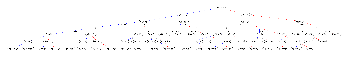

In [13]:
plt.figure(figsize=(15,15), dpi=300)
ax = plot_tree(model, num_trees=4)
ax.

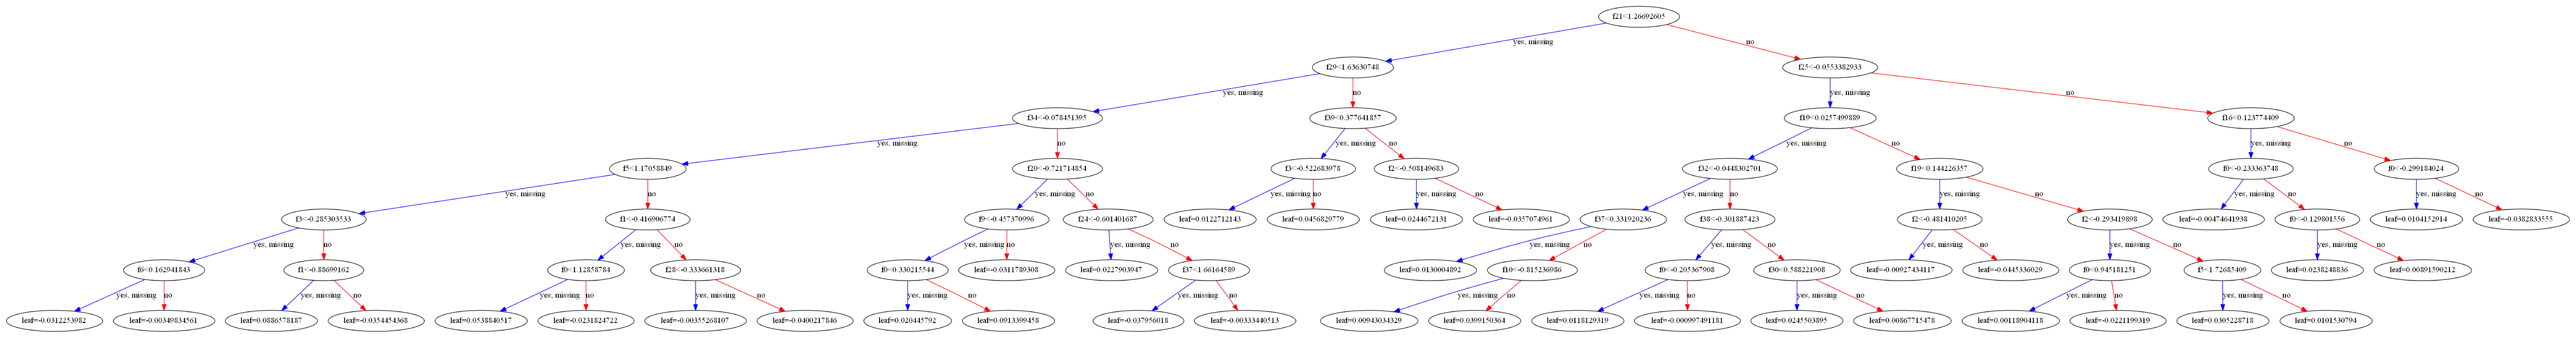

In [16]:
fig, ax = plt.subplots(figsize=(80, 80), dpi=300)
xgb.plot_tree(model, num_trees=4, ax=ax)
plt.show()

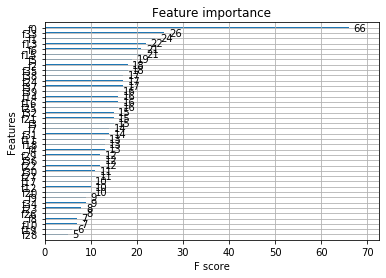

In [75]:
plot_importance(model)

In [7]:
df_best = pd.DataFrame()
for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
    for lat in ["CON", "IPS"]:
        for loc in ["ECOG", "STN"]:
            for hem in ["RIGHT", "LEFT"]:
                df_extr = df[(df["sub"] == sub) & (df["lat"] == lat) & (df["loc"] == loc)]
                df_extr_cpy = df_extr.copy()
                for index, row in df_extr_cpy.iterrows():
                    if hem not in row["ch_"]:
                        df_extr = df_extr.drop(index)
                if df_extr.shape[0] != 0:
                    df_best = df_best.append(df_extr.loc[df_extr["r2"].argmax()], ignore_index=True)


C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if sys.path[0] == '':


In [8]:
def get_arr_feature_per(df_use, loc="ECOG", lat="CON", importance_type="gain"):

    df_here = df_use[(df_use["loc"] == loc) & (df_use["lat"] == lat)]
    arr_best_importances = np.zeros([df_here.shape[0], 40])
    for idx, l_importances in enumerate(df_here.sort_values("r2", ascending=False)[importance_type]):
        try:
            arr_best_importances[idx,:] = l_importances
        except:
            # well, this is strange, sometimes features seem to be completely discareded 
            pass

    time_points = 5
    f_bands = 8
    arr_reshaped = np.zeros([arr_best_importances.shape[0], 8, 5])
    for t_out in range(arr_best_importances.shape[0]):
        for t_i in range(time_points):
            for f_idx, val in enumerate(arr_best_importances[t_out,f_bands*t_i:f_bands*t_i+8]): 
                arr_reshaped[t_out,f_idx,t_i] = val
    return arr_reshaped, arr_best_importances

In [9]:
def create_subplot(arr_reshaped):
    plt.imshow(arr_reshaped.mean(axis=0), aspect='auto')
    plt.gca().invert_yaxis()
    plt.colorbar()
    ax = plt.gca();
    ax.set_yticks(np.arange(0, 8, 1));
    ax.set_yticklabels([r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    ax.set_xticks(np.arange(0, 5, 1))
    ax.set_xticklabels(['0', '-100', '-200', '-300', '-400'], rotation=45)
    plt.xlabel("Time [ms]")
    plt.xlim(-0.5,4.5)
    plt.gca().invert_xaxis()

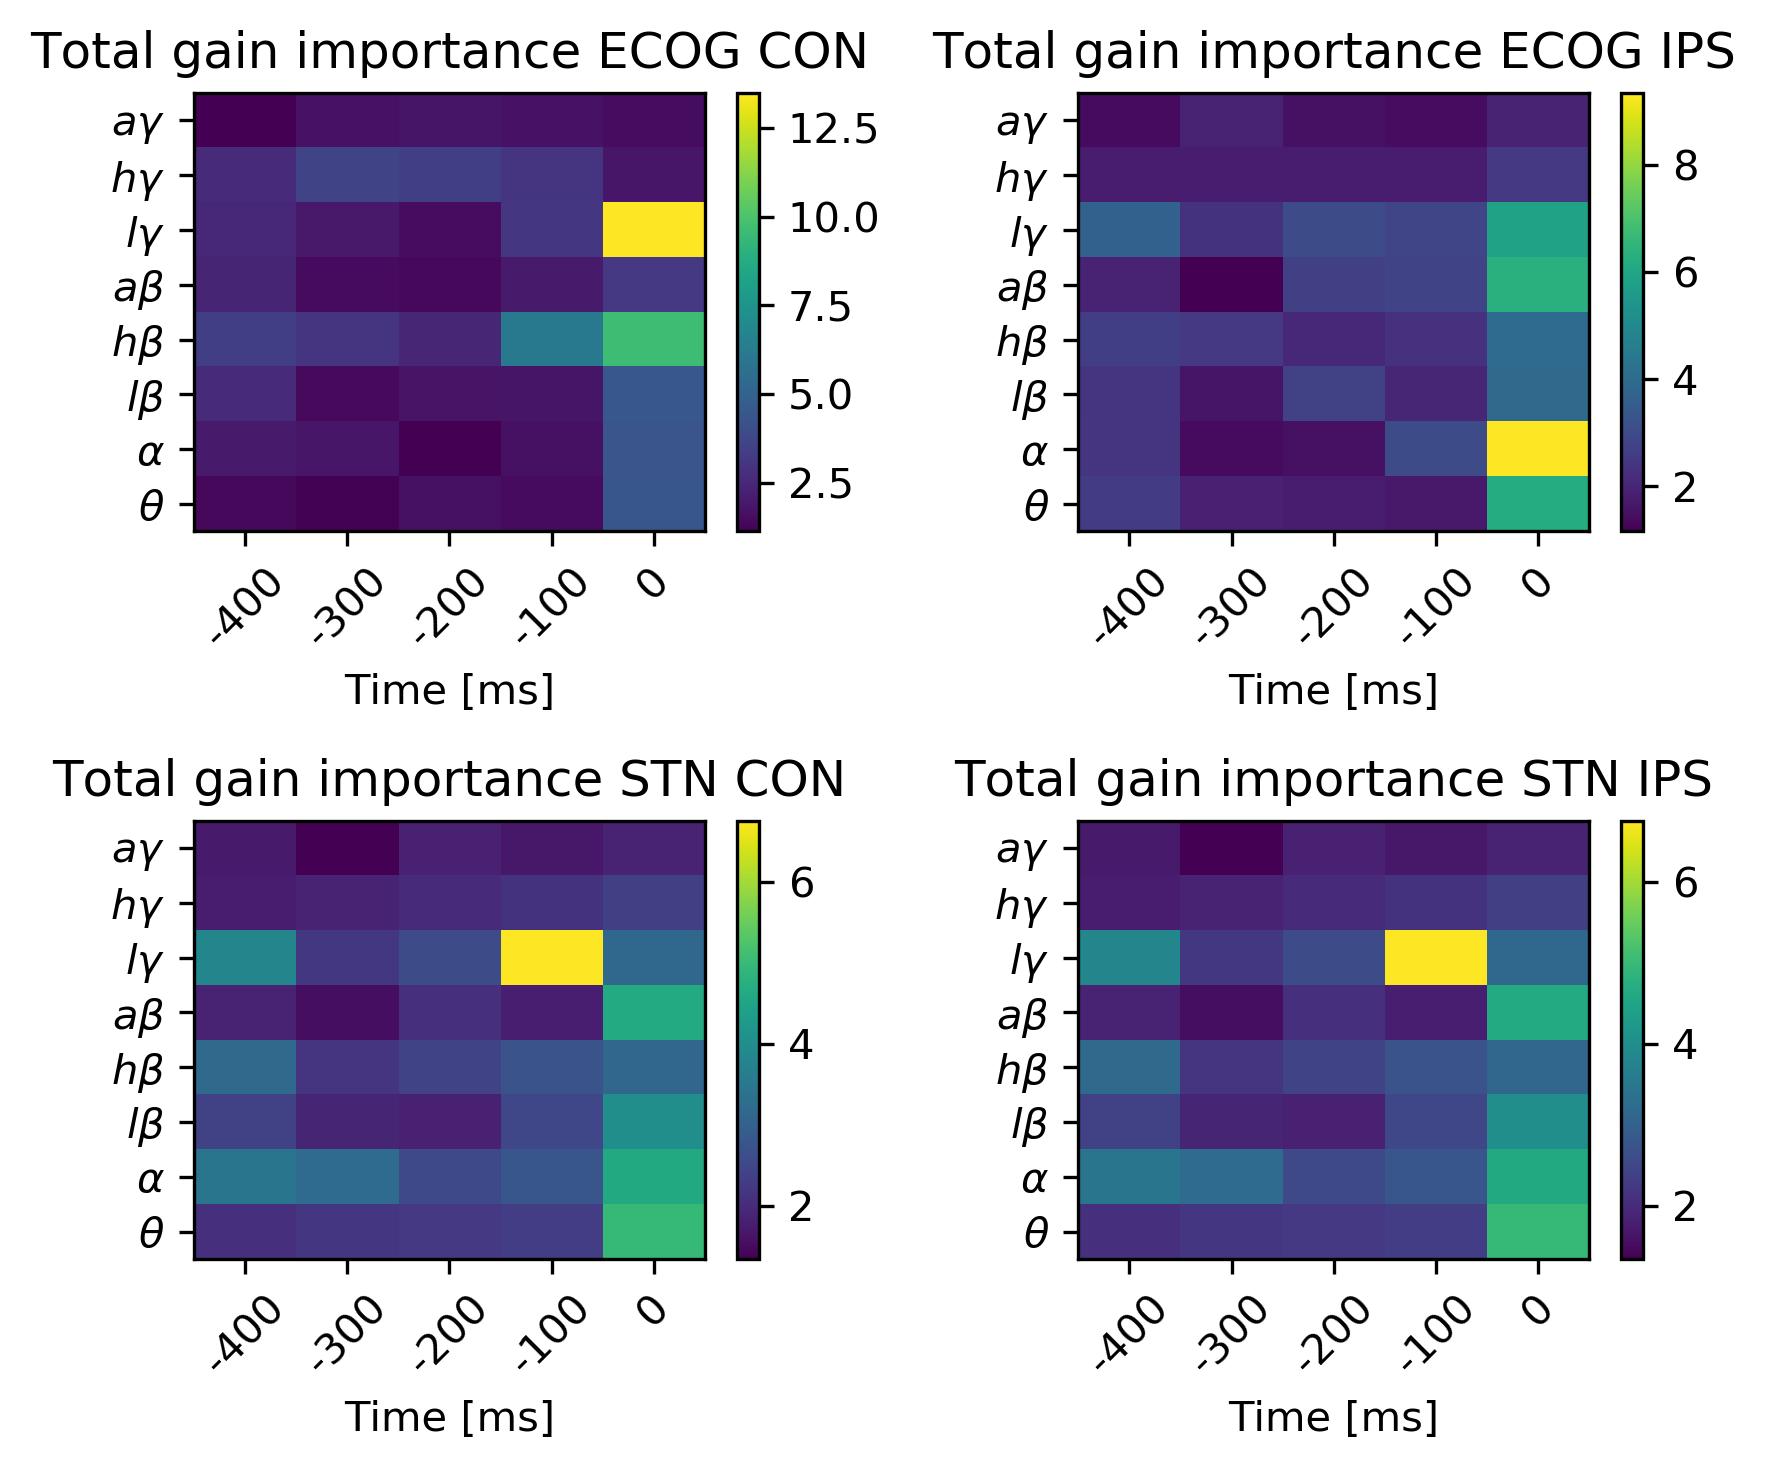

In [10]:
importance_type = "importances_total_gain"
title_ = "Total gain importance"
plt.figure(figsize=(6,5), dpi=300)
plt.subplot(221)
arr_reshaped, _ = get_arr_feature_per(df_best, loc="ECOG", lat="CON", importance_type=importance_type)
create_subplot(arr_reshaped)
plt.title(title_+ " ECOG CON")
plt.subplot(222)
arr_reshaped, _ = get_arr_feature_per(df_best, loc="ECOG", lat="IPS", importance_type=importance_type)
create_subplot(arr_reshaped)
plt.title(title_+ " ECOG IPS")
plt.subplot(223)
arr_reshaped, _ = get_arr_feature_per(df_best, loc="STN", lat="CON", importance_type=importance_type)
create_subplot(arr_reshaped)
plt.title(title_+ " STN CON")
plt.subplot(224)
arr_reshaped, _ = get_arr_feature_per(df_best, loc="STN", lat="CON", importance_type=importance_type)
create_subplot(arr_reshaped)
plt.title(title_+ " STN IPS")
plt.tight_layout()

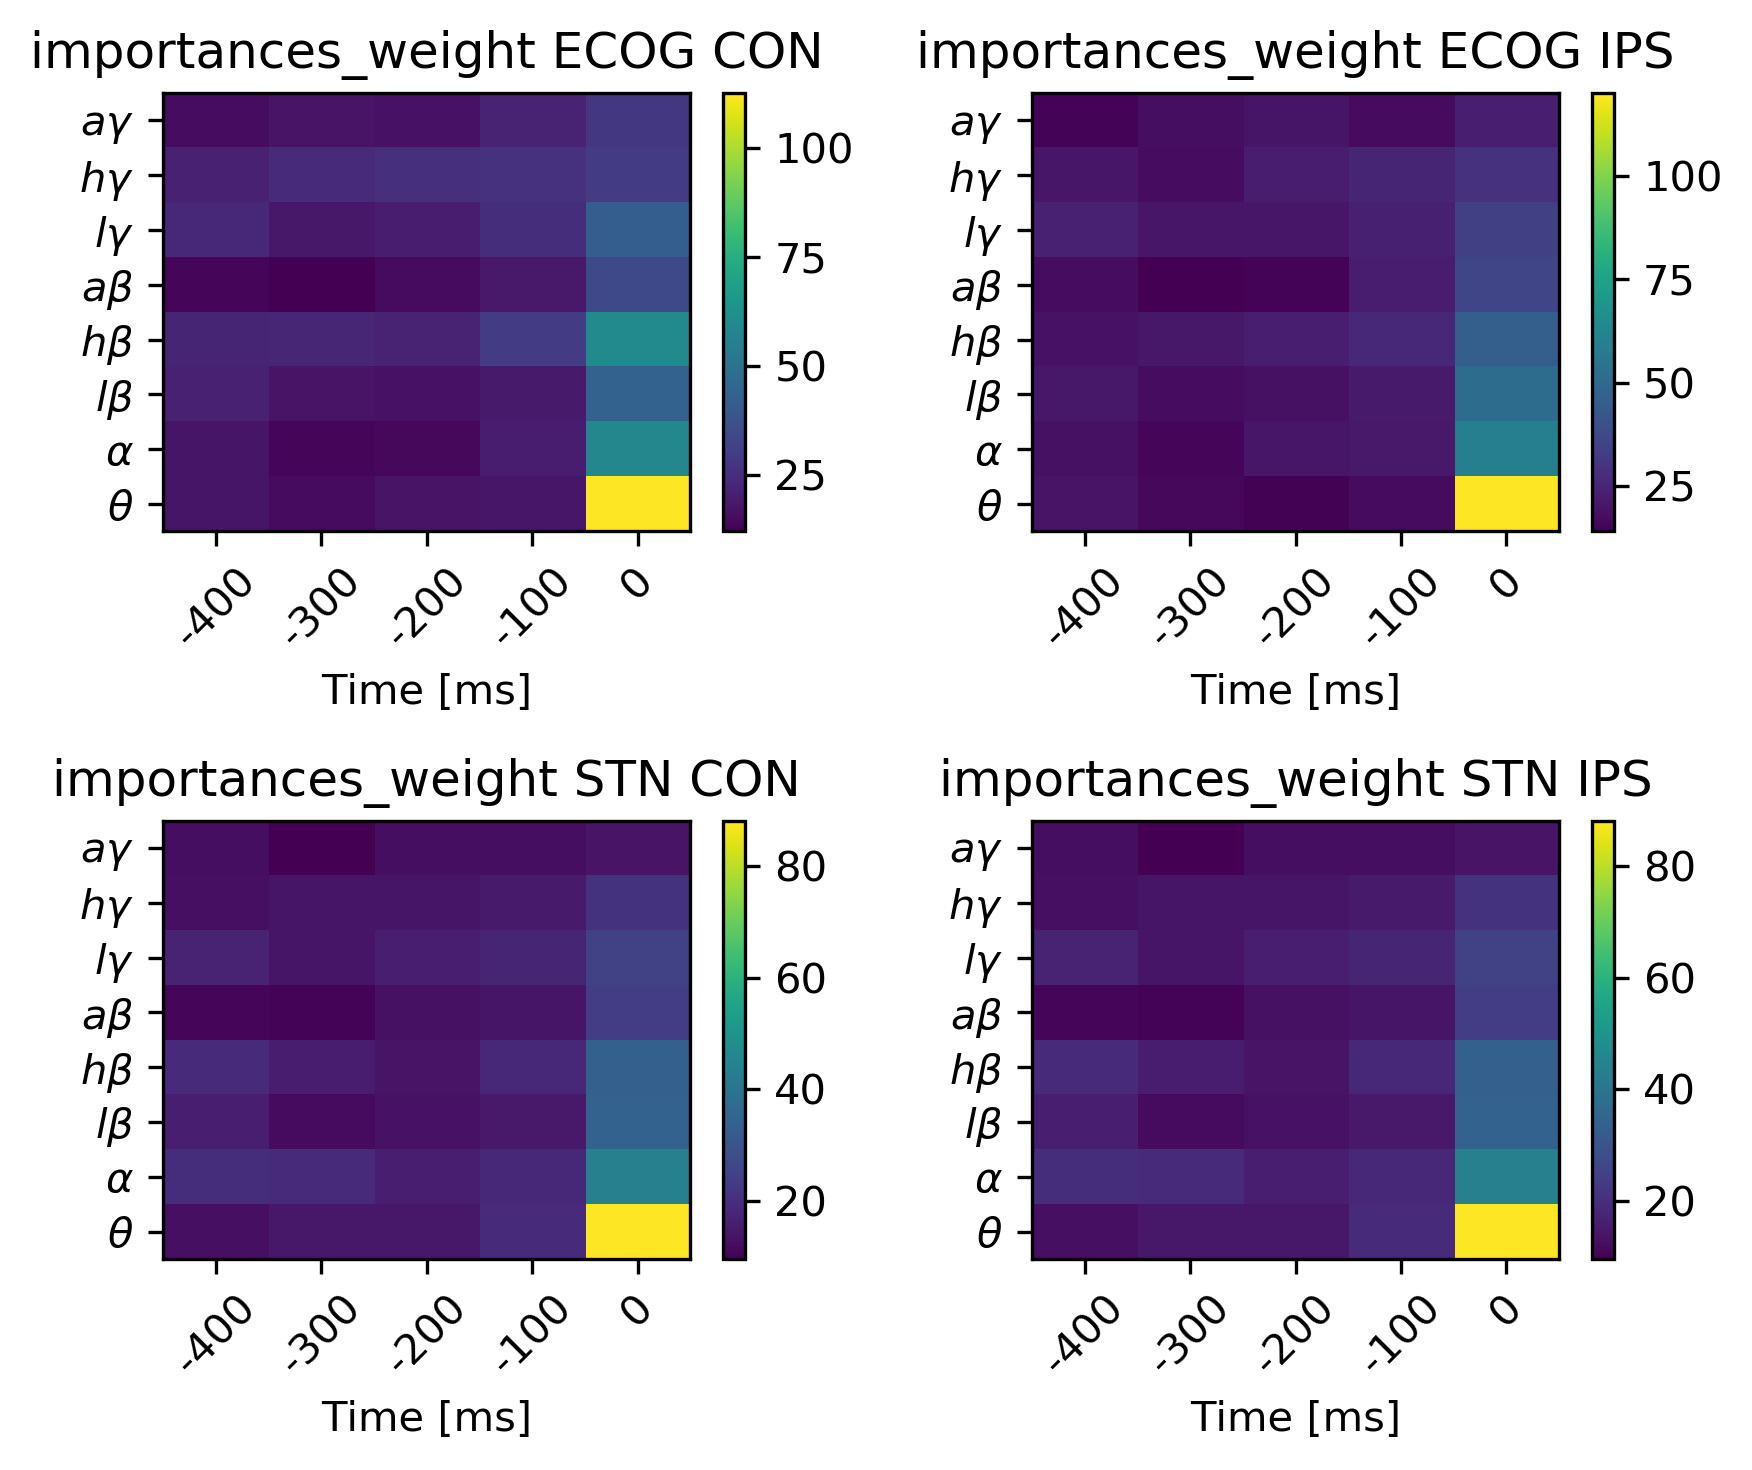

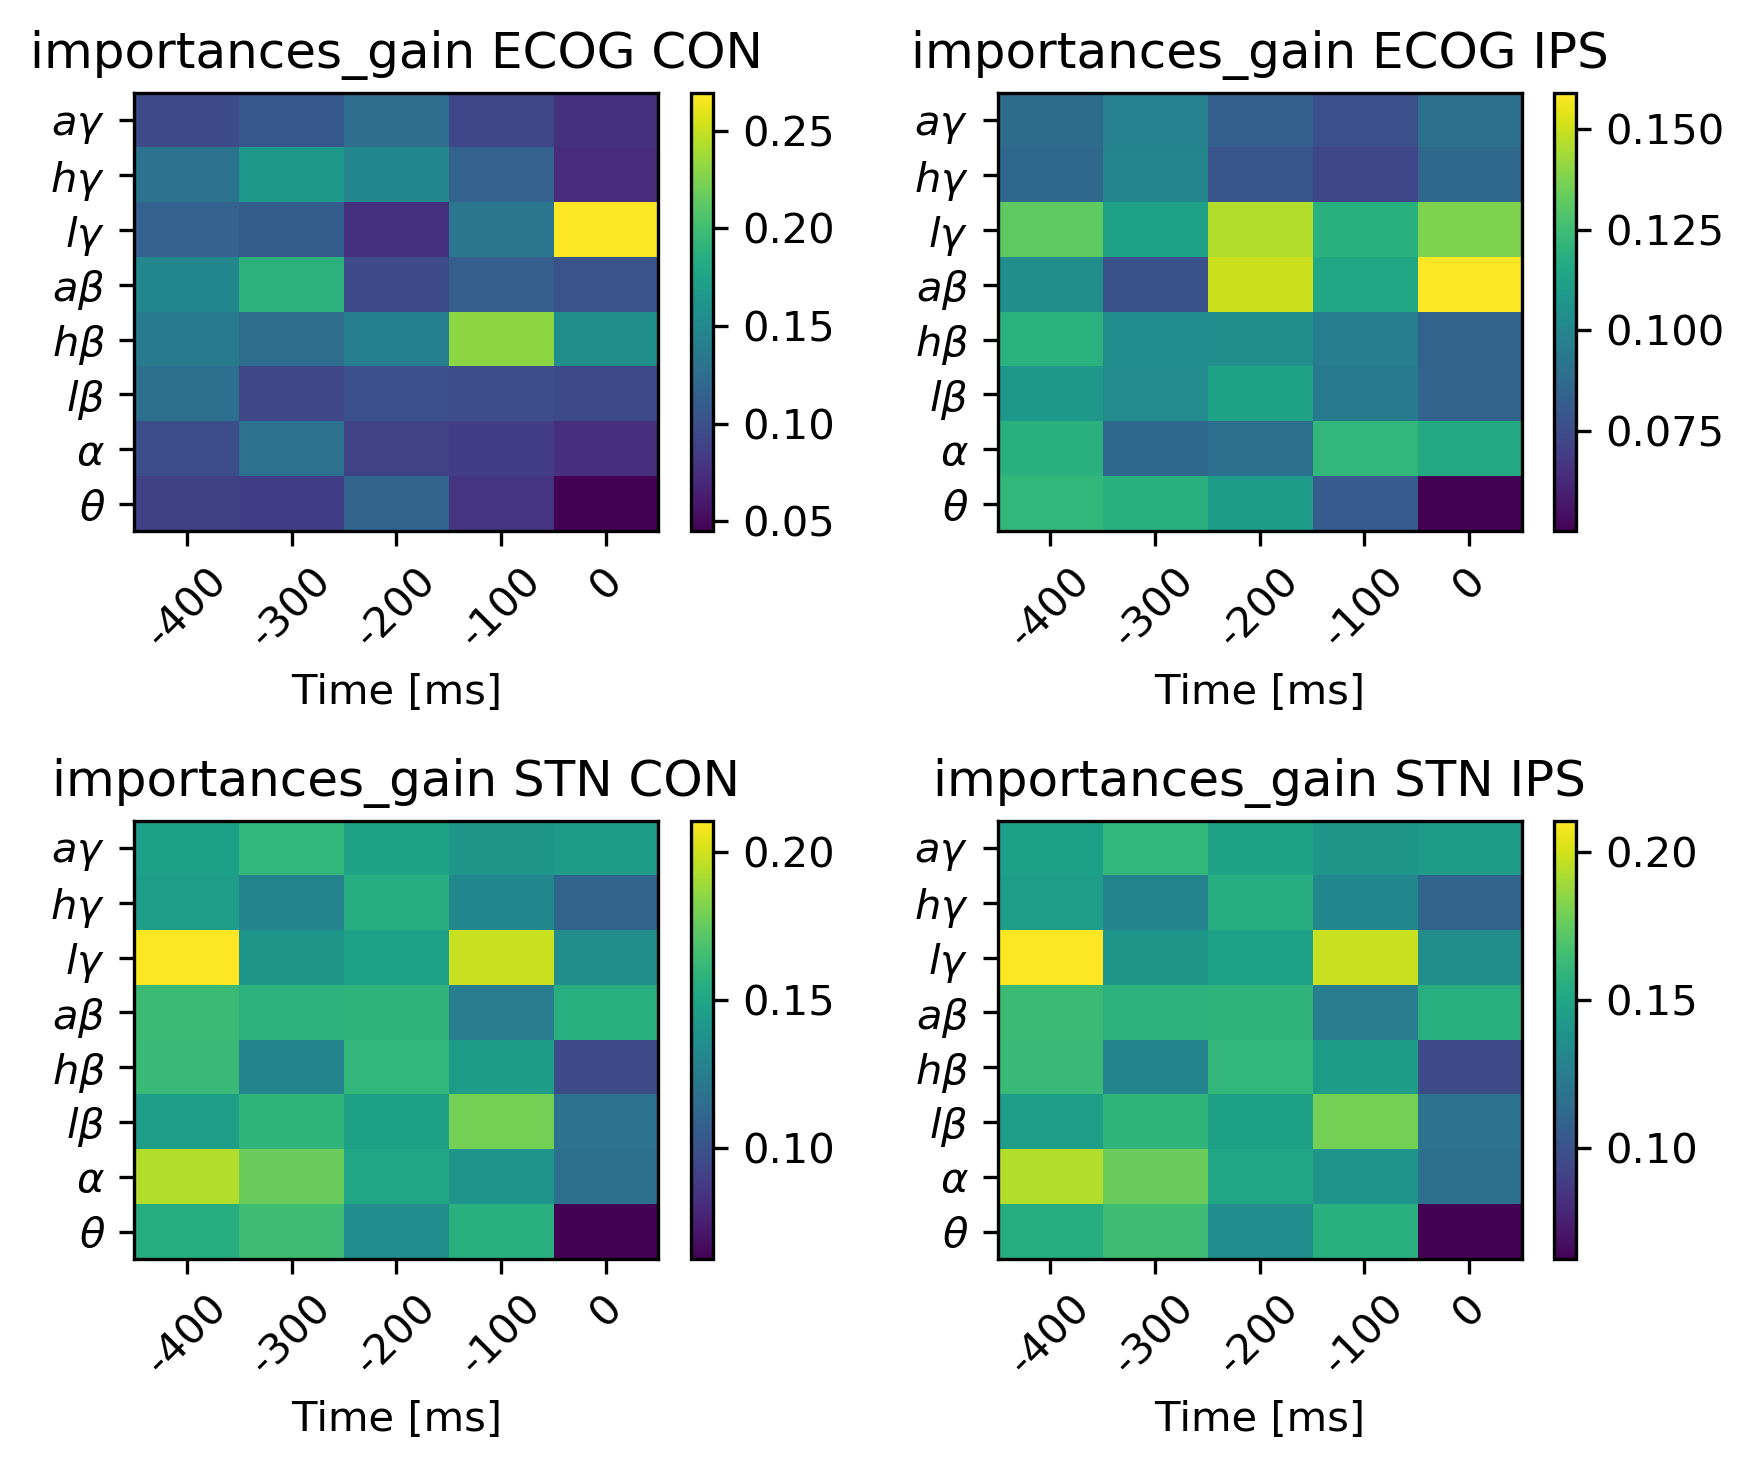

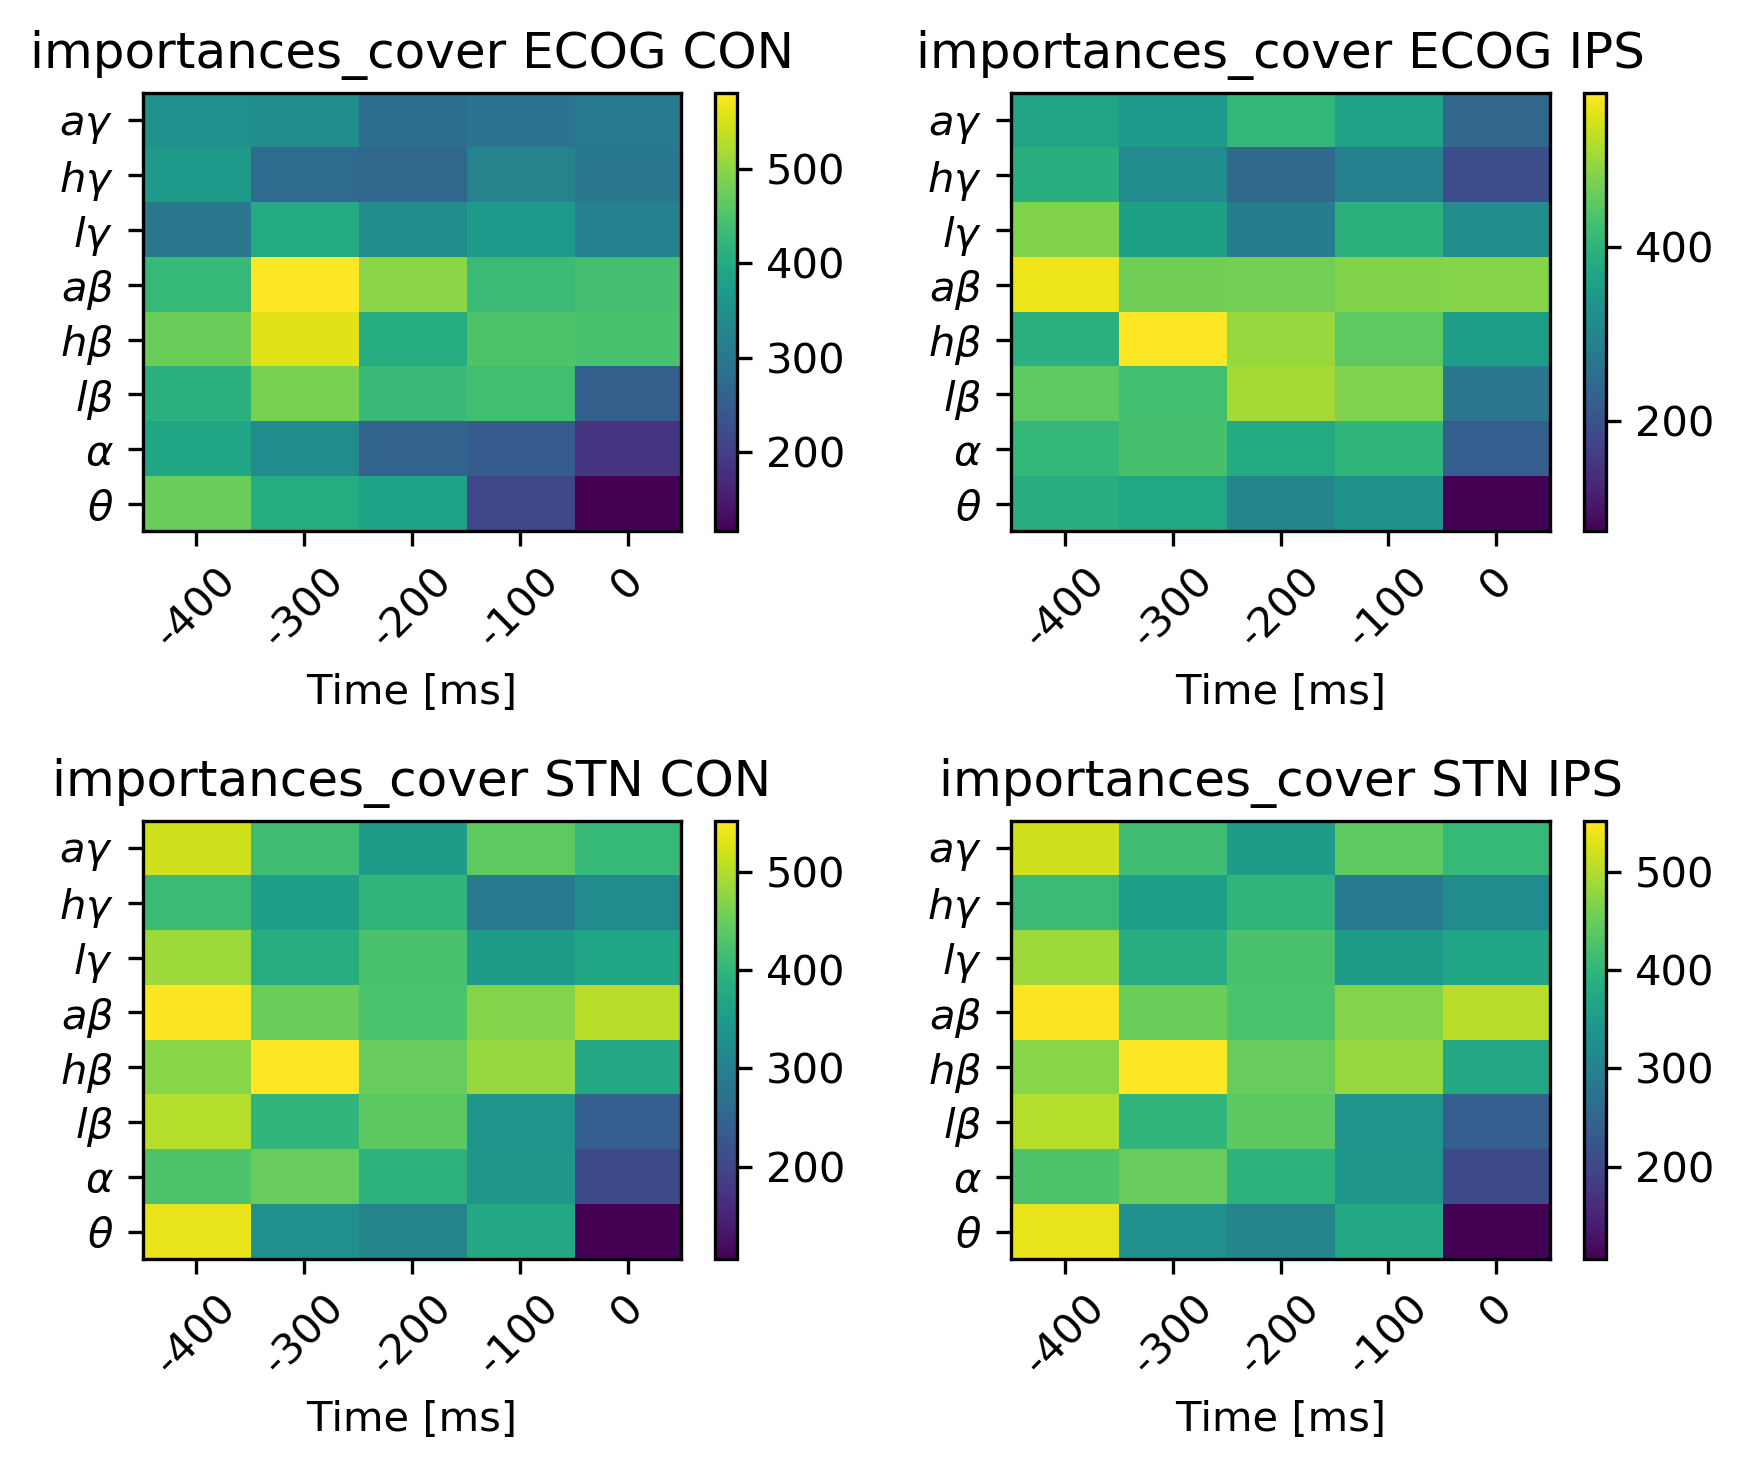

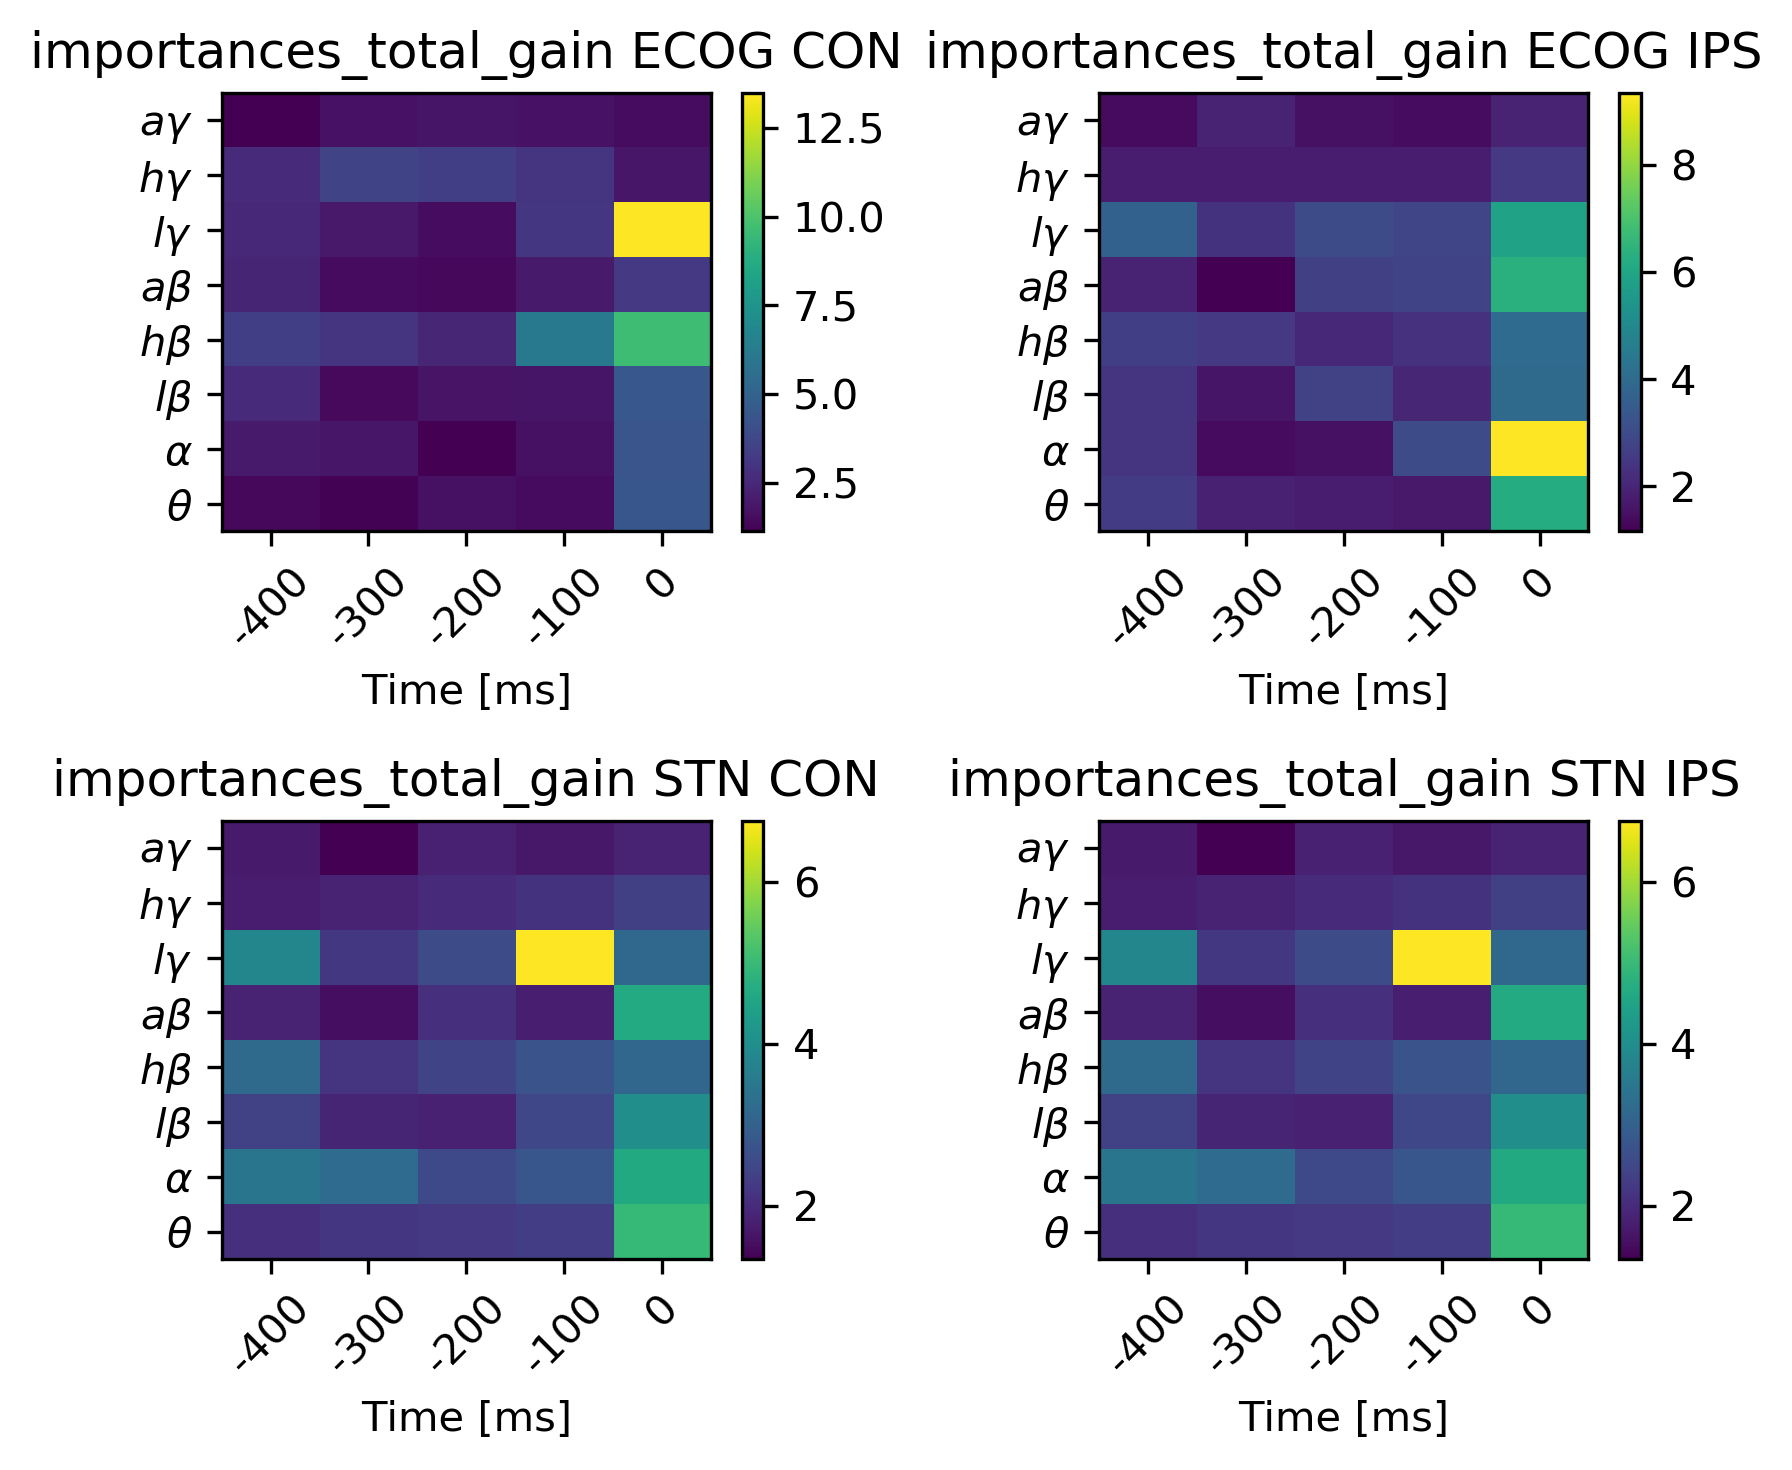

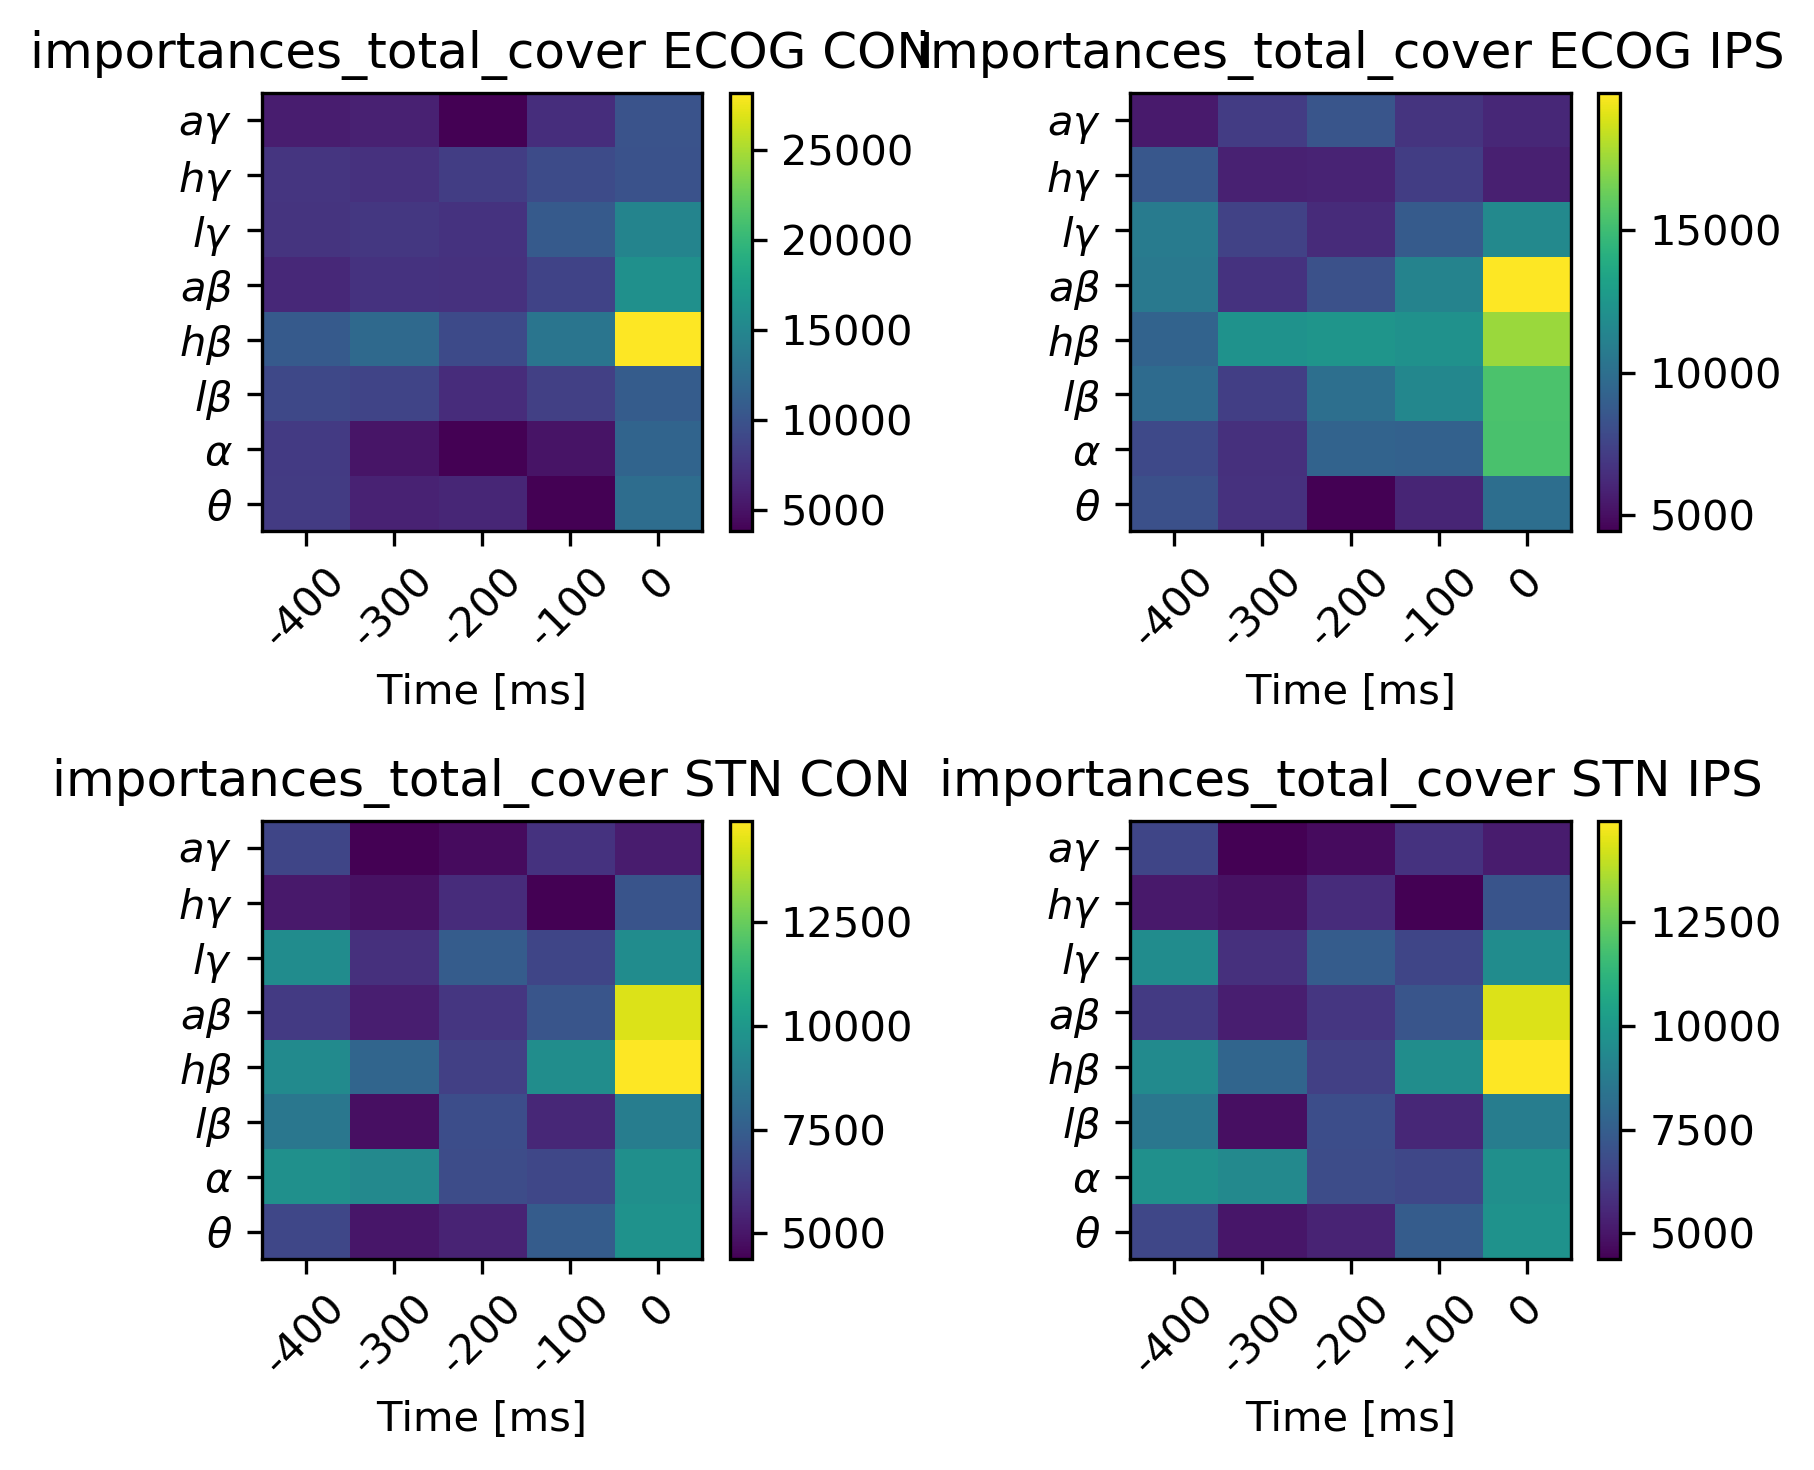

In [11]:
for importance_type in ["importances_weight", "importances_gain", "importances_cover", "importances_total_gain", "importances_total_cover"]:
    plt.figure(figsize=(6,5), dpi=300)
    plt.subplot(221)
    arr_reshaped, _ = get_arr_feature_per(df_best, loc="ECOG", lat="CON", importance_type=importance_type)
    create_subplot(arr_reshaped)
    plt.title(importance_type+ " ECOG CON")
    plt.subplot(222)
    arr_reshaped, _ = get_arr_feature_per(df_best, loc="ECOG", lat="IPS", importance_type=importance_type)
    create_subplot(arr_reshaped)
    plt.title(importance_type+ " ECOG IPS")
    plt.subplot(223)
    arr_reshaped, _ = get_arr_feature_per(df_best, loc="STN", lat="CON", importance_type=importance_type)
    create_subplot(arr_reshaped)
    plt.title(importance_type+ " STN CON")
    plt.subplot(224)
    arr_reshaped, _ = get_arr_feature_per(df_best, loc="STN", lat="CON", importance_type=importance_type)
    create_subplot(arr_reshaped)
    plt.title(importance_type+ " STN IPS")
    plt.tight_layout()

In [12]:
df.to_pickle("df_XGB_importances.p")

In [7]:
df = pd.read_pickle("df_XGB_importances.p")

In [8]:
t_ = []
for time_idx in [0,1,2,3,4]:
    for band in [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$']:
        t_.append("t = "+str(time_idx)+" "+ band)

In [42]:
def plt_all_(loc, lat, importance_type):
    arr_reshaped, arr_ = get_arr_feature_per(df_best, loc=loc, lat=lat, importance_type=importance_type)
    plt.title(importance_type+ " "+ loc + " "+ lat)
    #plt.imshow(arr_, aspect='auto')
    plt.boxplot(arr_)
    #plt.colorbar()
    plt.xticks(np.arange(0,40,1), t_, rotation=90)
    #plt.ylabel("sub hem")
    plt.gca().invert_xaxis()

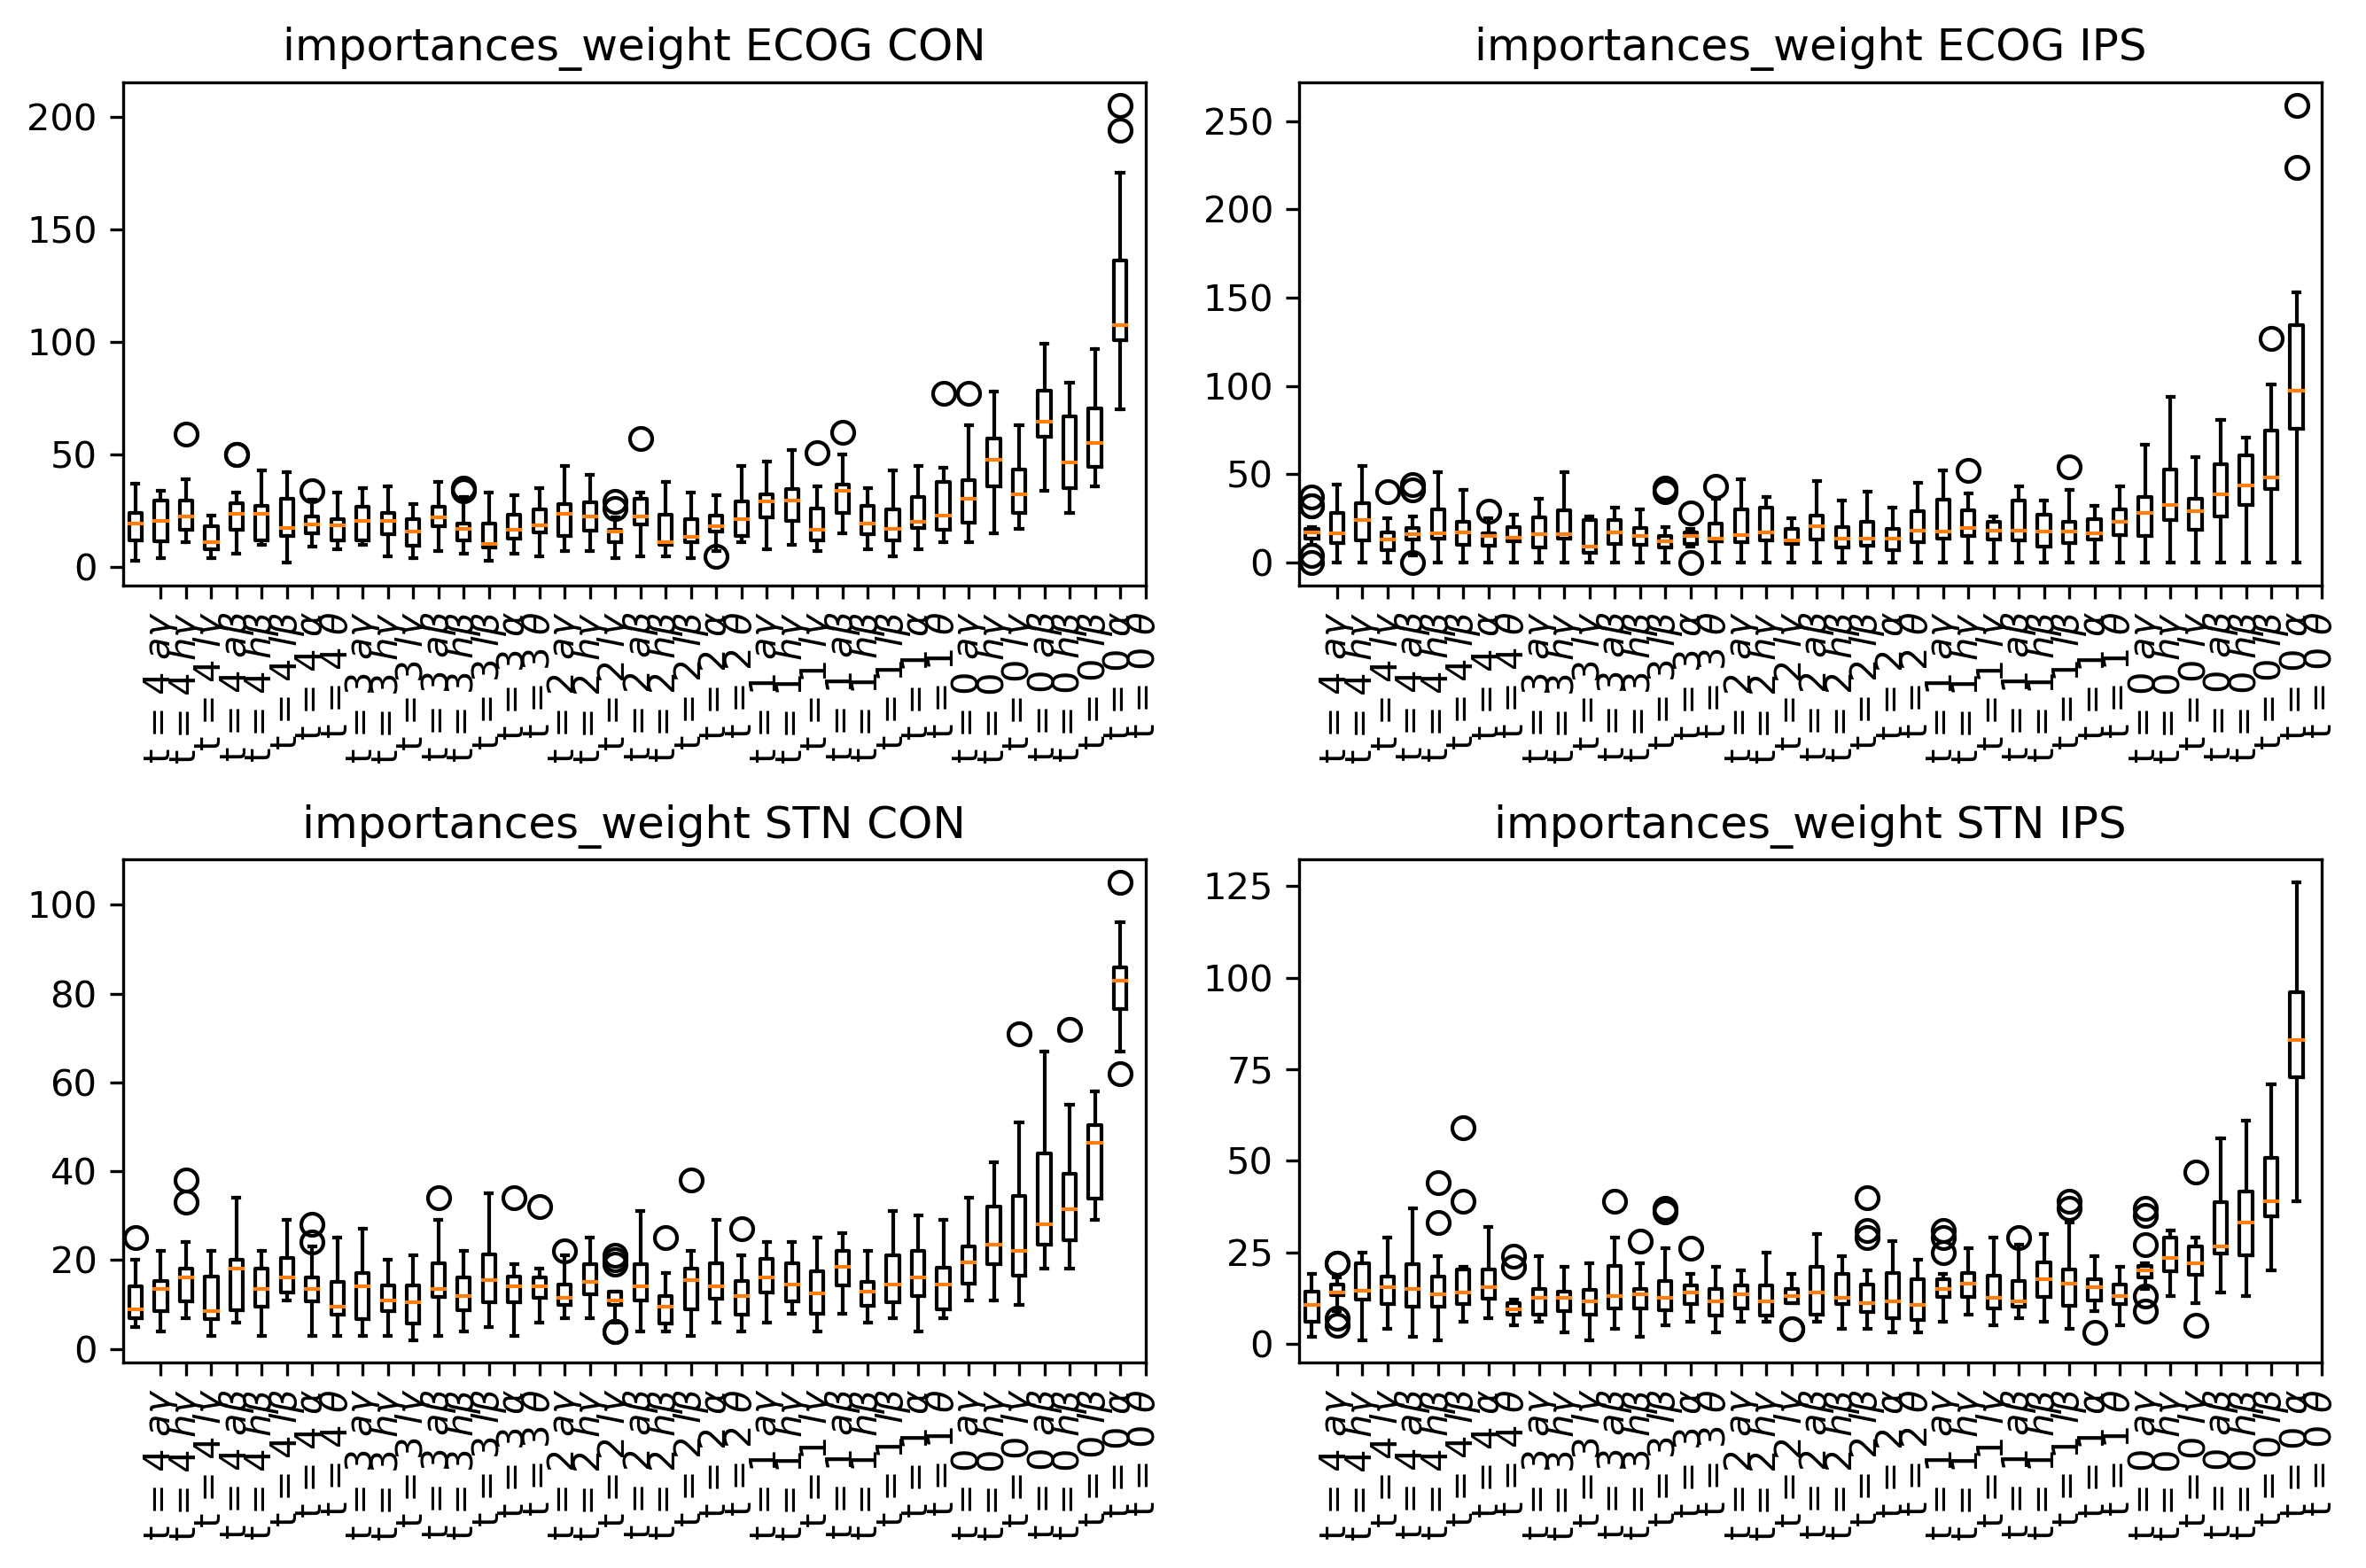

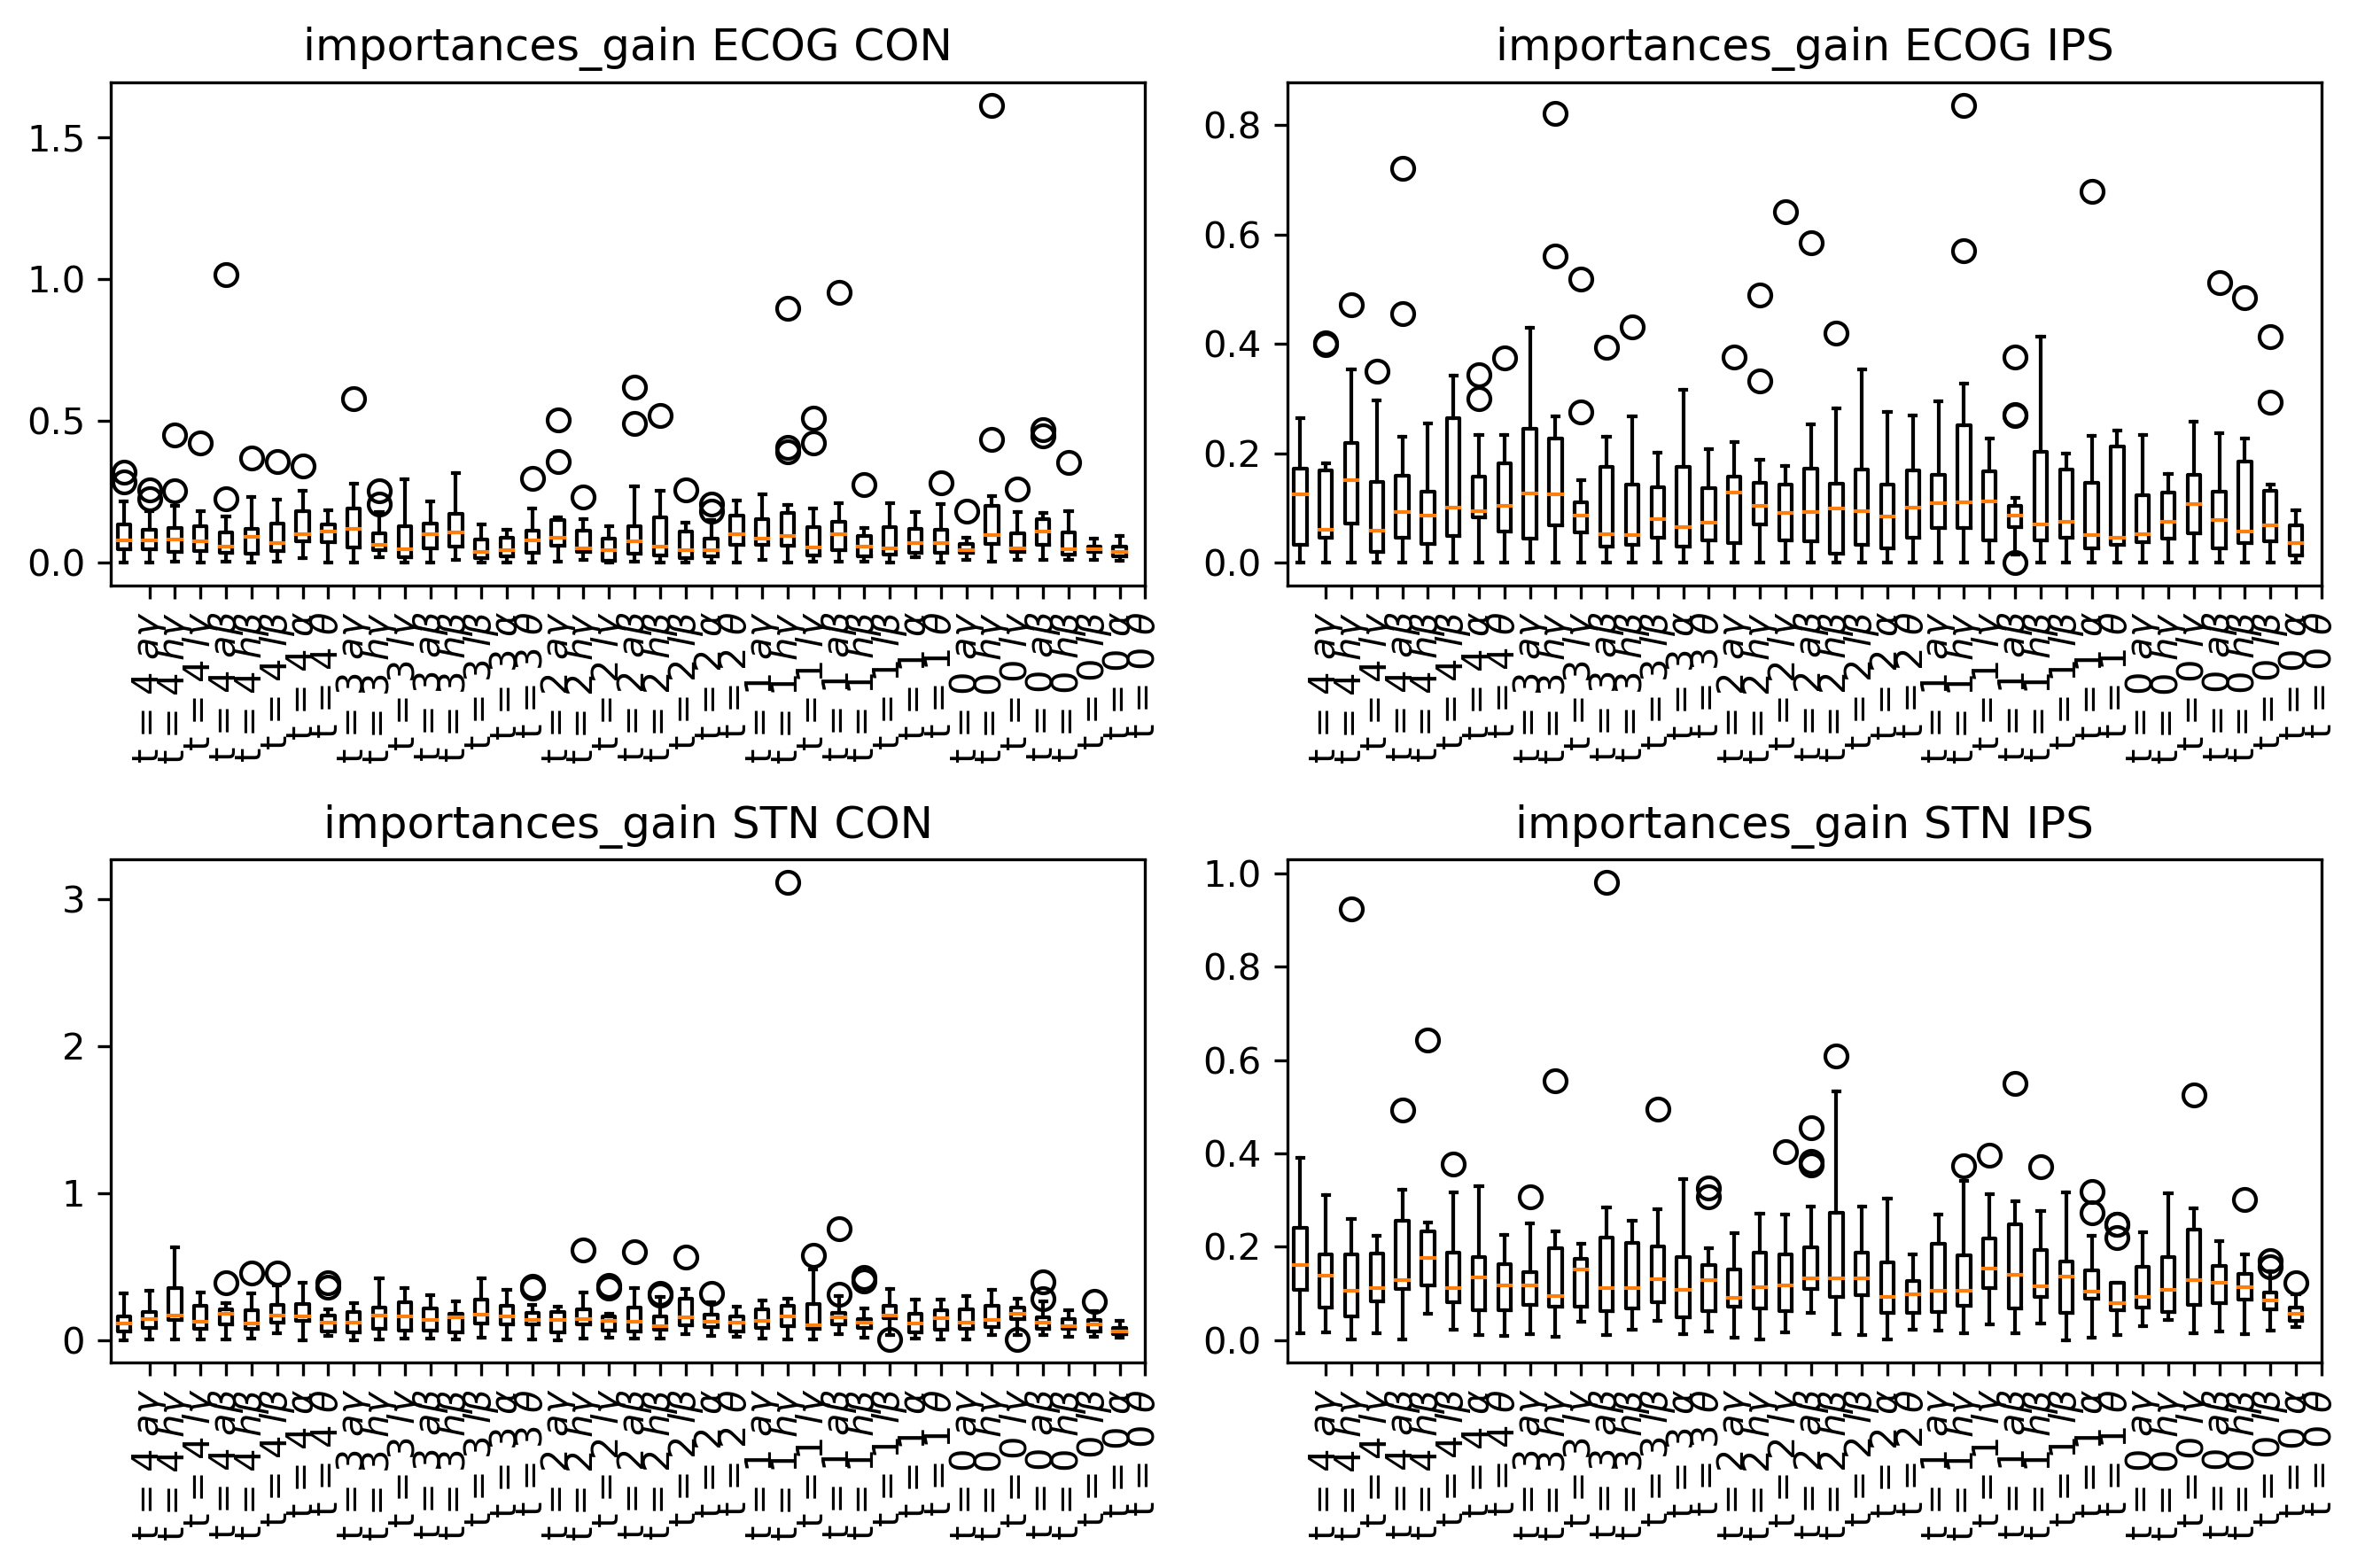

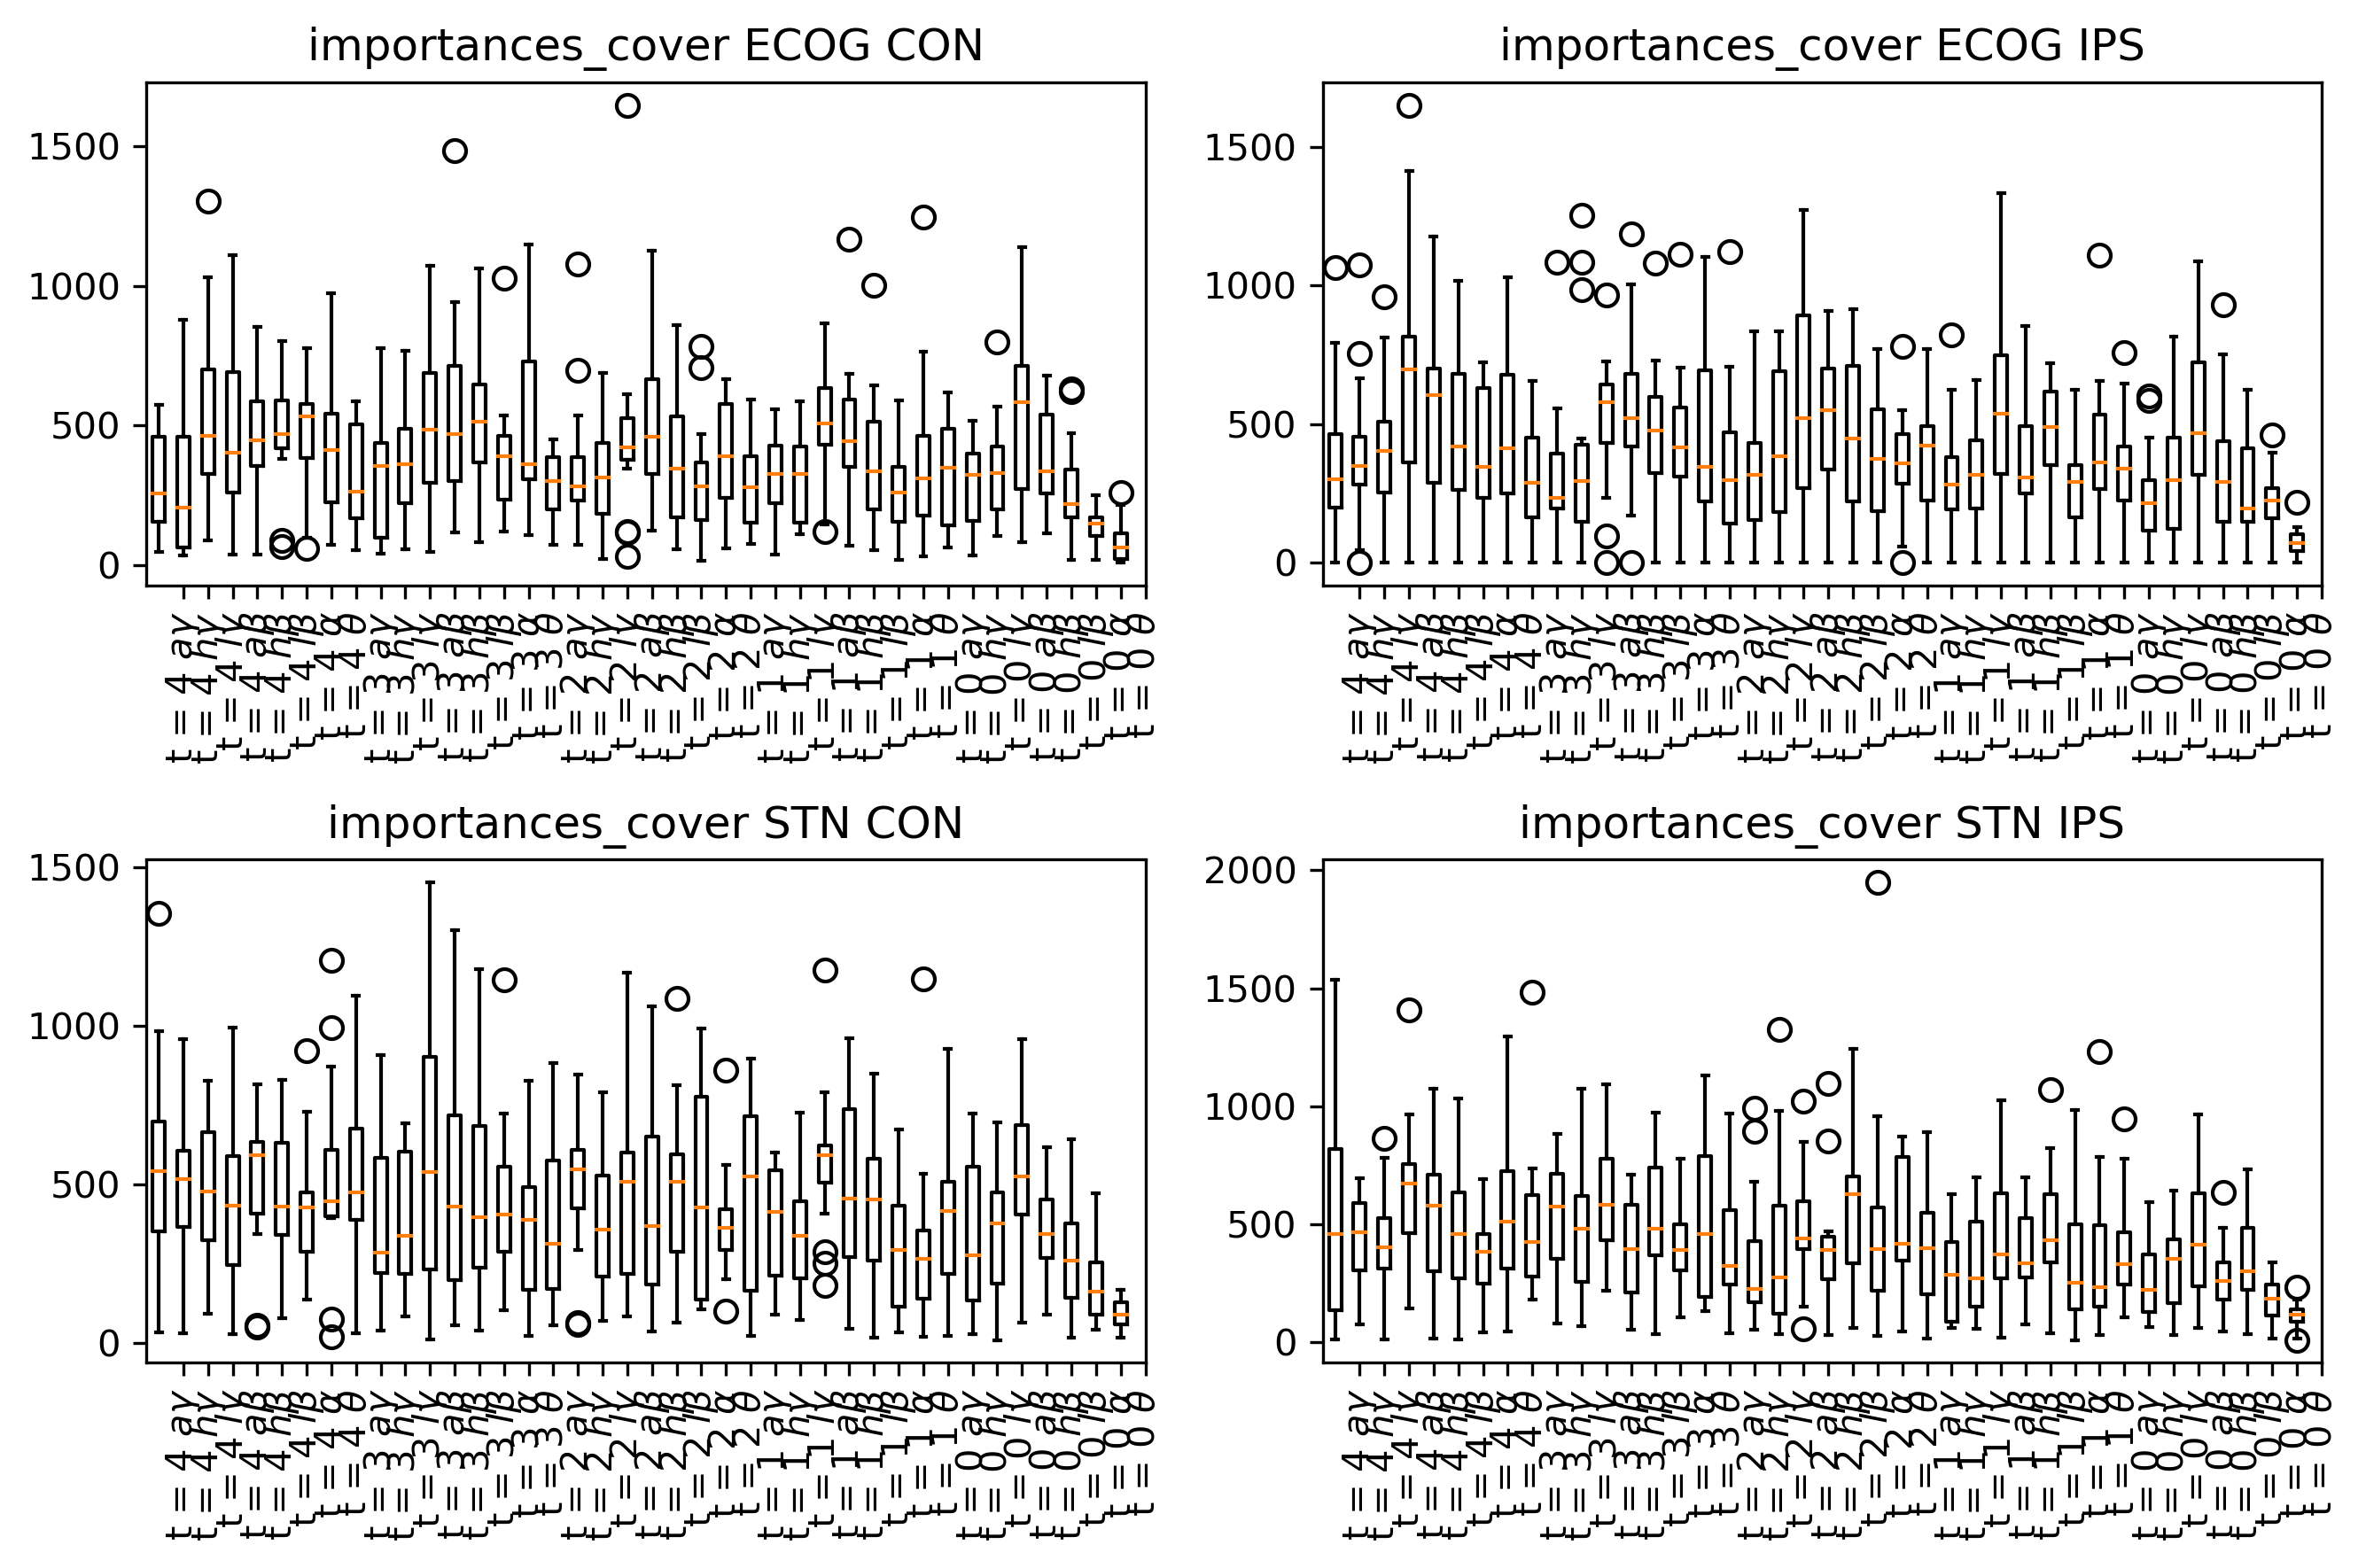

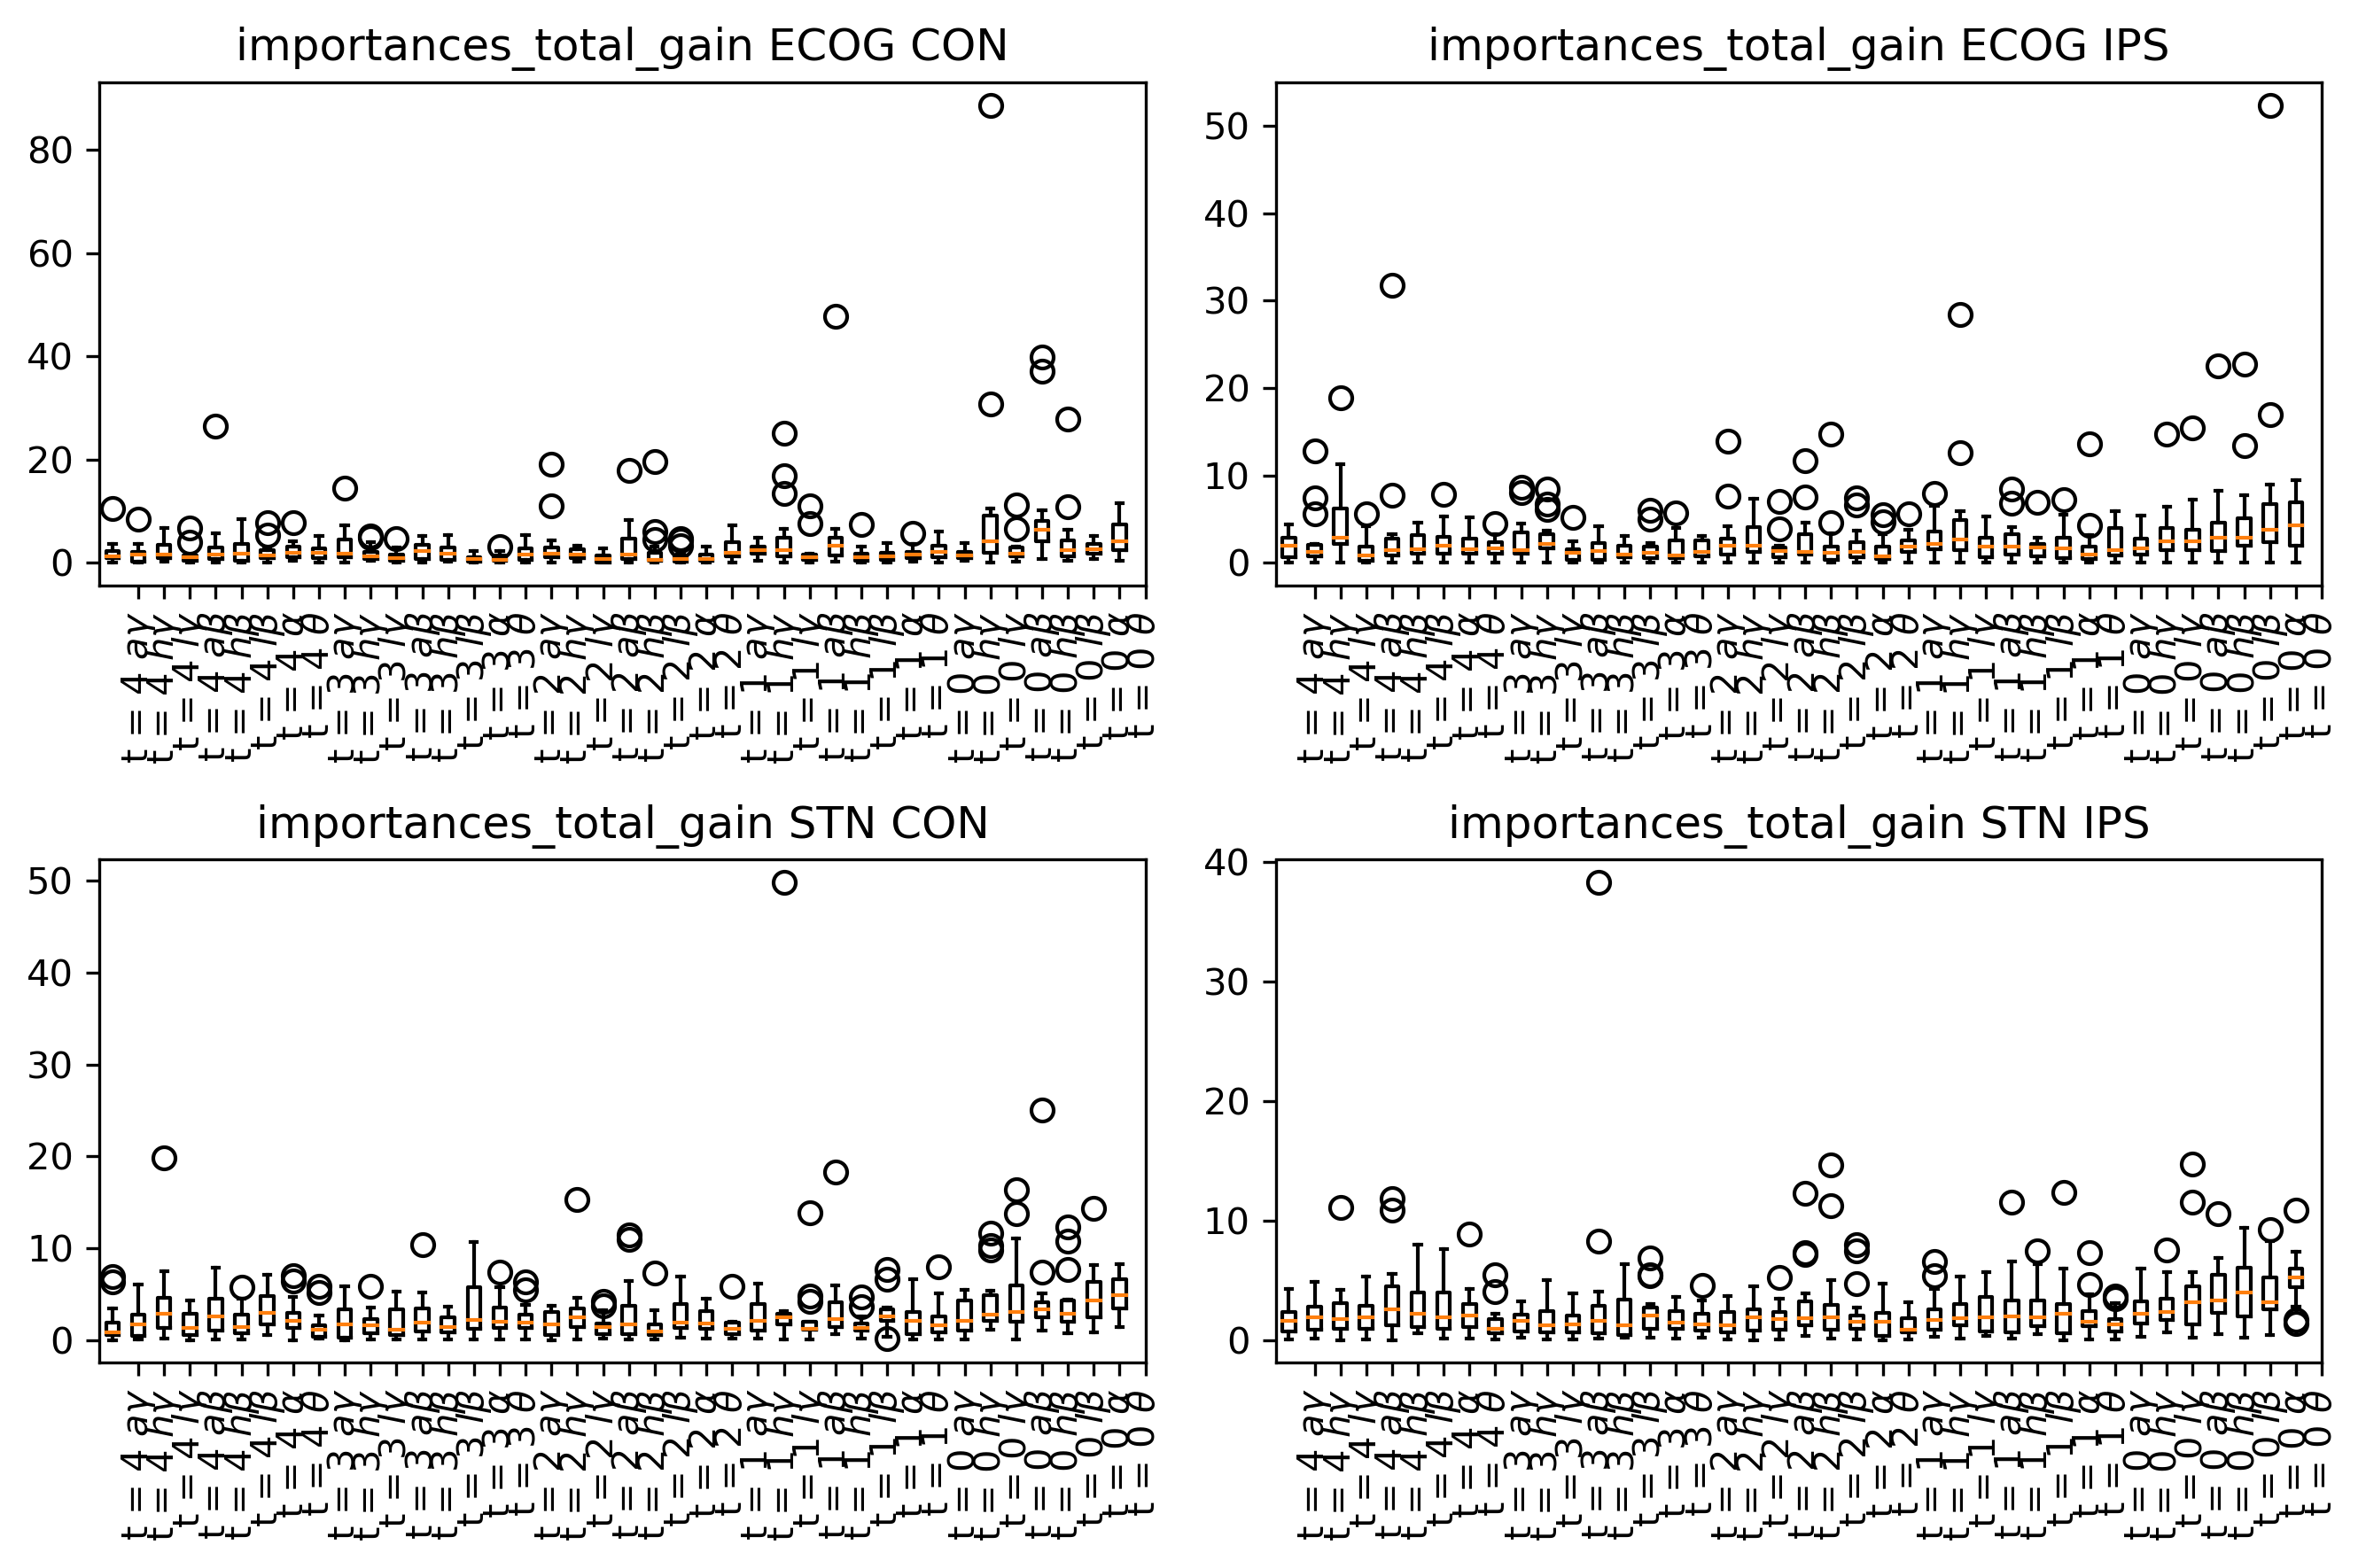

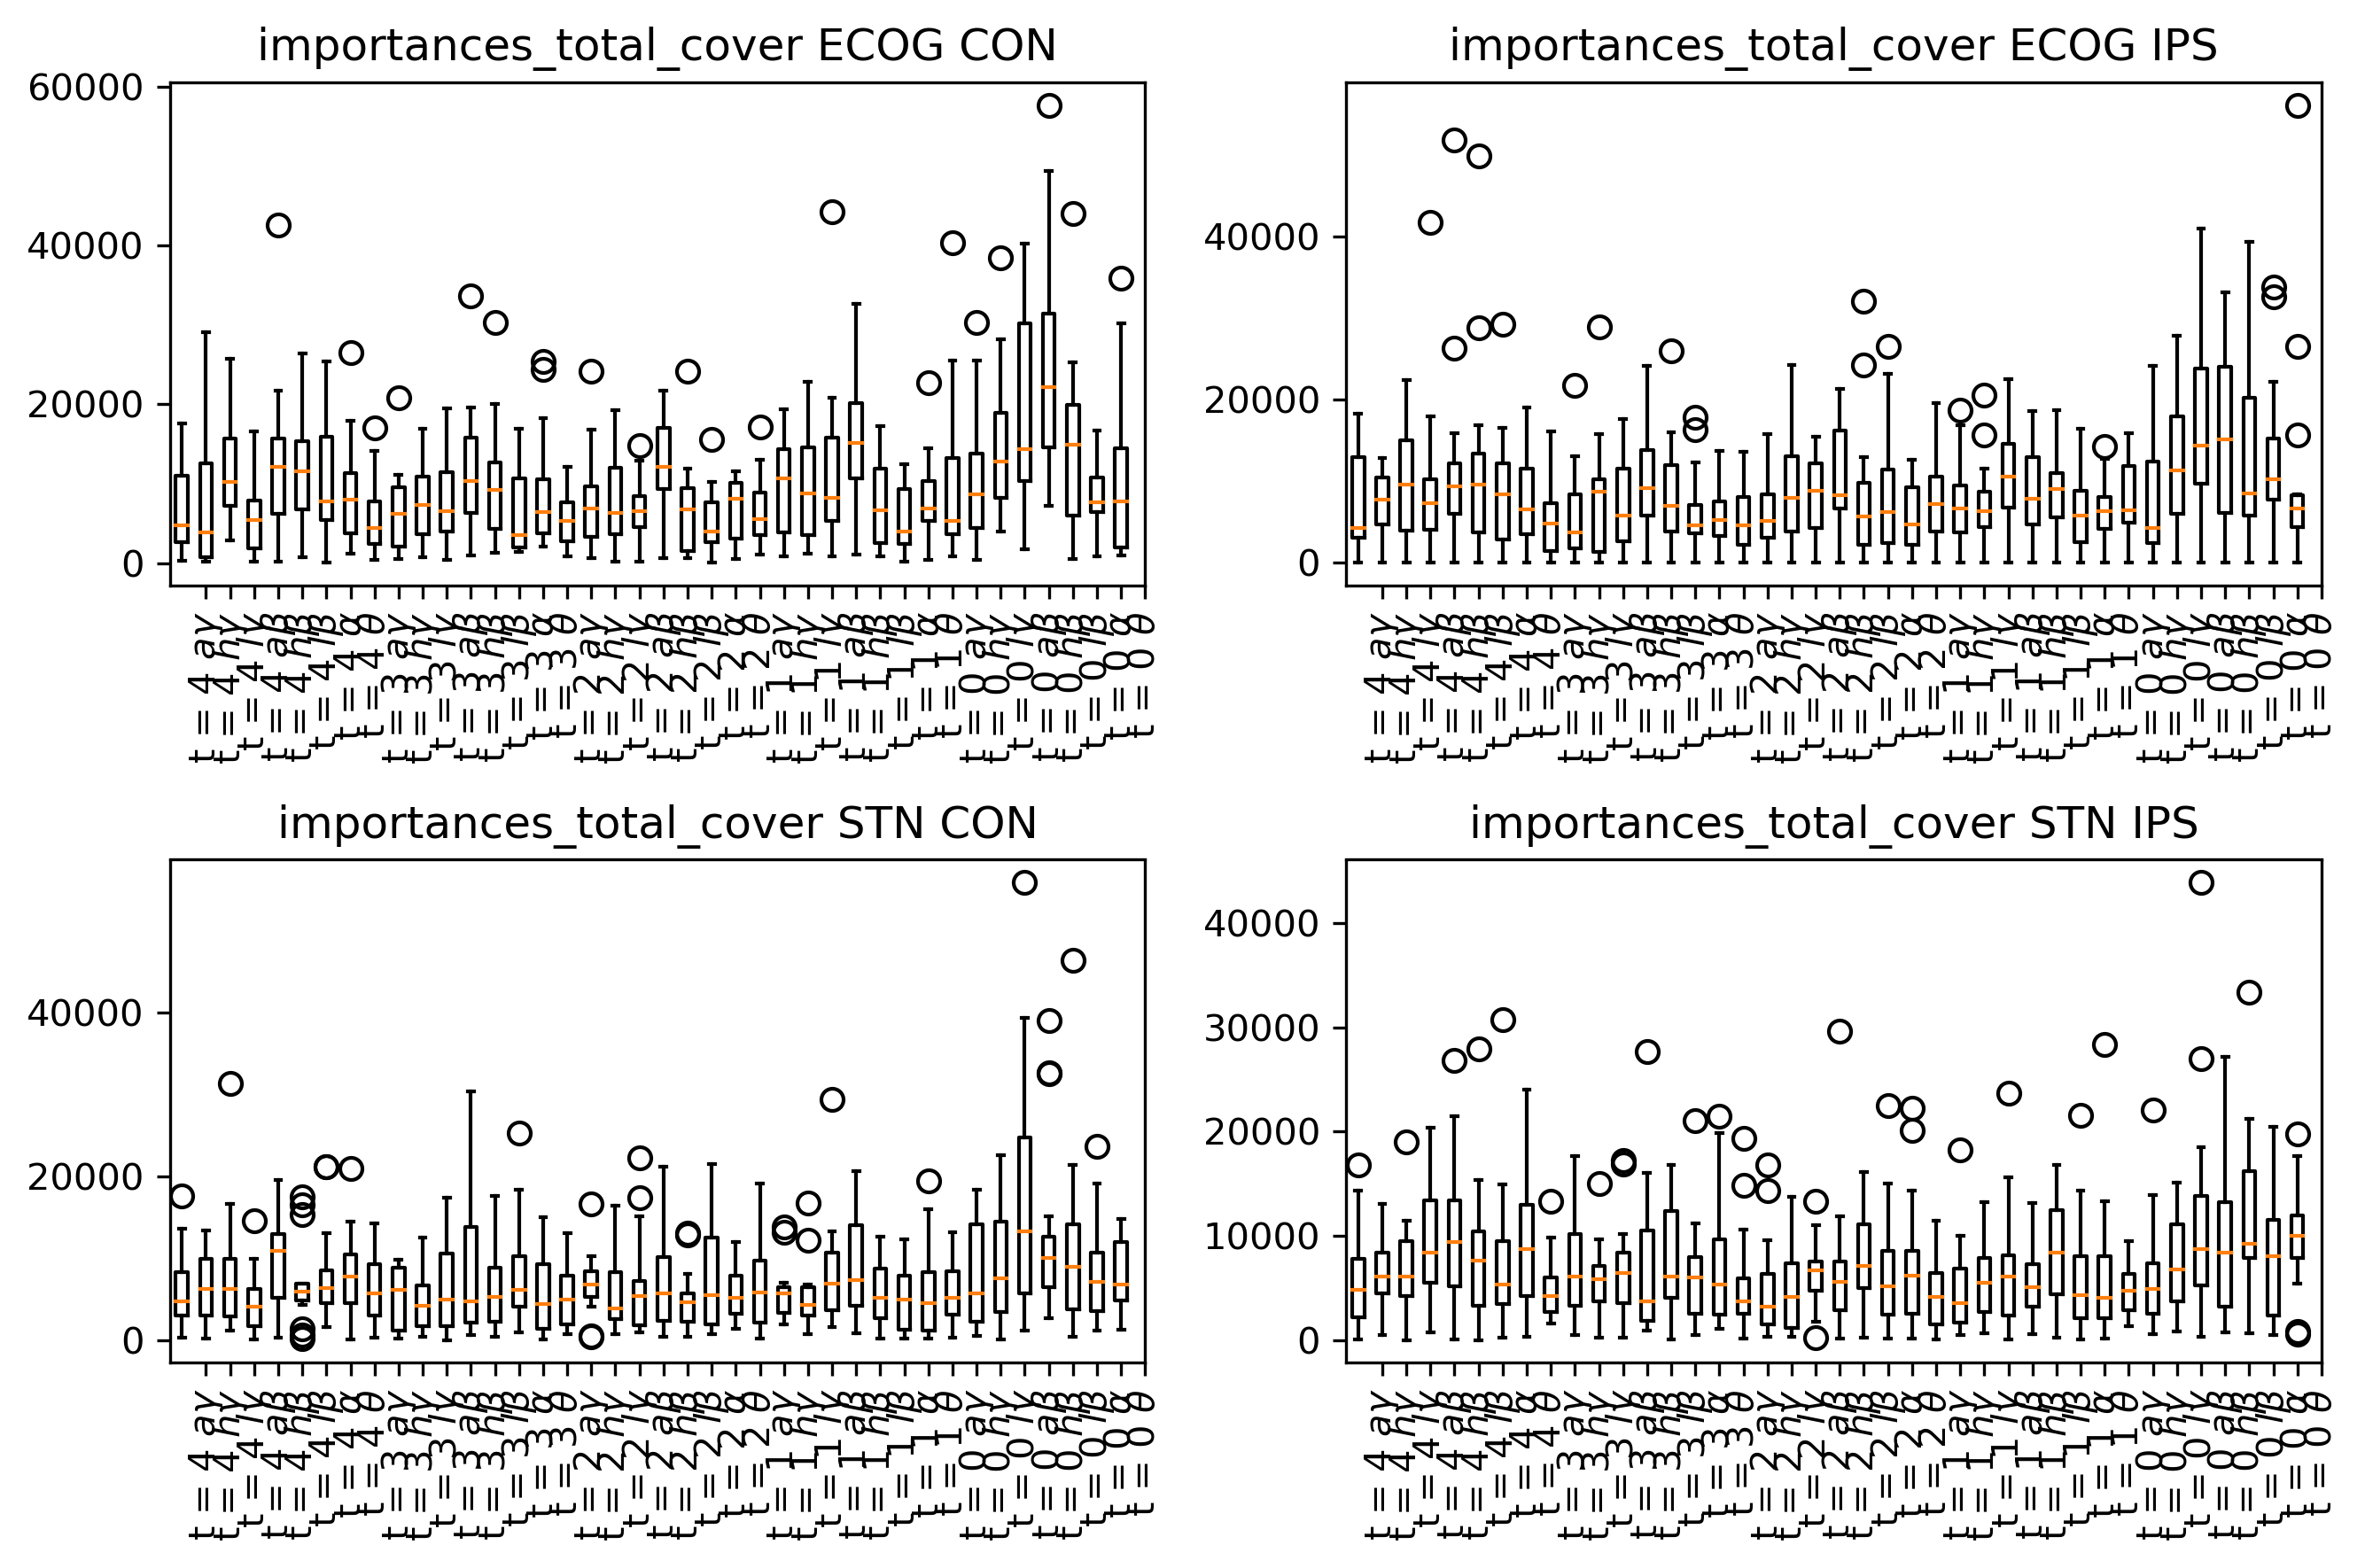

In [43]:
for importance_type in ["importances_weight", "importances_gain", "importances_cover", "importances_total_gain", "importances_total_cover"]:
    plt.figure(figsize=(9,6), dpi=300)
    plt.subplot(221)
    plt_all_("ECOG", "CON", importance_type)
    plt.subplot(222)
    plt_all_("ECOG", "IPS", importance_type)
    plt.subplot(223)
    plt_all_("STN", "CON", importance_type)
    plt.subplot(224)
    plt_all_("STN", "IPS", importance_type)
    plt.tight_layout()

In [ ]:
def create_subplot(arr_reshaped):
    plt.imshow(arr_reshaped.mean(axis=0), aspect='auto')
    plt.gca().invert_yaxis()
    plt.colorbar()
    ax = plt.gca();
    ax.set_yticks(np.arange(0, 8, 1));
    ax.set_yticklabels([r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    ax.set_xticks(np.arange(0, 5, 1))
    ax.set_xticklabels(['0', '-100', '-200', '-300', '-400'], rotation=45)
    plt.xlabel("Time [ms]")
    plt.xlim(-0.5,4.5)
    plt.gca().invert_xaxis()

In [45]:
arr_reshaped.shape

(16, 8, 5)

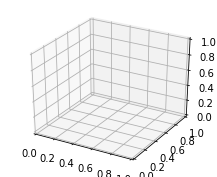

In [44]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax1.bar3d(x, y, bottom, width, depth, top, shade=True)

### Correlation Feature Analysis

In [68]:
def get_mean_corr_maps(df_use, loc="ECOG", lat="CON", ret_ALL = True):

    df_here = df_use[(df_use["loc"] == loc) & (df_use["lat"] == lat)]
    if ret_ALL is True:
        arr_corr = np.zeros([16,40,40])
        for sub_idx, sub in enumerate(df_here["sub"].unique()):
            arr_corr[sub_idx, :, :] = list(df_here[df_here["sub"] == sub]["corr_"])[0]
    else:
        arr_corr = np.zeros([16,8,8])
        for sub_idx, sub in enumerate(df_here["sub"].unique()):
            arr_corr[sub_idx, :, :] = list(df_here[df_here["sub"] == sub]["corr_"])[0][:8,:8]
    return arr_corr

In [57]:
sub

'014'

In [67]:
list(df_here[df_here["sub"] == sub]["corr_"])[0].shape

(40, 40)

In [70]:
get_mean_corr_maps(df_best, "ECOG", "CON", ret_ALL=True).shape

(16, 40, 40)

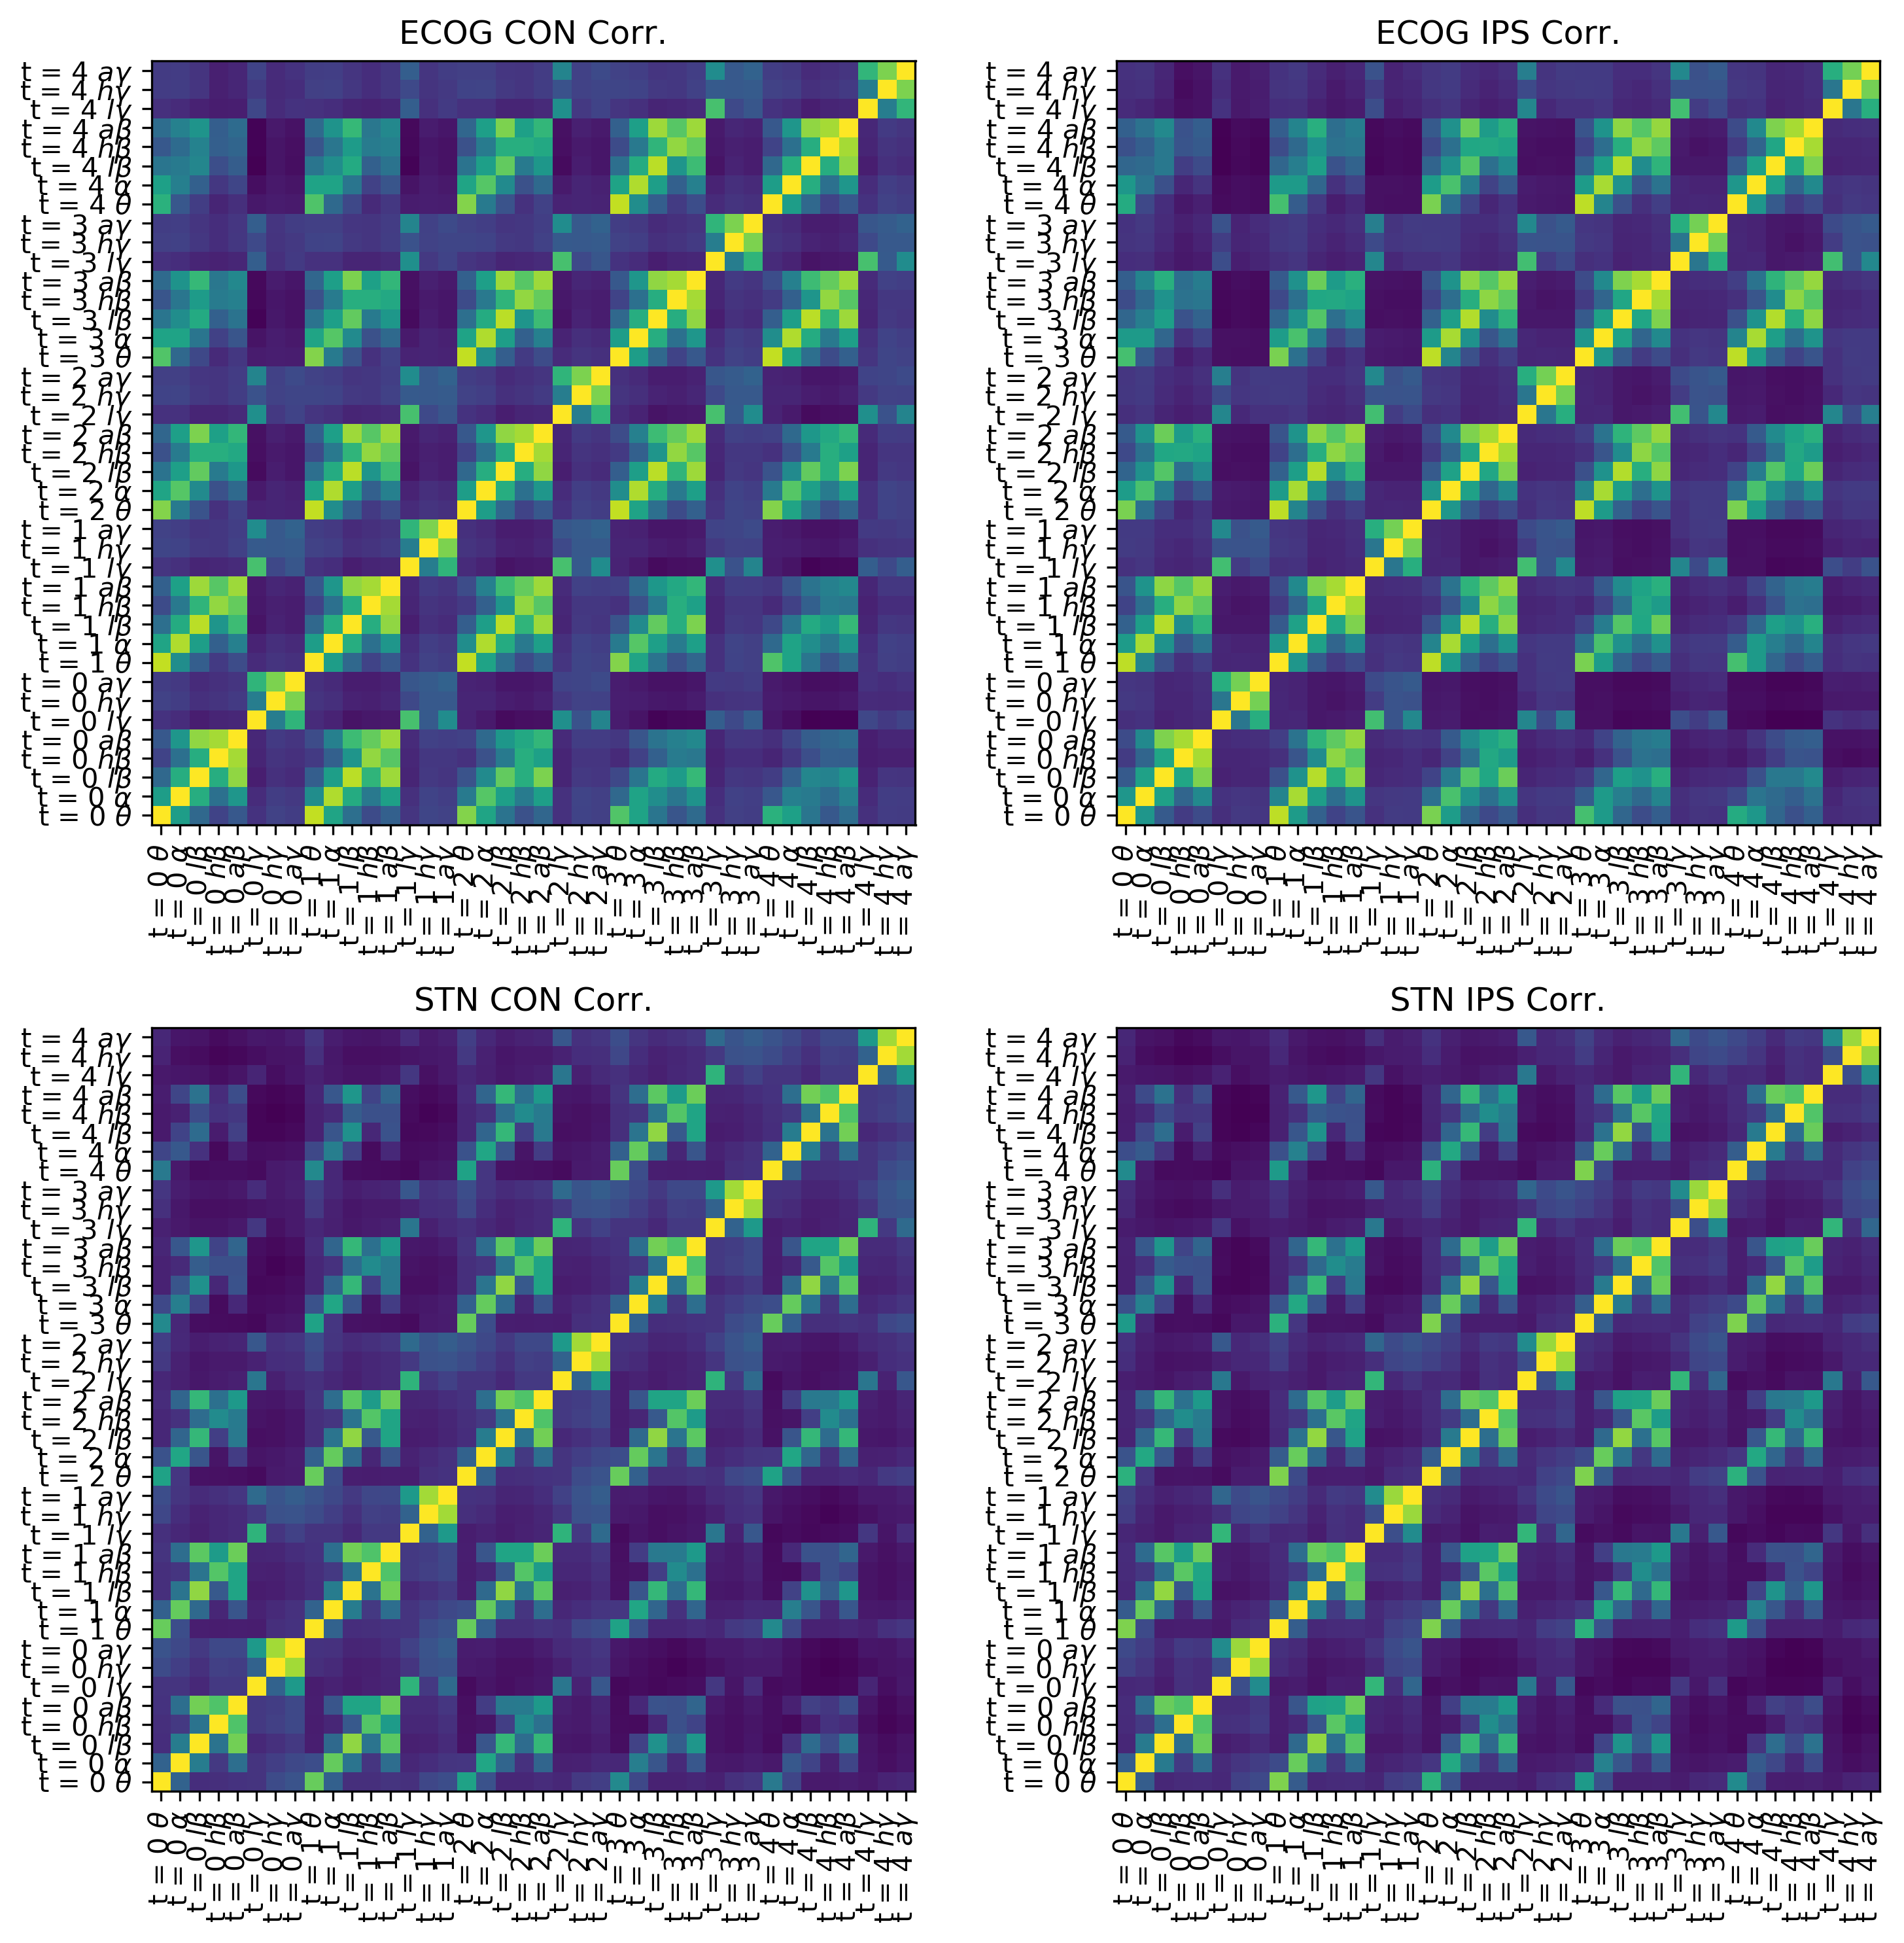

In [77]:
plt.figure(figsize=(10, 10), dpi=300)
plt.subplot(221)
plt.imshow(get_mean_corr_maps(df_best, "ECOG", "CON", ret_ALL=True).mean(axis=0))
plt.xticks(np.arange(0,40,1), t_, rotation=90)
plt.yticks(np.arange(0,40,1), t_)
plt.ylim(-0.5, 39.5)
plt.title("ECOG CON Corr.")
plt.subplot(222)
plt.imshow(get_mean_corr_maps(df_best, "ECOG", "IPS", ret_ALL=True).mean(axis=0))
plt.xticks(np.arange(0,40,1), t_, rotation=90)
plt.yticks(np.arange(0,40,1), t_)
plt.ylim(-0.5, 39.5)
plt.title("ECOG IPS Corr.")
plt.subplot(223)
plt.imshow(get_mean_corr_maps(df_best, "STN", "CON", ret_ALL=True).mean(axis=0))
plt.xticks(np.arange(0,40,1), t_, rotation=90)
plt.yticks(np.arange(0,40,1), t_)
plt.ylim(-0.5, 39.5)
plt.title("STN CON Corr.")
plt.subplot(224)
plt.imshow(get_mean_corr_maps(df_best, "STN", "IPS", ret_ALL=True).mean(axis=0))
plt.xticks(np.arange(0,40,1), t_, rotation=90)
plt.yticks(np.arange(0,40,1), t_)
plt.ylim(-0.5, 39.5)
plt.title("STN IPS Corr.")
plt.tight_layout()
plt.show()

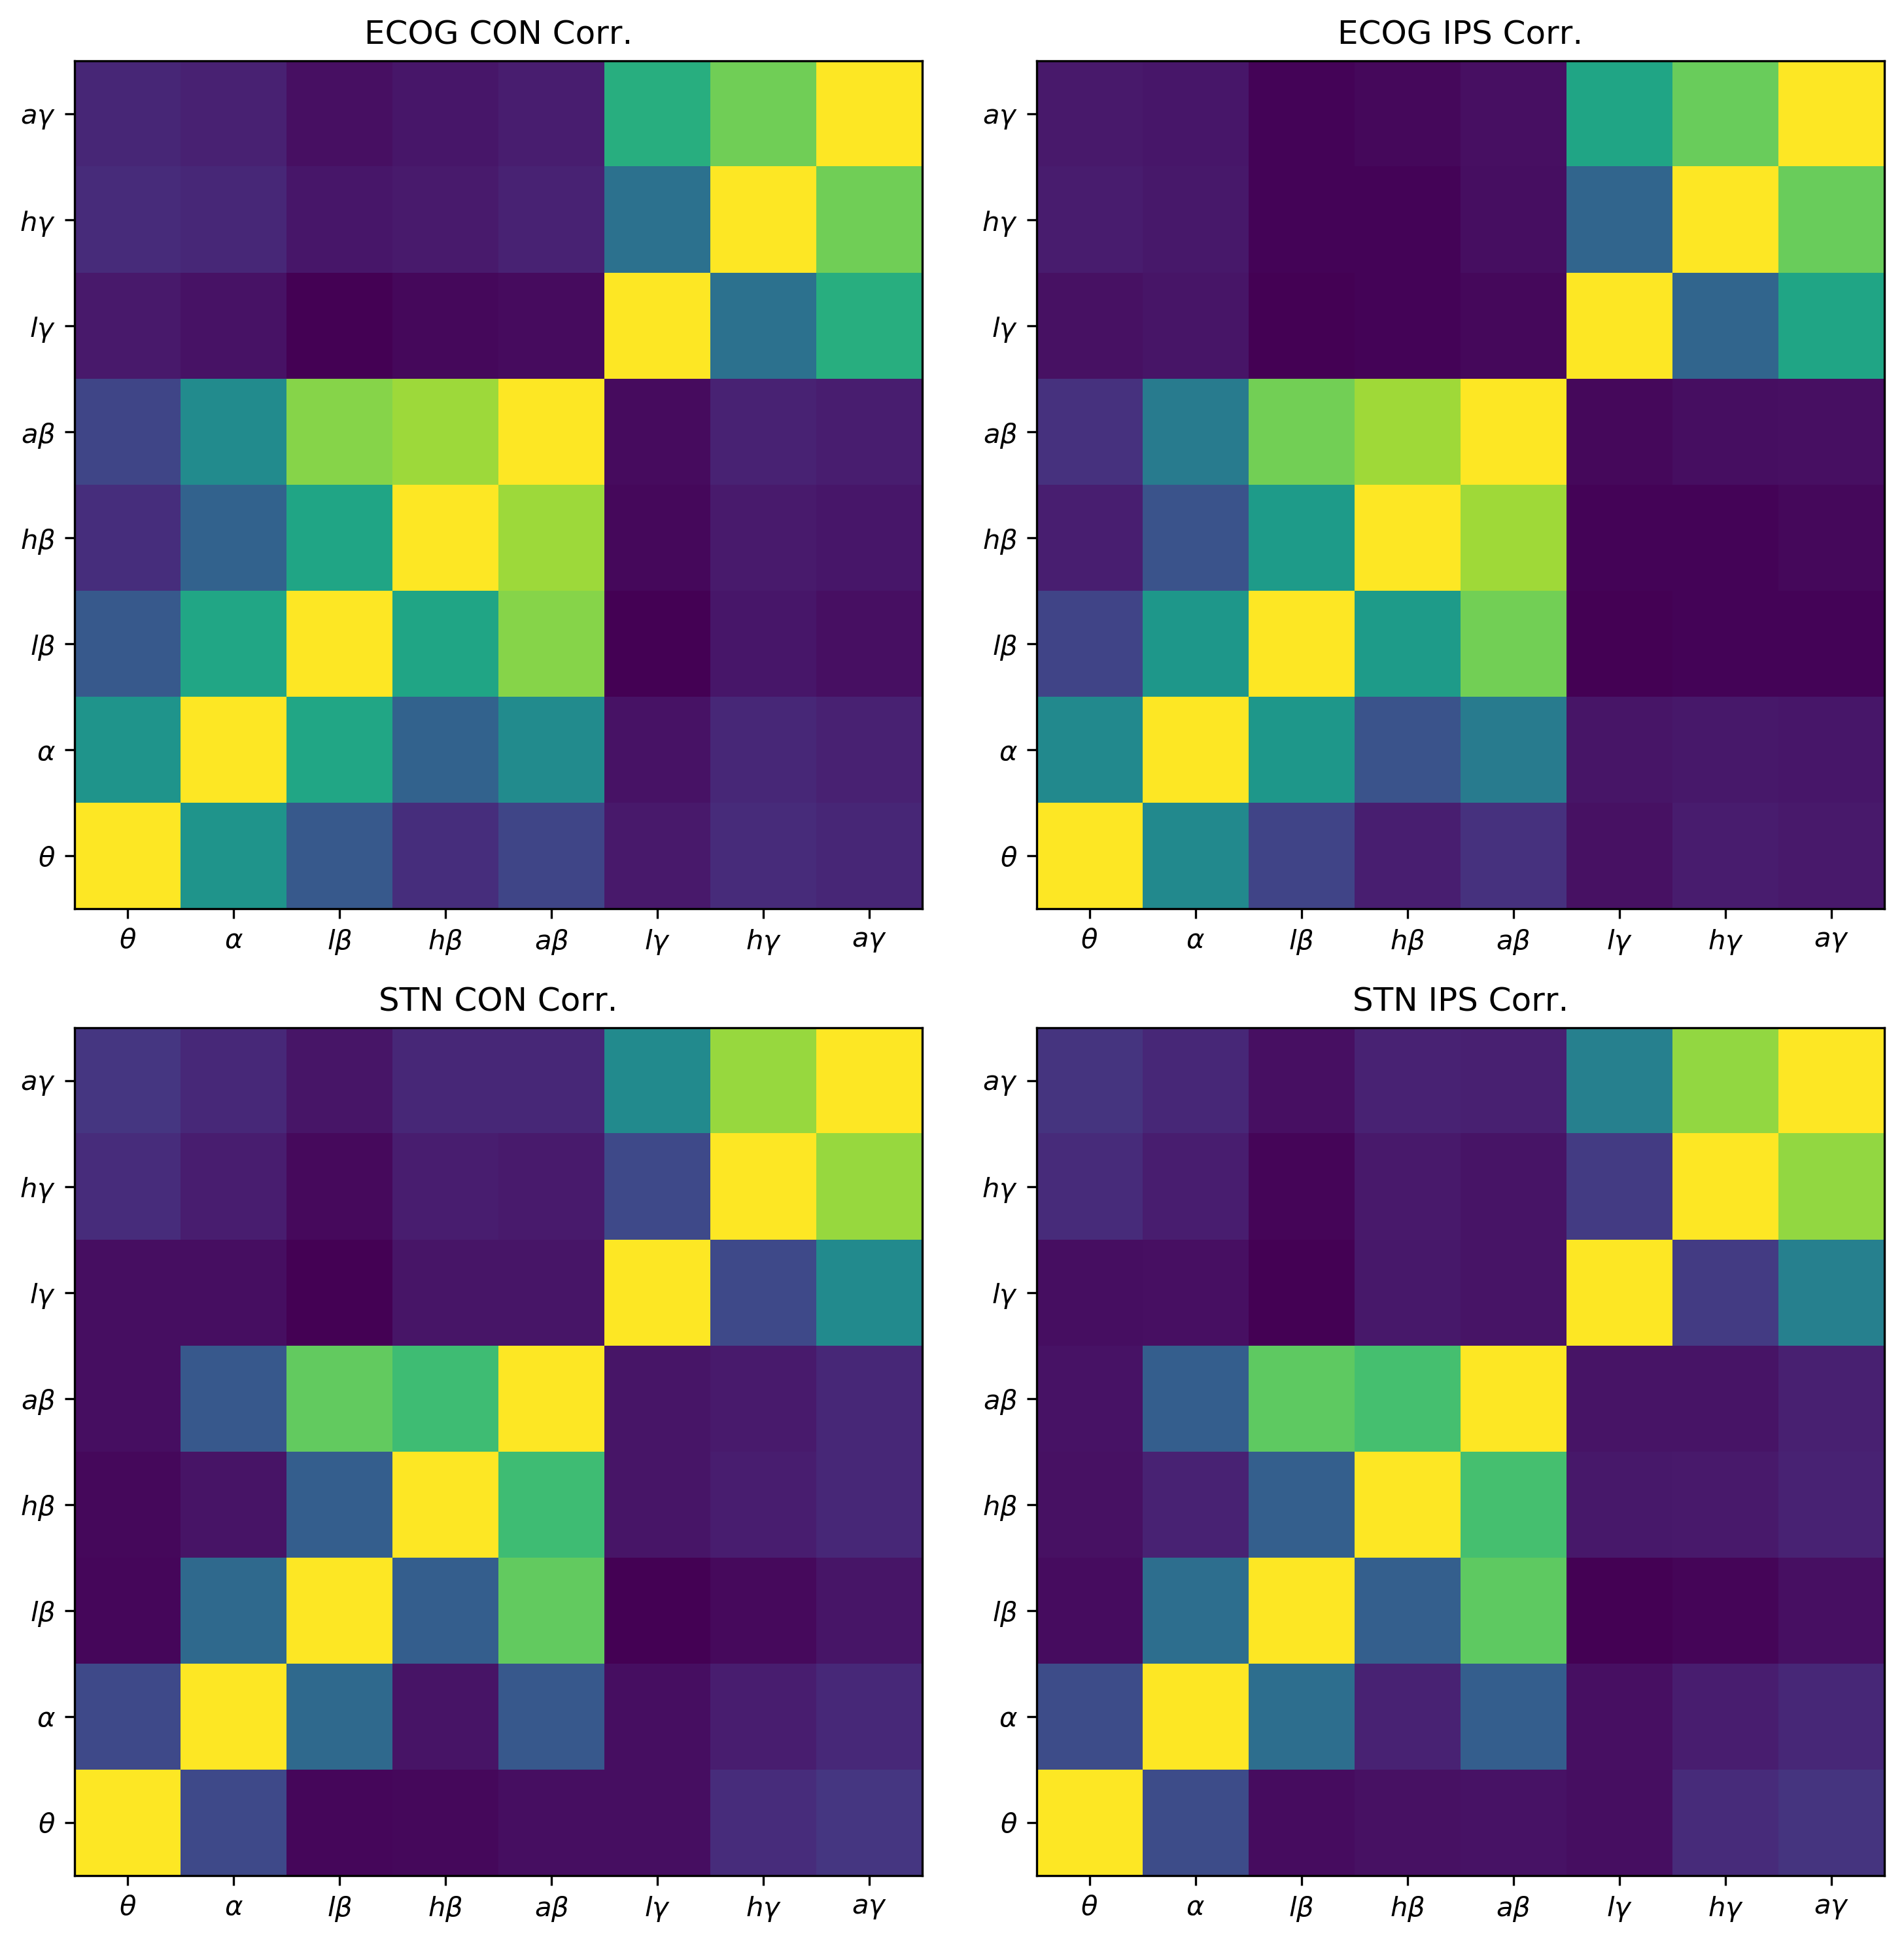

In [78]:
plt.figure(figsize=(10, 10), dpi=300)
plt.subplot(221)
plt.imshow(get_mean_corr_maps(df_best, "ECOG", "CON", ret_ALL=False).mean(axis=0))
plt.xticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
plt.yticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])

plt.ylim(-0.5, 7.5)
plt.title("ECOG CON Corr.")
plt.subplot(222)
plt.imshow(get_mean_corr_maps(df_best, "ECOG", "IPS", ret_ALL=False).mean(axis=0))
plt.xticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
plt.yticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])

plt.ylim(-0.5, 7.5)
plt.title("ECOG IPS Corr.")
plt.subplot(223)
plt.imshow(get_mean_corr_maps(df_best, "STN", "CON", ret_ALL=False).mean(axis=0))
plt.xticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
plt.yticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])

plt.ylim(-0.5, 7.5)
plt.title("STN CON Corr.")
plt.subplot(224)
plt.imshow(get_mean_corr_maps(df_best, "STN", "IPS", ret_ALL=False).mean(axis=0))
plt.xticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
plt.yticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])

plt.ylim(-0.5, 7.5)
plt.title("STN IPS Corr.")
plt.tight_layout()
plt.show()